In [1]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn

from collections import defaultdict
from collections import OrderedDict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score, davies_bouldin_score, euclidean_distances
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist #Condensed matrix output

import mpl_toolkits.mplot3d.axes3d as p3

from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import itertools
from pyclustertend import hopkins

# Task 2: Clustering

In [2]:
vendor_df_num = pd.read_csv('./task1-result_num.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('./task1-result_cat.csv', sep=',', index_col=[0,1])

In [3]:
vendor_df_num.head()

I   Iu  MaxValuePerOrder  \
vendor_code name                                                 
1           1stWave Technologies    774   60        565.439098   
2           Adorama                3274  186       1761.990000   
3           Alternate              3047  203        860.154236   
4           Alternate Italia        407  101        774.077840   
5           Alza                  12959  276       1188.115658   

                                  AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                        
1           1stWave Technologies        132.989886          13.074935   
2           Adorama                     146.248003          14.628894   
3           Alternate                   155.134195          11.530030   
4           Alternate Italia            142.140184          10.034398   
5           Alza                        166.036705          13.514777   

                                  IAvgMonthSales  TotMonthBusiness      Eram  \
vendor_code name                                                               
1           1stWave Technologies     4117.366865                25  5.361843   
2           Adorama                 23940.798168                20  6.754711   
3           Alternate              157564.631150                 3  7.373634   
4           Alternate Italia        28925.527422                 2  6.486558   
5           Alza                   126568.803904                17  7.612859   

                                      Egeo      Ecur  
vendor_code name                                      
1           1stWave Technologies  0.643988  0.643988  
2           Adorama               0.000000  0.000000  
3           Alternate             1.679995  0.000000  
4           Alternate Italia      0.898296  0.898296  
5           Alza                  1.165894  1.094659

In [4]:
vendor_df_cat.head()

TopBrand                TopCountry  \
vendor_code name                                                       
1           1stWave Technologies   CORSAIR                New Zeland   
2           Adorama                CRUCIAL  United States of America   
3           Alternate              G.SKILL                    France   
4           Alternate Italia       G.SKILL                     Italy   
5           Alza                  KINGSTON            United Kingdom   

                                 TopCurrency  TopSalesMonth  
vendor_code name                                             
1           1stWave Technologies         NZD             11  
2           Adorama                      USD              4  
3           Alternate                    EUR              3  
4           Alternate Italia             EUR              3  
5           Alza                         GBP             12

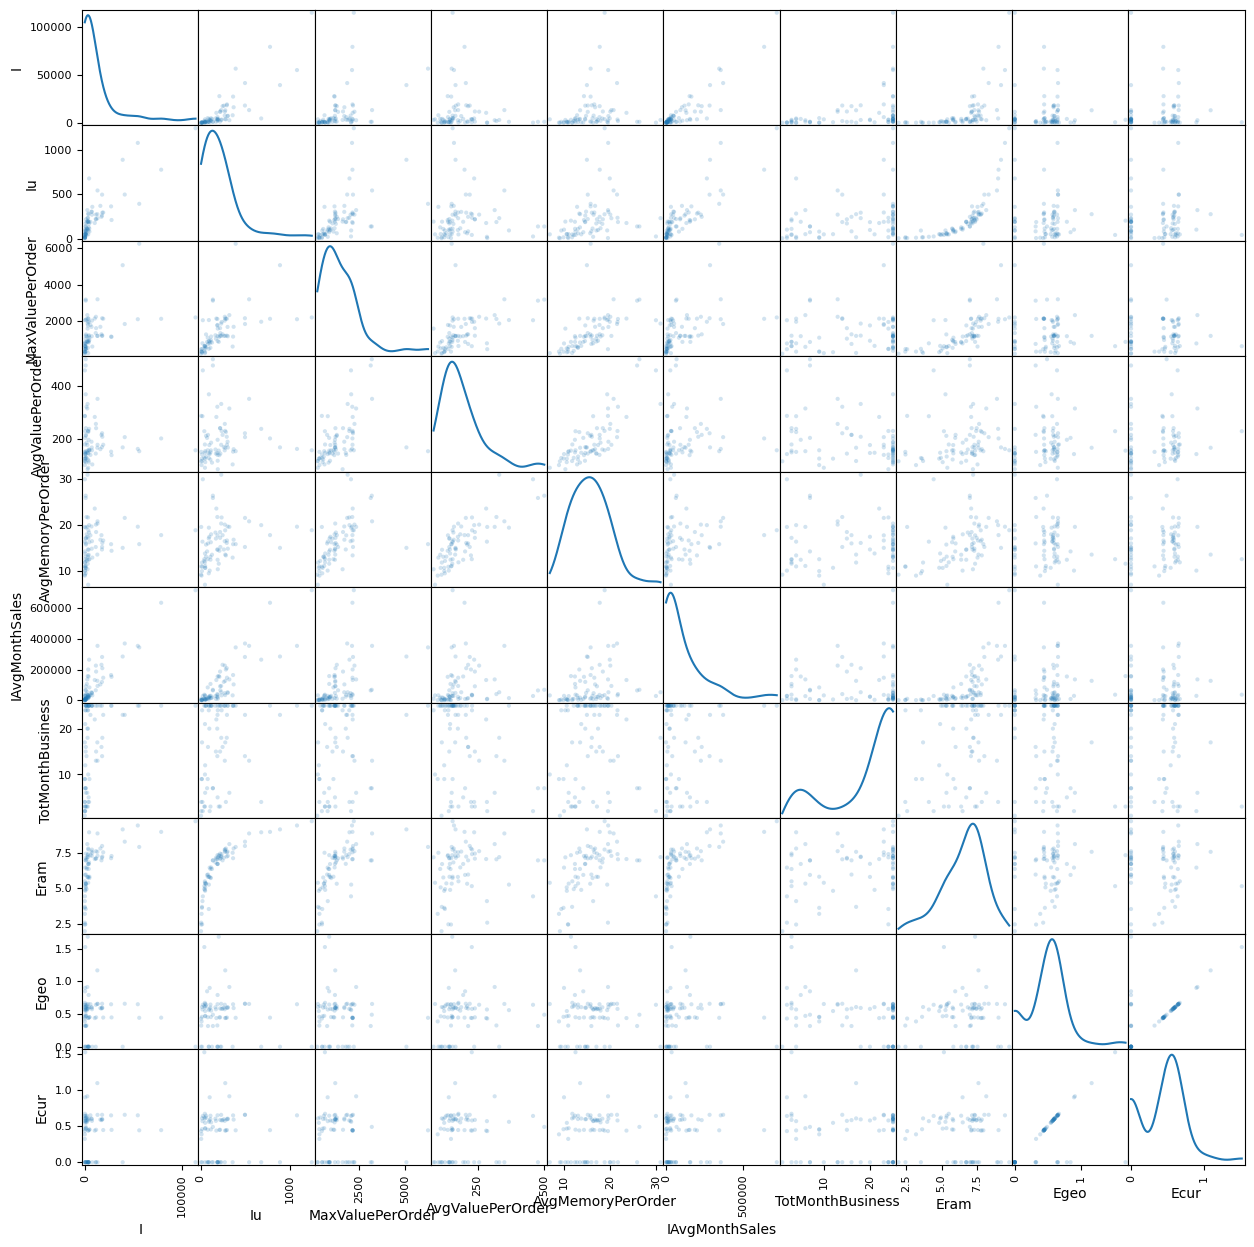

In [5]:
pd.plotting.scatter_matrix(vendor_df_num, alpha=0.2, figsize=(15, 15), diagonal="kde");

## Normalization

In [6]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df_num.values)
vendor_norm = vend_scaler.transform(vendor_df_num.values)
vendor_df_norm = pd.DataFrame(vendor_norm)

## Auxiliary functions

### Miscellaneous

In [7]:
def compute_cluster_means(data_points, labels):
    
    clust_mean = pd.DataFrame()
    for label in sorted(np.unique(labels)):
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_mean = clust_mean.append(cur_clust_df.mean(), ignore_index=True)

    clust_mean = np.array(clust_mean)
    
    return clust_mean

def compute_cluster_stds(data_points, labels):
    
    clust_std = pd.DataFrame()
    for label in sorted(np.unique(labels)):
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_std = clust_std.append(cur_clust_df.std(), ignore_index=True)

    clust_std = np.array(clust_std.replace(np.nan, 0))
    
    return clust_std

#Takes a set of points and computes its sse ignoring labels
def compute_sse_cluster(data_points):
    
    #Consider all points as belonging to the same cluster
    center = compute_cluster_means(data_points, [0 for i in range(len(data_points))])[0]
    
    sum_sq_err = 0
        
    for p in data_points:
        eucl_norm = np.linalg.norm(center-p, ord=2)
        sum_sq_err = sum_sq_err + pow(eucl_norm, 2)
    
    return sum_sq_err
            
#Allows for computing both the global sse with labels or only a subset of the labels
def compute_sse_global(data_points, labels, labels_subset=None):
    
    sum_sq_err = 0
    for label in sorted(np.unique(labels)):
        
        if(labels_subset != None and label not in labels_subset):
            continue
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        sum_sq_err = sum_sq_err + compute_sse_cluster(cur_clust)

    return sum_sq_err

def compute_ideal_similarity_coeff(data_points, cluster_labels):
    
    proximity_matrix = pairwise_distances(data_points)
    
    ideal_matrix = np.empty((len(cluster_labels), len(cluster_labels)))
    
    for i in range(len(cluster_labels) - 1):
        for j in range(i, len(cluster_labels)):
            
            if(cluster_labels[i] == cluster_labels[j]):
                ideal_matrix[i][j] = 1
                ideal_matrix[j][i] = 1
        
    res = np.corrcoef(ideal_matrix, proximity_matrix)
    
    return res

def cluster_dimensions(labels):
    
    label_dict = {x:0 for x in sorted(np.unique(labels))}
    
    for i in range(len(labels)):
        label_dict[labels[i]] = label_dict[labels[i]] + 1
    
    return label_dict

def count_singletons(labels):
    
    dim_list = list(cluster_dimensions(labels).values())

    return dim_list.count(1)

def remap_clust_labels(labels, new_labels_dict):
    
    new_labels = labels.copy()
    
    for i in range(len(new_labels)):
        new_labels[i] = new_labels_dict[new_labels[i]]
        
    return new_labels

def group_singleton_clusters(labels):
    
    count_dict = {id_cluster: 0 for id_cluster in np.unique(labels)}
    grouped_dict = {}
    
    for i in labels:
        count_dict[i] = count_dict[i] + 1
        
    for key in count_dict.keys():
        if count_dict[key] == 1:
            grouped_dict[key] = -1
        else:
            grouped_dict[key] = key
    
    return grouped_dict

def cluster_id_resolver(data_points, labels, conditions_dict, col_names):
    
    avg_list = compute_cluster_means(data_points, labels)
    avg_df = pd.DataFrame(avg_list,columns=col_names)
    
    for key, condition in conditions_dict.items():
        
        loc_str = f'avg_df.loc[avg_df["{key}"] {condition}]'
        avg_df = eval(loc_str)
        
    if avg_df.shape[0] > 1:
        raise RuntimeError("More than 1 cluster determined. More conditions needed.")
        
    if avg_df.shape[0] == 0:
        raise RuntimeError("No valid candidate found.")
        
    return avg_df.index[0]

def create_external_indices(cat_df, model):
    
    ext_ind=pd.DataFrame()

    comb = list()
    hom = list()
    compl = list()
    mutinfo = list()

    for column in cat_df.columns:
        comb.append(column)
        hom.append(metrics.homogeneity_score(cat_df[column], model.labels_))
        compl.append(metrics.completeness_score(cat_df[column], model.labels_))
        mutinfo.append(metrics.normalized_mutual_info_score(cat_df[column], model.labels_, average_method='arithmetic'))

    ext_ind['Feature'] = comb
    ext_ind['Homogeneity'] = hom
    ext_ind['Completeness'] = compl
    ext_ind['Mutual Info'] = mutinfo
    
    return ext_ind

def compare_model_labels(model_dict, map_dict):

    #model_dict = {"name":model}
    #map_dict = {"name":map}
    ext_ind=pd.DataFrame()

    comb1 = list()
    comb2 = list()
    hom = list()
    compl = list()
    mutinfo = list()
    map1 = list()
    map2 = list()
    
    keys_list = list(model_dict.keys())

    for i in range(len(keys_list)):
        
        for j in range(i+1, len(keys_list)):
            
            if i == j:
                continue
            
            key1 = keys_list[i]
            key2 = keys_list[j]
            model1 = model_dict[key1]
            model2 = model_dict[key2]

            comb1.append(key1 + f" ({len(np.unique(model1.labels_))} labels)")
            comb2.append(key2 + f" ({len(np.unique(model2.labels_))} labels)")
            hom.append(metrics.homogeneity_score(model1.labels_, model2.labels_))
            compl.append(metrics.completeness_score(model1.labels_, model2.labels_))
            mutinfo.append(metrics.normalized_mutual_info_score(model1.labels_, model2.labels_, average_method='arithmetic'))
            map1.append(map_dict[key1])
            map2.append(map_dict[key2])

    ext_ind['Model 1'] = comb1
    ext_ind['Model 2'] = comb2
    ext_ind['Homogeneity'] = hom
    ext_ind['Completeness'] = compl
    ext_ind['Mutual Info'] = mutinfo
    ext_ind['Labels 1'] = map1
    ext_ind['Labels 2'] = map2
    
    return ext_ind

### Clustering wrapper classes/functions


In [8]:
#Change cluster labels representation array format from pyclustering to sklearn
#ie [[1,2], [0]] -> [1, 0, 0]
def pyclust_sklearn_cluster_conv(pyclust_array):
    
    tot_len = 0
    
    for array in pyclust_array:
        tot_len = tot_len + len(array)
    
    out_array = np.empty(tot_len, dtype=int)
    
    for i in range(len(pyclust_array)):
        
        for value in pyclust_array[i]:
            out_array[value] = i
            
    return out_array

#Change cluster labels representation array format from sklearn to pyclustering
#ie [1, 0, 0] -> [[1,2], [0]]
def sklearn_pyclust_cluster_conv(sk_array):
    
    n_cluster_ids = len(np.unique(sk_array))
    out_array = [[] for i in range(n_cluster_ids)]
    print(out_array)
    
    for i in range(len(sk_array)):
        out_array[sk_array[i]].append(i)
            
    return out_array

# Compatibility class to use pyclustering's fcm the same as a sklearn model
class fcm_sk:
    
    __n_init = 10
    __init = None
    
    n_clusters = 1
    labels_ = []
    
    def __init__(self, n_clusters=8, init="k-means++", n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.__n_init = n_init
        self.__init = init
        
    def set_params(self, **params):
        
        for key, value in params.items():
            if(key == "n_clusters"):
                self.n_clusters = value
                
    def get_params(self):
        
        return {"n_clusters":self.n_clusters}
        
    def fit(self, X):
        
        best_silhouette = -1
        best_labels = []
        
        for i in range(self.__n_init):
            
            if(isinstance(self.__init, str) and self.__init == "k-means++"):
                # Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
                # start analysis.
                initial_centers = kmeans_plusplus_initializer(X, self.n_clusters).initialize()
                
            elif(isinstance(self.__init, np.ndarray)):
                initial_centers = self.__init
            else:
                raise RuntimeError("init can be 'k-means++' or a numpy ndarray containing the centers")
            
            # Create instance of X-Means algorithm. The maximum number of clusters that can be allocated is 20.
            clust_algo = fcm(X, initial_centers)
            clust_algo.process()

            # Extract clustering results: clusters and their centers
            clusters = clust_algo.get_clusters()
            centers = clust_algo.get_centers()

            cluster_labels = pyclust_sklearn_cluster_conv(clusters)
            
            cur_sil = silhouette_score(X, cluster_labels)
            
            #Take the best results in term of silhouette of all the runs
            if(cur_sil > best_silhouette):
                best_silhouette = cur_sil
                best_labels = cluster_labels
                
        self.labels_ = best_labels
        
        return self
    
#Used to interact with functions that take an sklearn model as input but need only labels_ parameter to function
class wrapper_sk:
    
    n_clusters = 1
    labels_ = []
    linkage = None
    
    def __init__(self, labels):
        self.labels_ = labels
        self.n_clusters = len(labels)
        
    def set_params(self, **params):
        
        for key, value in params.items():
            
            if key == "n_clusters":
                self.n_clusters = value
                
            elif key == "linkage":
                self.linkage = value
                
    def get_params(self):
        
        return {"n_clusters":self.n_clusters, "linkage":self.linkage}

### Visualisation

In [9]:
def plot_metrics(metrics_dict, x_name, x_list, xticks_list):
    
    metrics_list = metrics_dict.keys()
    multiple_plot_bool = False
    
    fig = plt.figure(figsize=(20,5))
    fig_dims = (1, 1)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    #Separate plot for sse to get a feel for the scale
    if("sse" in metrics_list):
        
        if(len(metrics_list) > 1):
            fig_dims = (1, 2)
            plt.subplot2grid(fig_dims, (0, 0))
            multiple_plot_bool = True
        
        sse_list = np.reshape(metrics_dict["sse"], (-1, 1))

        plt.plot(x_list, sse_list, label='SSE')
        
        plt.xlabel(x_name, fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.xticks(xticks_list)
        plt.legend()
    
    #Enable second subplot
    if(multiple_plot_bool):
            plt.subplot2grid(fig_dims, (0, 1))
        
    #All other metrics
    for metric in metrics_list:
          
        if(metric.lower() == "sse"):
            continue
        elif(metric.lower() == "db"):
            plt.plot(x_list, metrics_dict[metric], label='Davies-Bouldin')
        elif(metric.lower() == "sil"):
            plt.plot(x_list, metrics_dict[metric], label='Silhouette')
        elif(metric.lower() == "noise_ratio"):
            plt.plot(x_list, metrics_dict[metric], label='Noise ratio')
        elif(metric.lower() == "clusters"):
            for i in range(len(metrics_dict["clusters"])):
                plt.scatter(x_list[i], 1, marker=f"${metrics_dict['clusters'][i]}$")
        else:
            raise RuntimeError

    plt.xlabel(x_name, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xticks(xticks_list)
    plt.legend()
    
    plt.show()

    
def plot_metrics_per_k(data_points, metrics_arr, model_sk=None):
    max_k = 20
    metrics_dict = {}
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()

    for k in range(2, max_k + 1): #Starting from k=2 to k=40
        
        if model_sk:
            model_sk.set_params(**{"n_clusters":k})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "sse"):
                metrics_dict[metric].append(compute_sse_global(data_points, cluster_labels))
            elif(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "K", np.arange(2, max_k+1, 1), np.arange(0, max_k+1, 2))
    
    
def plot_metrics_per_eps(data_points, metrics_arr, max_eps=3, precision=0.10, model_sk=None):
    metrics_dict = {}
    eps_list = list()
    
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()
        
    for i in range(int(max_eps//precision)):
        
        e = i*precision
        if(e == 0):
            e = precision
        
        if model_sk:
            model_sk.set_params(**{"eps":e})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
            
            # Avoid problem with silhouette and singleton cluster
            if(len(np.unique(cluster_labels)) >= 2):
                eps_list.append(e)
            else:
                continue
            
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "sse"):
                metrics_dict[metric].append(compute_sse_global(data_points, cluster_labels))
            elif(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            elif(metric.lower() == "noise_ratio"):
                metrics_dict[metric].append(list(cluster_labels).count(-1)/len(cluster_labels))
            elif(metric.lower() == "clusters"):
                metrics_dict[metric].append(len(np.unique(cluster_labels)))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "Eps", eps_list, eps_list)
    
    
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, max_d=[0], **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples] #Non-leaf node indexing
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("Distance")
    
    # Plot the corresponding dendrogram
    dendrogram(
        linkage_matrix, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        **kwargs)
    
    if max_d[0] != 0:
        for i in max_d:
            plt.axhline(y=i, c='k')
        
    plt.show()

    
#Useful because it works with simple arrays
def plot_parallel_lines(data_points, labels_list, title=None):
    
    if(title != None):
        plt.title(title)
    
    for i in range(0, len(data_points)):
        color_space_len = (np.max(labels_list) - np.min(labels_list)) + 1
        colors = plt.cm.rainbow(np.linspace(0, 1, color_space_len))
        plt.plot(data_points[i], marker='o', label='Cluster %s' % labels_list[i], color=colors[labels_list[i]])
        
    plt.tick_params(axis='both', which='major')
    #Vendor dataframe hard-coded
    plt.xticks(range(0, len(vendor_df_num.columns)), vendor_df_num.columns, rotation=90)
    plt.legend(fontsize=10)
    

def plot_knn_dist(nearest_n_list, datapoints_list):

    if(len(datapoints_list) != len(nearest_n_list)):
        raise RuntimeException
        
    list_len = len(nearest_n_list)
    nearest_dist_list = list()
    
    for i in range(list_len):
        
        nbrs = NearestNeighbors(n_neighbors=nearest_n_list[i], algorithm='ball_tree').fit(datapoints_list[i])
        distances, indices = nbrs.kneighbors(datapoints_list[i])

        nearest_dist_list.append(
            pd.DataFrame(distances)[nearest_n_list[i]-1].sort_values().reset_index()\
            .rename({"index":"orig_point", nearest_n_list[i]-1:"distance"}, axis=1)
        )

    # Knndistplot
    fig = plt.figure(figsize=(20, 5)) 
    fig_dims = (1, list_len)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
        
    for i in range(list_len):

        plt.subplot2grid(fig_dims, (0, i))
        plt.title("Knn-distplot")
        nearest_dist_list[i]["distance"].plot()
        plt.xlabel("Points sorted by distance")
        plt.ylabel(f"Distance to the {nearest_n_list[i]}-nth neighbour")

    plt.show()


# Note: run %matplotlib notebook to enable interactivity
def plot_3d_scatter(data_points_list, labels_list=None):
    
    if(labels_list):
        if(len(data_points_list) != len(labels_list)):
            raise RuntimeError
        
    list_size = len(data_points_list)
    entries_dim = len(data_points_list[0])
    
    #If greater than 3 dimensions, use pca to reduce to 3
    if entries_dim > 3:
        data_points_list = data_points_list.copy()
        for i in range(len(data_points_list)):
            data_points_list[i] = pd.DataFrame(PCA(n_components=3).fit_transform(data_points_list[i]))
    
    if(list_size == 1):
        fig = plt.figure(figsize=(10+5*list_size,10+5*list_size))
    else:
        fig = plt.figure(figsize=(5*list_size,5*list_size))
    
    for i in range(list_size):
        
        #2 blocks per row
        ax = fig.add_subplot((list_size+1)//2, 2, i+1, projection='3d') #row, column, index
        X = data_points_list[i].copy()
        
        if(labels_list):

            if(len(data_points_list[i]) != len(labels_list[i])):
                raise RuntimeError

            X.loc[:, "label"] = labels_list[i]
            #Use color maps to assign colors automatically
            colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels_list[i]))))

            for l in sorted(np.unique(labels_list[i])):
                ax.scatter(X.loc[X.label == l, 0], X.loc[X.label == l, 1], X.loc[X.label == l, 2],
                           color=colors[l],
                           s=20, edgecolor='k', label='Cluster %s' % l)
            
            plt.legend(fontsize=10)
        else:
            ax.scatter(X[0], X[1], X[2], s=20, edgecolor='k')

    plt.show()
    

def plot_sample_silhouette(data_points_list, k, labels):
    
    # Silhouette scores per sample
    sample_sil_vals = silhouette_samples(data_points_list, labels)
    bar_colors = []
    y_lower = 10
    
    for i in np.unique(labels):
        #Group samples by cluster and sort by value
        clust_sil_vals = sample_sil_vals[labels == i]

        clust_sil_vals.sort()

        clust_size = clust_sil_vals.shape[0]
        y_upper = y_lower + clust_size

        color = plt.cm.rainbow(float(i) / k)
        bar_colors.append(color)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, clust_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots
        plt.text(-0.05, y_lower + 0.5 * clust_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.xlabel("Silhouette coefficients")
    plt.ylabel("Cluster")

    # Silhouette average
    avg_sil = silhouette_score(data_points_list, labels)
    avg_string = f"Avg. sil= {avg_sil:.4f}"
    plt.axvline(x=avg_sil, linestyle="--", label=avg_string)

    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    
    
def plot_categ_per_cluster(cat_df, model, clust_dict=None):
    
    fig, axes = plt.subplots(nrows=(len(cat_df.columns)+1)//2, ncols=2, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.6, wspace=0.2)
    
    if clust_dict != None:
        clust_new_labels = np.array([clust_dict[x] for x in model.labels_])
    
    for i in range(len(cat_df.columns)):
        
        col = cat_df.columns[i]
        
        xt_pct = pd.crosstab(model.labels_, cat_df[col])
        
        if clust_dict != None:
            xt_pct = pd.crosstab(clust_new_labels, cat_df[col])
        
        xt_pct.plot(kind='bar', stacked=False, xlabel='Cluster', ylabel="Count", title=col, ax=axes[i//2][i%2])

    plt.show()
    

def visualise_model_characteristics(datapoints_list, model_list, 
                                    char_list=["general", "avg"], model_names=None):

    if len(datapoints_list) != len(model_list):
        raise RuntimeException
        
    if model_names != None and len(model_list) != len(model_names):
        raise RuntimeException

    list_dim = len(datapoints_list)

    if("general" in char_list):
        #Dataframe to contain general info of the clusterings
        df_cols = ["Num. clusters", "Datapoints per cluster", "Num. singleton clusters", "SSE", "Avg. silhouette", "Davies-Bouldin"]
        info_df = pd.DataFrame(columns=df_cols)
        
        for i in range(list_dim):
            info_df.loc[i, "Num. clusters"] = len(np.unique(model_list[i].labels_))
            info_df.loc[i, "Datapoints per cluster"] = [cluster_dimensions(model_list[i].labels_)]
            info_df.loc[i, "Num. singleton clusters"] = count_singletons(model_list[i].labels_)
            info_df.loc[i, "SSE"] = compute_sse_global(datapoints_list[i], model_list[i].labels_)
            info_df.loc[i, "Avg. silhouette"] = silhouette_score(datapoints_list[i], model_list[i].labels_)
            info_df.loc[i, "Davies-Bouldin"] = davies_bouldin_score(datapoints_list[i], model_list[i].labels_)
            
        info_df = info_df.rename_axis("Clustering Id")            
        print(info_df.to_string())
            

    if("3d" in char_list):
        plot3d_labels = list()

        for i in range(list_dim):
            plot3d_labels.append(model_list[i].labels_)
        plot_3d_scatter(datapoints_list, plot3d_labels)

    if("avg" in char_list):

        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
                
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            plot_parallel_lines(compute_cluster_means(datapoints_list[i], model_list[i].labels_), sorted(np.unique(model_list[i].labels_)), \
                                f"Cluster centers (Clustering {clustering_name})")
            
        plt.show()
    
    if("std" in char_list):
        
        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
            
            plot_parallel_lines(compute_cluster_stds(datapoints_list[i], model_list[i].labels_), sorted(np.unique(model_list[i].labels_)), \
                                f"Cluster stds (Clustering {clustering_name})")
            plt.axhline(y=0.10)
            
        plt.show()
        
    if("sample_sil" in char_list):
        
        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            plt.title(f"Silhouette plot (Clustering {clustering_name})")
            plot_sample_silhouette(datapoints_list[i], len(np.unique(model_list[i].labels_)), model_list[i].labels_)
            
        plt.show()
        
    if("simil_matrix" in char_list):
        
        fig, axes = plt.subplots(nrows=math.ceil(list_dim/2), ncols=2, figsize=(20, math.ceil(list_dim/2)*5))
        
        #Remove empty subplot if the number of models is odd
        if list_dim%2 == 1:
            fig.delaxes(axes[math.ceil(list_dim/2)-1, 1])
        
        for i in range(list_dim):
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            simil_coeff = compute_ideal_similarity_coeff(datapoints_list[i], model_list[i].labels_)
            axes[i//2, i%2].set_title(f"Similarity matrix (Clustering {clustering_name})")
            axes[i//2, i%2].matshow(simil_coeff)
            
        plt.show()

## Task 2.1: Prototype-based clustering

### Hierarchical hints

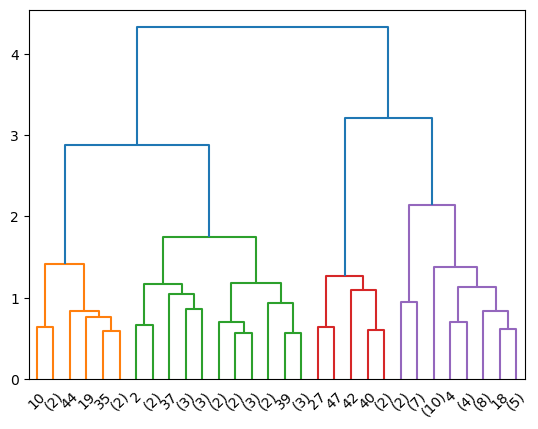

In [10]:
data_dist = pdist(vendor_norm, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, color_threshold=2.5, truncate_mode='lastp')

The hierarchical clustering (using the Ward method) suggests that the optimal number of clusters for this dataset is 4.

### K-means

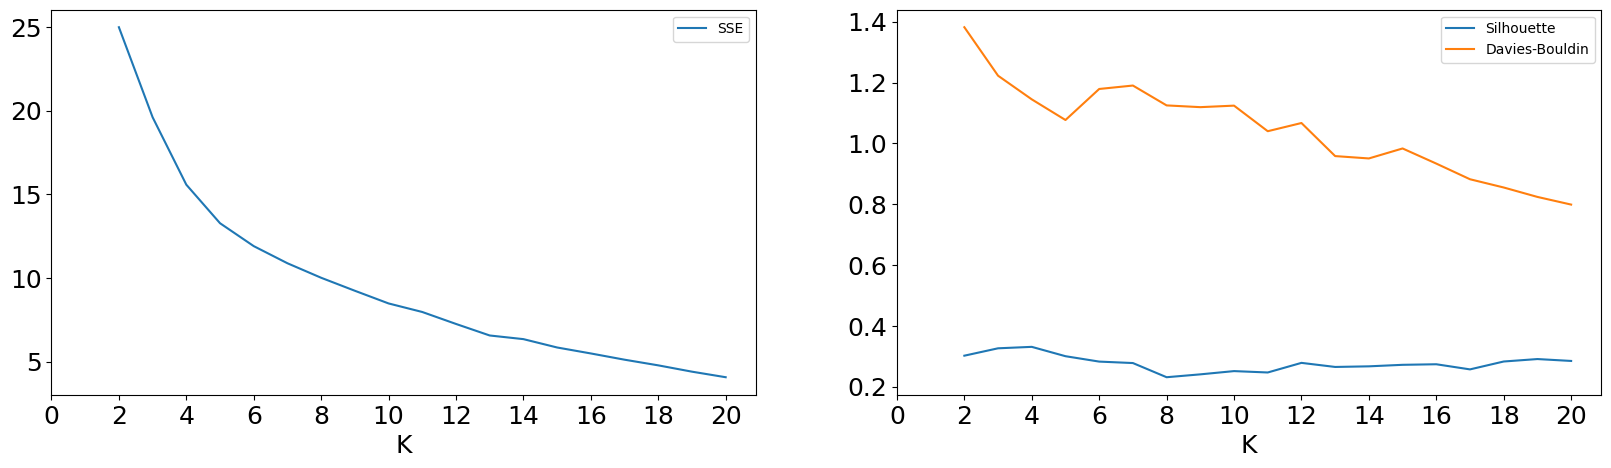

In [11]:
#The number of n_clusters is just for init purpouses
plot_metrics_per_k(vendor_norm, ["sil", "db", "sse"], model_sk=KMeans(n_clusters=1, n_init=20, max_iter=100))

The metrics plotted and the knee method seem to suggest an optimal value for some value of k in the range [2,5].  
We will explore the outcome of these values.

              Num. clusters               Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                     
0                         2                     [{0: 50, 1: 25}]                       0  24.985524        0.301923       1.381884
1                         3               [{0: 44, 1: 24, 2: 7}]                       0  19.604555        0.326206       1.222483
2                         4        [{0: 18, 1: 6, 2: 13, 3: 38}]                       0  15.571788        0.330955       1.144719
3                         5  [{0: 20, 1: 9, 2: 6, 3: 30, 4: 10}]                       0   13.29226         0.30787       1.055525


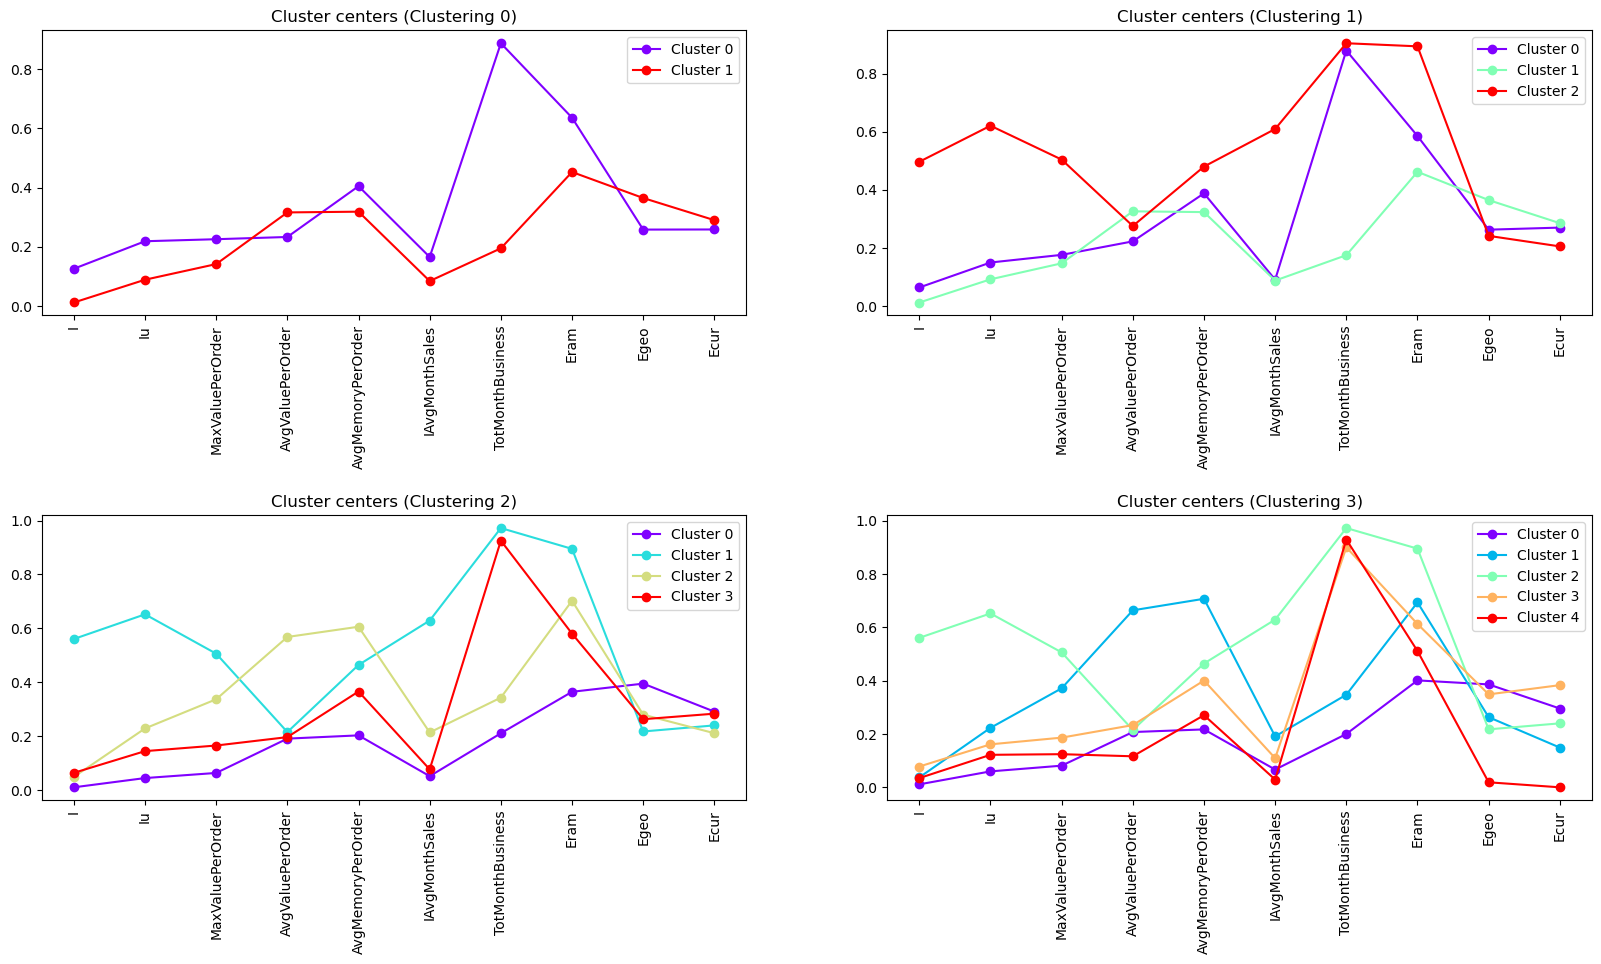

In [12]:
kmeans_clusters = [2,3,4,5]
kmeans_res = []

for i in kmeans_clusters:
    kmeans_res.append(KMeans(n_clusters=i, n_init=20, max_iter=100).fit(vendor_norm))

#Unfortunately it's not possible to make any guarantee that the clusters will have the same colors across clusterings
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res)

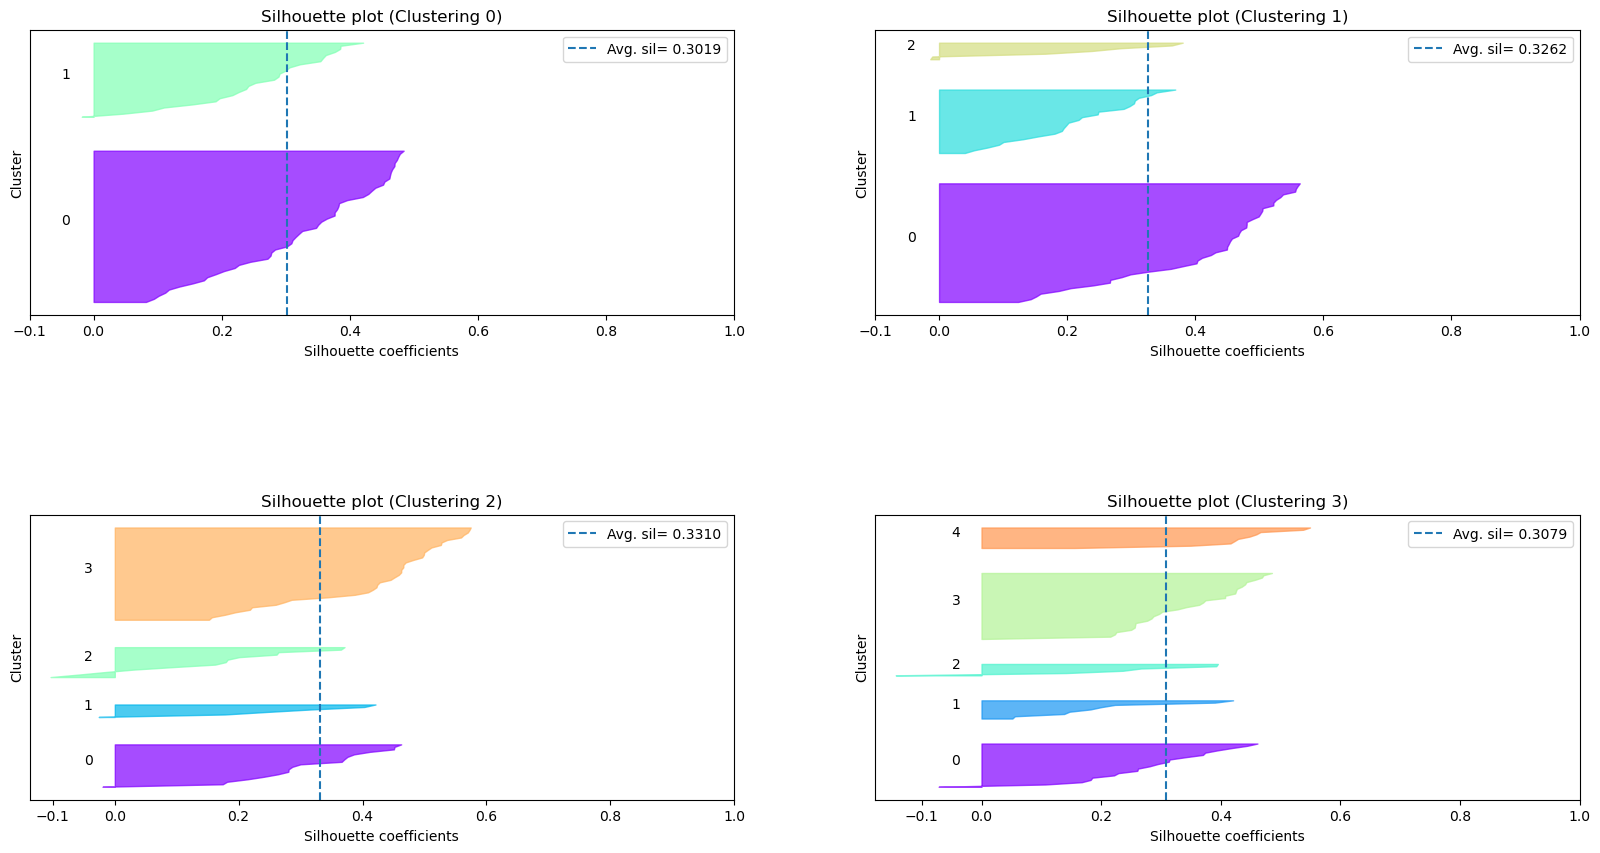

In [13]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res, ["sample_sil"])

The best results in term of silhouette are from k=3 and k=4, however both present datapoints with a negative score which means that they are closer on average to a different cluster to the one they belong to.

The clustering with k=3 is the most interesting to characterise:
- Cluster 0 presents a high value for I, Iu, TotMonthBusiness and IAvgMonthSales, signifying that it is a long standing, high profit, high volume vendor
- Cluster 1,2 are all characterised by a low sales volume however (I, Iu), cluster 2 vendors are older on average (TotMonthBusiness) and cluster 1 contains vendors are newer  

We can assign each a label: **old-big** (0), **new-small** (1), **old-small** (2) vendors.  

In [14]:
kmeans_final = kmeans_res[1]

#Rough characterisation of the clusters in order to define a stable mapping between the cluster with the desired behaviour and a string label
#Needed because the cluster id could change after each run of the clustering algorithm
old_big_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                       {"I": ">0.4", "TotMonthBusiness": ">0.6"}, vendor_df_num.columns)
new_small_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                         {"I": "<0.4", "TotMonthBusiness": "<0.6"}, vendor_df_num.columns)
old_small_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                         {"I": "<0.4", "TotMonthBusiness": ">0.6"}, vendor_df_num.columns)

cluster_map_kmeans = {old_big_id_kmeans:"old-big", new_small_id_kmeans:"new-small", old_small_id_kmeans:"old-small"}

### External indices

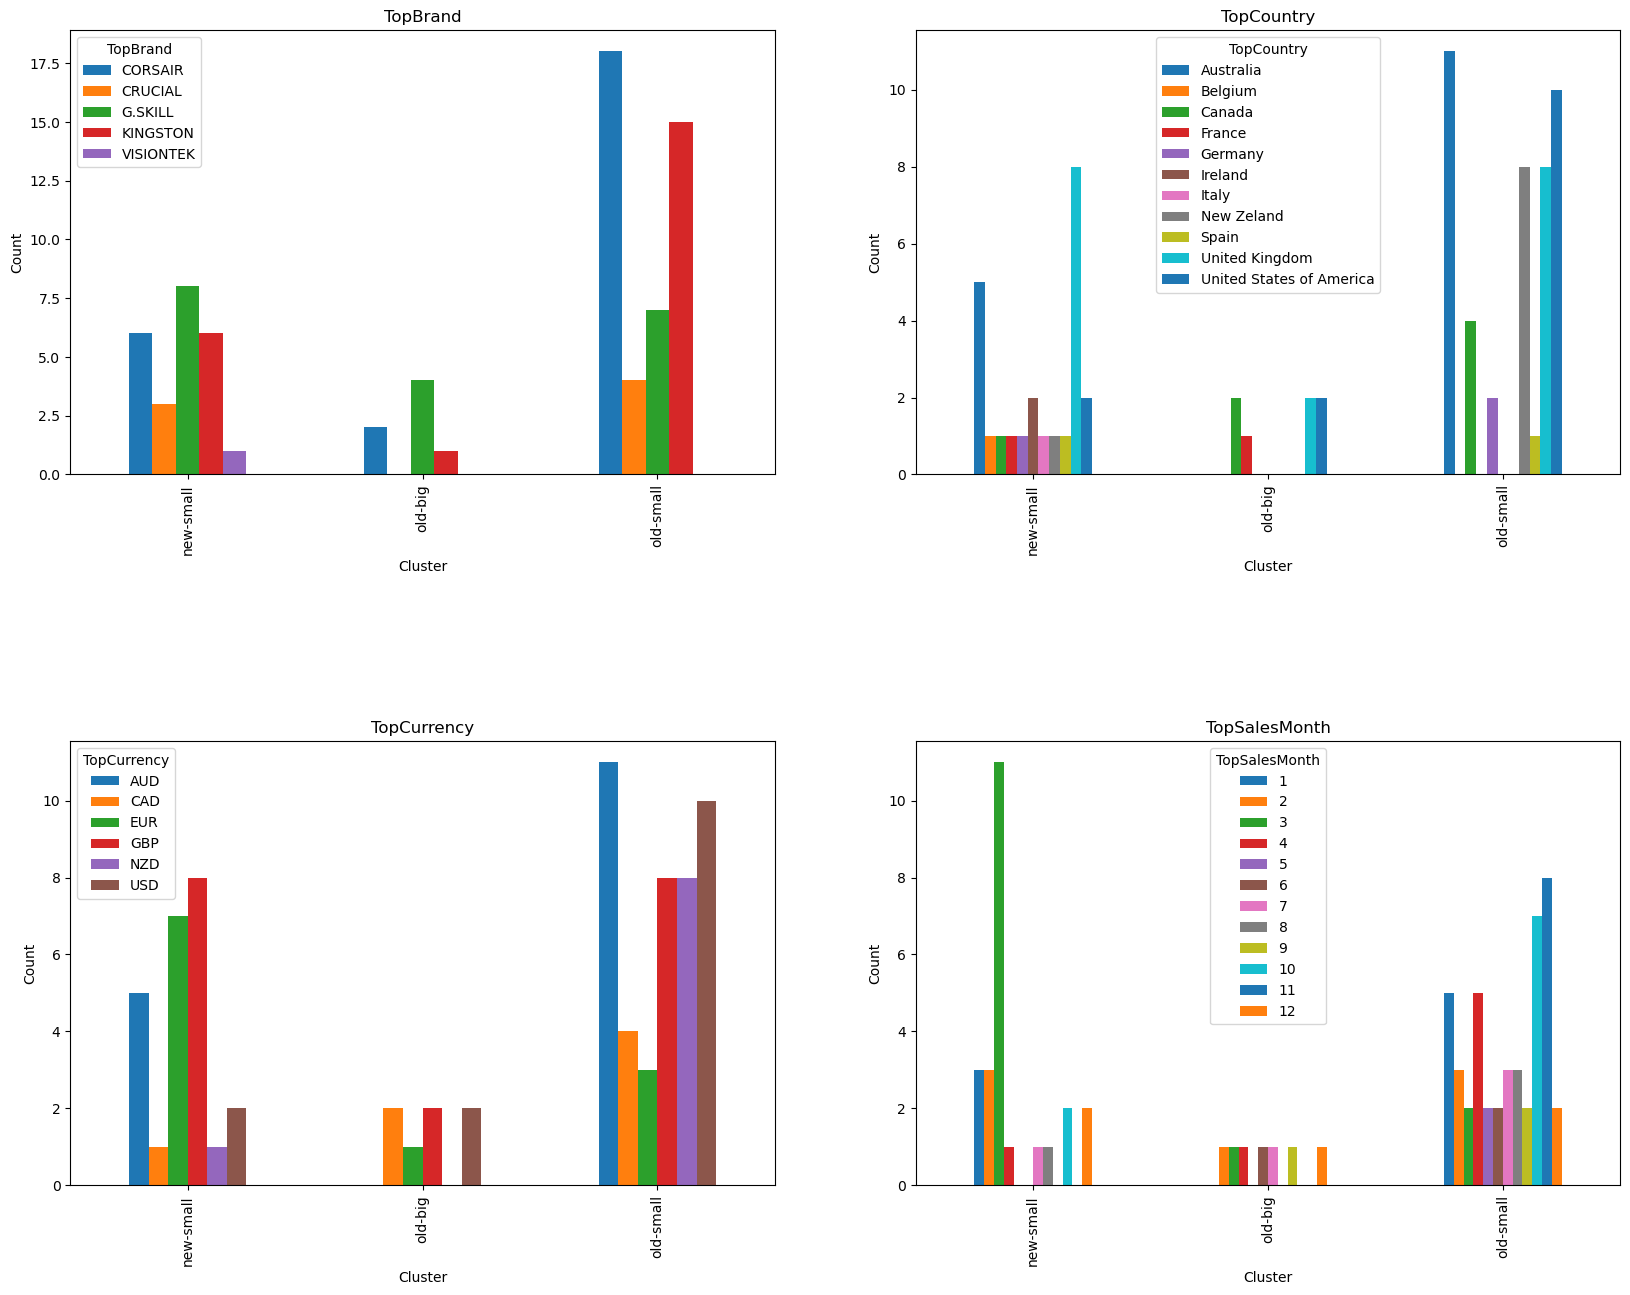

In [15]:
plot_categ_per_cluster(vendor_df_cat, kmeans_final, cluster_map_kmeans)

Some interesting insights on these clusters:  
- The european currencies (EUR, GBP) represent the majority of top currencies for new-small/old-small
- The USD is concentrated mostly in the old-small label
- The vast majority of new-small's sales take place in the month of March
- The vast majority of the vendors are classified as small

In [16]:
create_external_indices(vendor_df_cat, kmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.052312      0.078789     0.062877
1     TopCountry     0.096548      0.214292     0.133119
2    TopCurrency     0.073973      0.143423     0.097604
3  TopSalesMonth     0.110030      0.288831     0.159355

Nothing too remarkable.

## Fuzzy c-means

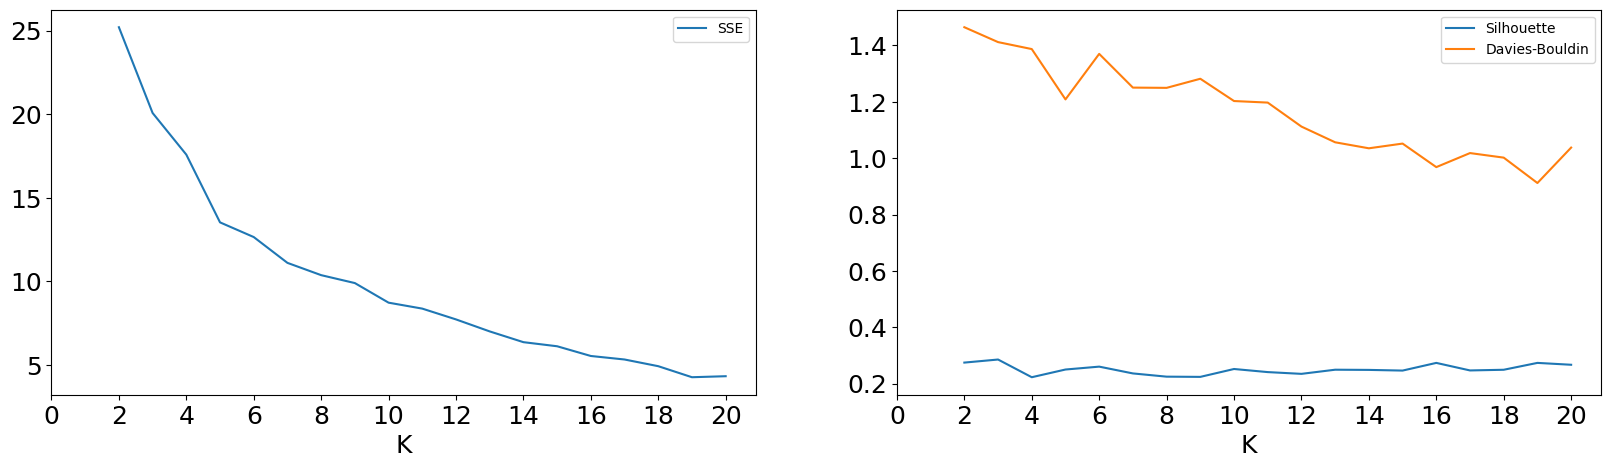

In [17]:
#Might take a bunch of seconds
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=fcm_sk(n_clusters=1, n_init=20, max_iter=100))

              Num. clusters                Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                      
0                         2                      [{0: 44, 1: 31}]                       0  25.207743        0.274823       1.464526
1                         3               [{0: 35, 1: 19, 2: 21}]                       0  20.075618        0.285702       1.411721
2                         4        [{0: 21, 1: 19, 2: 23, 3: 12}]                       0   17.58426        0.222916       1.387027
3                         5  [{0: 13, 1: 16, 2: 6, 3: 22, 4: 18}]                       0  13.528836        0.249969       1.213497


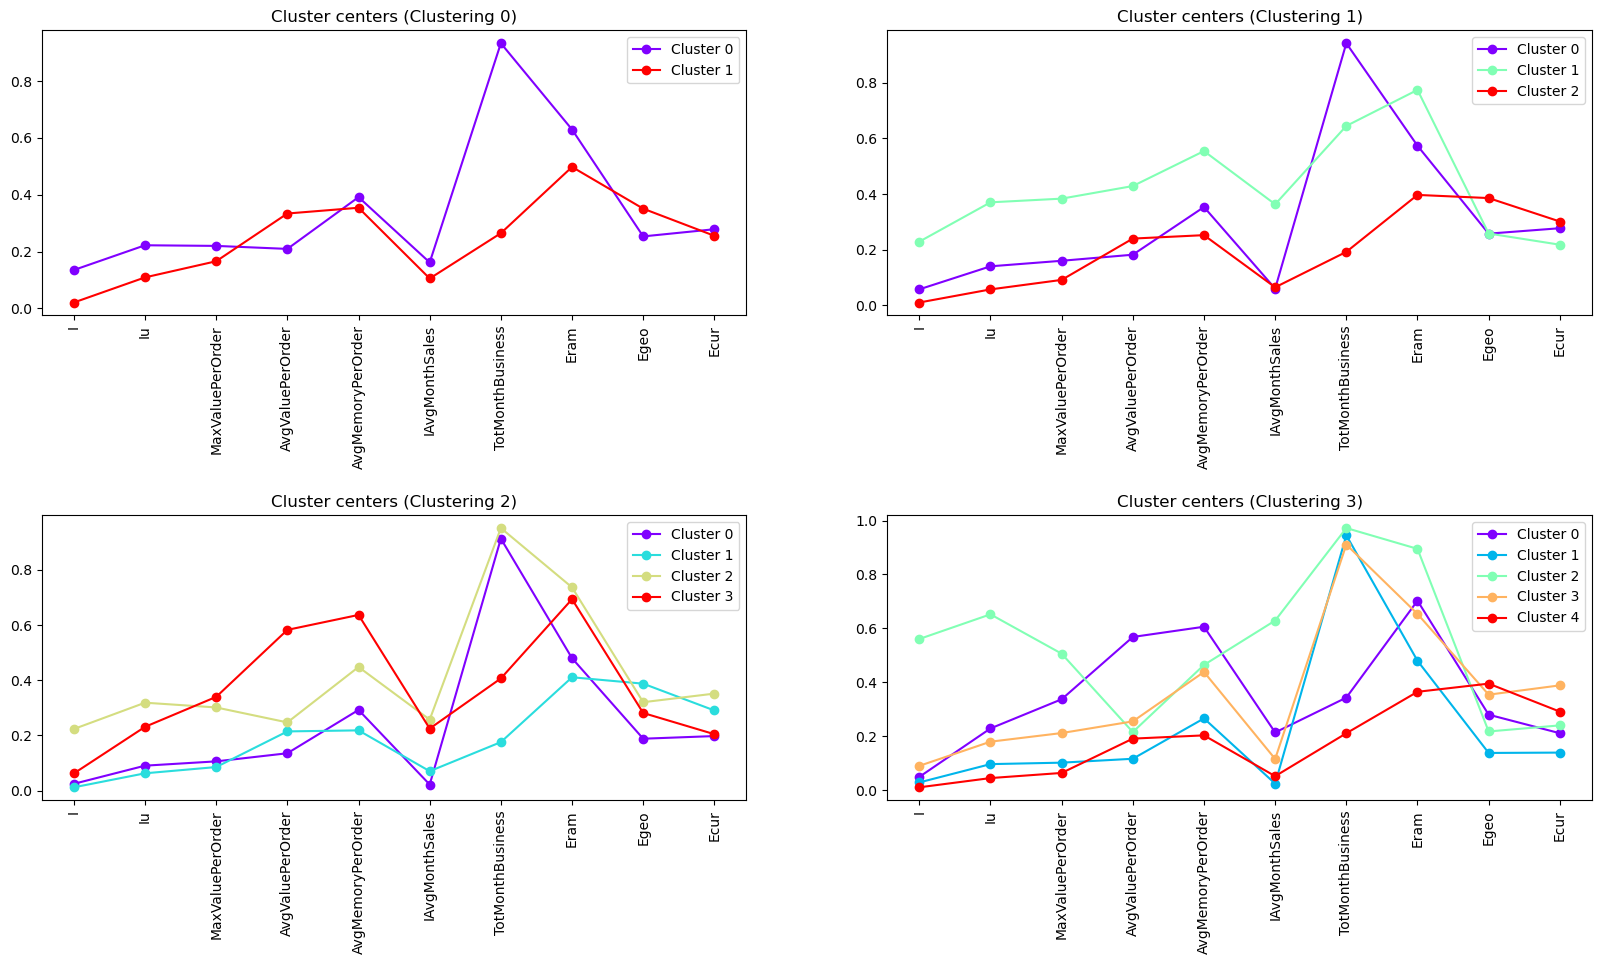

In [18]:
fcm_clusters = [2,3,4,5]
fcm_res = []

for i in fcm_clusters:
    fcm_res.append(fcm_sk(n_clusters=i, n_init=20, max_iter=100).fit(vendor_norm))

#We only use the labels from the clustering, the datapoints are from the normalised dataset
visualise_model_characteristics([vendor_norm]*len(fcm_clusters), fcm_res)

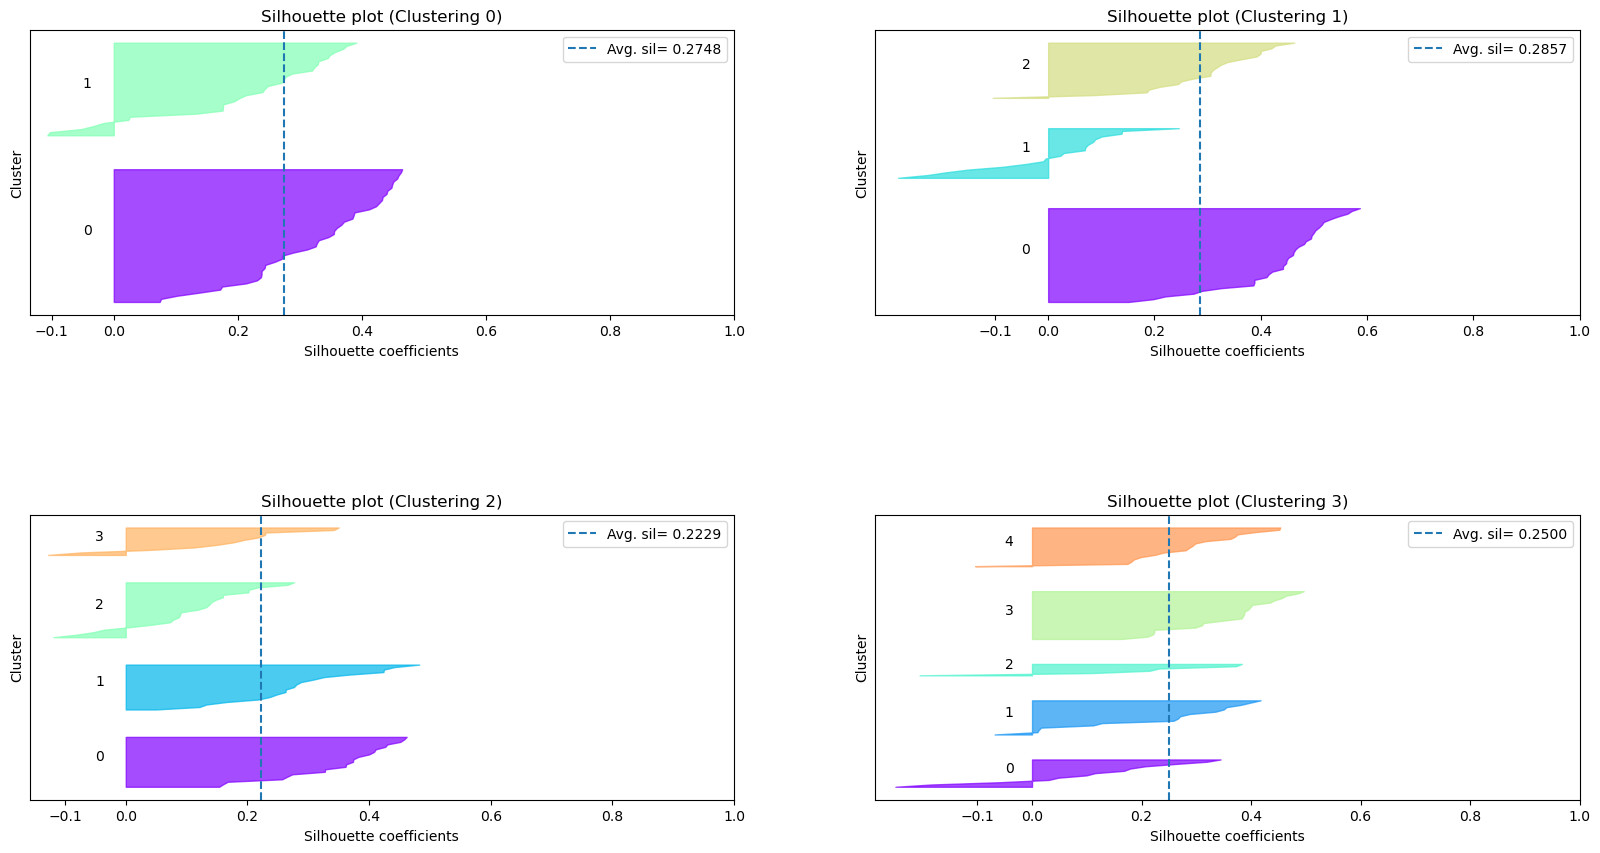

In [19]:
visualise_model_characteristics([vendor_norm]*len(fcm_clusters), fcm_res, ["sample_sil"])

The results here are worse compared to K-means, the average silhouette score is lower and there are more data points with a negative score at the sample level, we will however continue to analyse the data to see if we can find other interesting insights.  

In terms of characterisation, the same that we used above could be applied here in the second clustering, however here the difference between **big** and **small** is smaller.  
It seems more intersting to consider the simpler characterisation in the 1st clustering that distinguishes between **big** and **small**.

In [20]:
cmeans_final = fcm_res[0]

#Rough characterisation of the clusters in order to define a stable mapping between the cluster with the desired behaviour and a string label
#Needed because the cluster id could change after each run of the clustering algorithm
old_id_cmeans = cluster_id_resolver(vendor_norm, cmeans_final.labels_, \
                                       {"TotMonthBusiness": ">0.6"}, vendor_df_num.columns)
new_id_cmeans = cluster_id_resolver(vendor_norm, cmeans_final.labels_, \
                                         {"TotMonthBusiness": "<0.6"}, vendor_df_num.columns)

cluster_map_cmeans = {new_id_cmeans:"new", old_id_cmeans:"old"}

### External indices

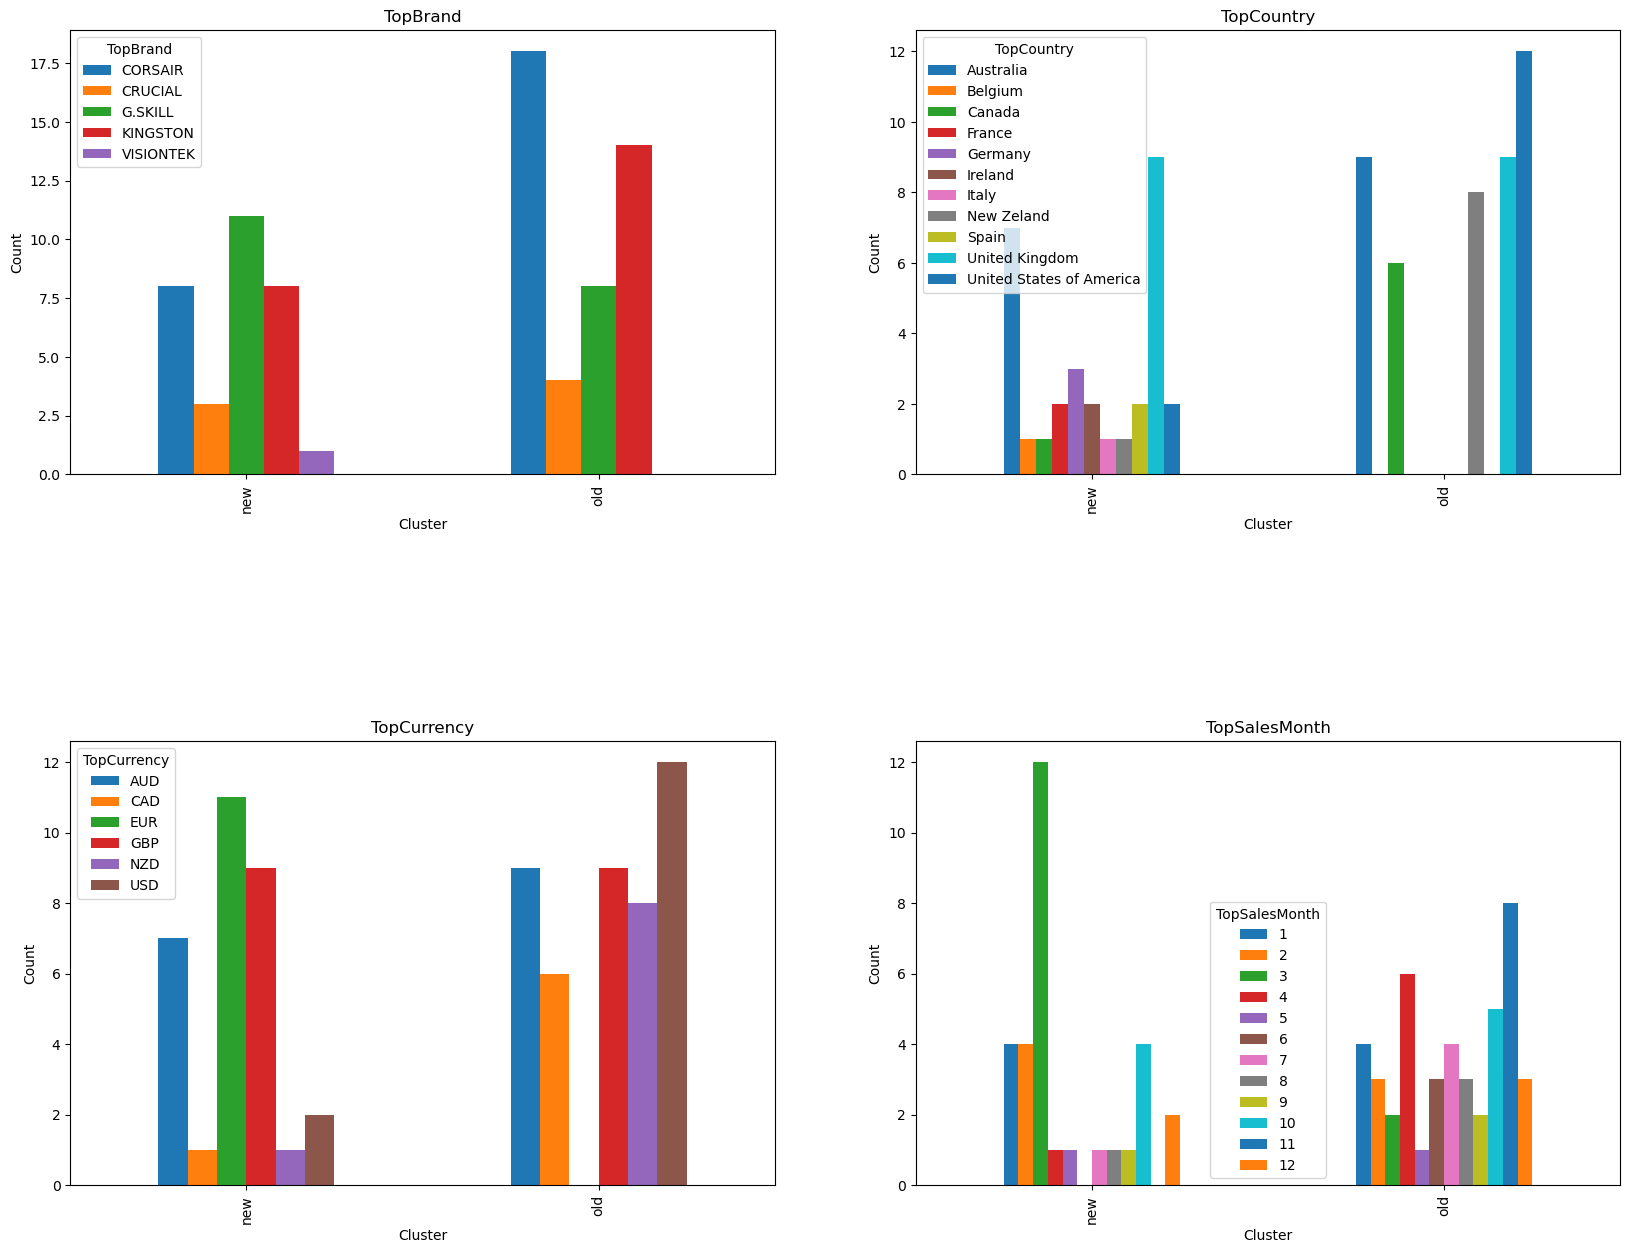

In [21]:
plot_categ_per_cluster(vendor_df_cat, cmeans_final, cluster_map_cmeans)

Insights:
- The EUR isn't a top currency for old vendors, however it is highly represented in the new vendors cluster
- The majority of vendors that have NZD, CAD and USD as top currencies belong to the old label
- The UK is the only european country that is a top grossing country of old vendors.
- New vendors are the majority of the vendors that have the highest revenue on the month of March, while the top months for the old label are more equally distributed

In [22]:
create_external_indices(vendor_df_cat, cmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.026321      0.052552     0.035075
1     TopCountry     0.104662      0.307943     0.156226
2    TopCurrency     0.119814      0.307943     0.172508
3  TopSalesMonth     0.080927      0.281608     0.125725

The scores here are higher than the k-mean case, however it is due to the lower amount of clusters.

## Protype-based evaluation

### K-means vs C-means

#### Internal indices

              Num. clusters               Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                     
0                         2                     [{0: 50, 1: 25}]                       0  24.985524        0.301923       1.381884
1                         3               [{0: 44, 1: 24, 2: 7}]                       0  19.604555        0.326206       1.222483
2                         4        [{0: 18, 1: 6, 2: 13, 3: 38}]                       0  15.571788        0.330955       1.144719
3                         5  [{0: 20, 1: 9, 2: 6, 3: 30, 4: 10}]                       0   13.29226         0.30787       1.055525


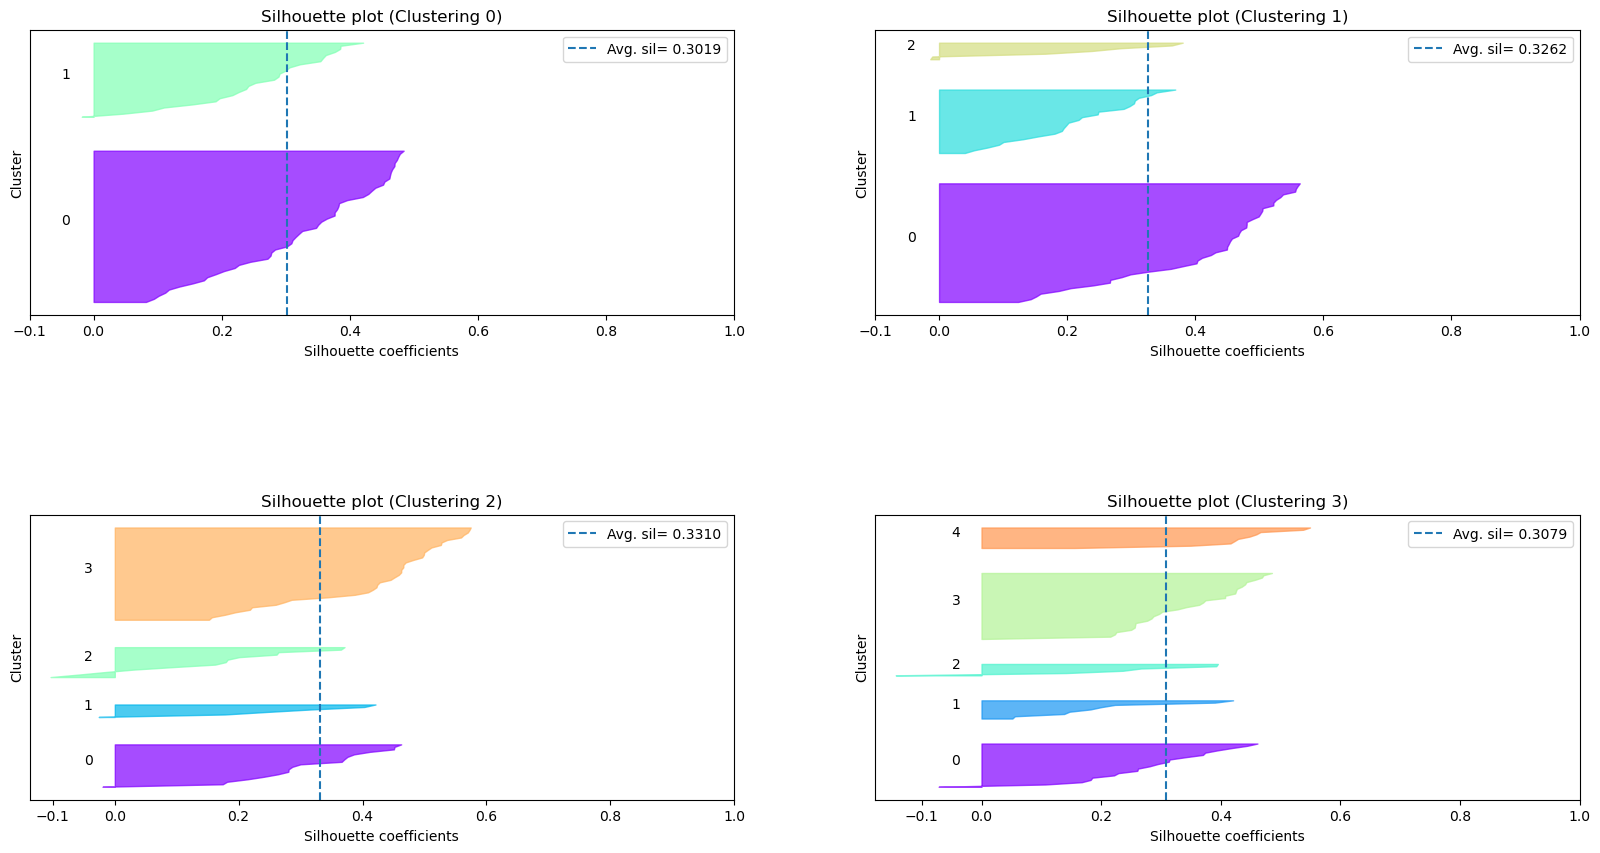

In [23]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res, ["general", "sample_sil"])

              Num. clusters                Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                      
0                         2                      [{0: 44, 1: 31}]                       0  25.207743        0.274823       1.464526
1                         3               [{0: 35, 1: 19, 2: 21}]                       0  20.075618        0.285702       1.411721
2                         4        [{0: 21, 1: 19, 2: 23, 3: 12}]                       0   17.58426        0.222916       1.387027
3                         5  [{0: 13, 1: 16, 2: 6, 3: 22, 4: 18}]                       0  13.528836        0.249969       1.213497


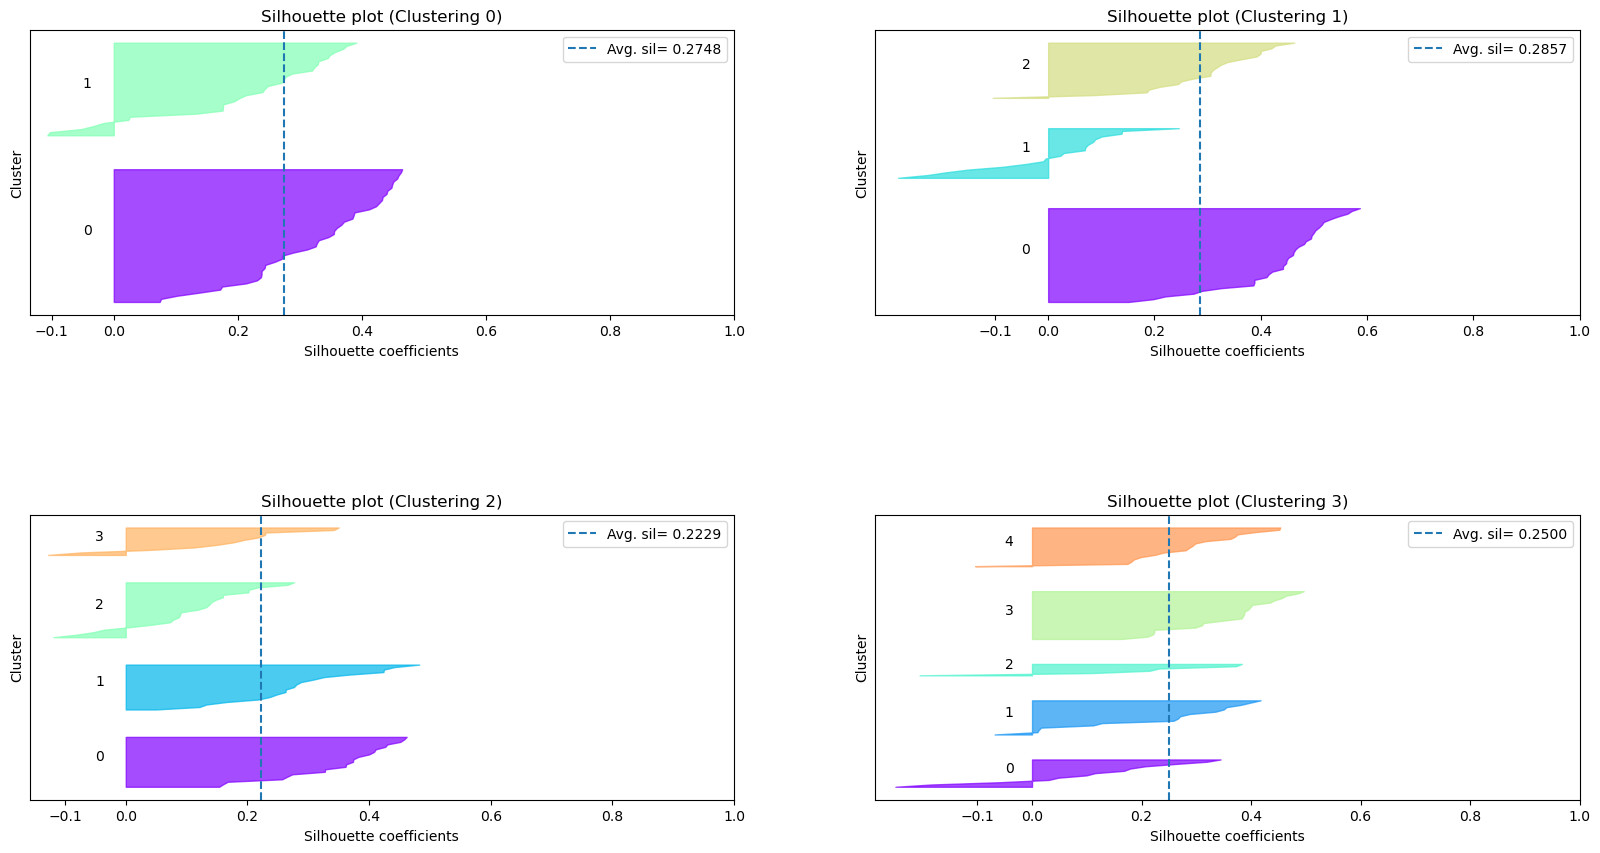

In [24]:
visualise_model_characteristics([vendor_norm]*len(fcm_clusters), fcm_res, ["general", "sample_sil"])

If we ignore the characterisations used and focus only on the internal metrics and compare clusterings with the same number of clusters we can see that c-means internal metrics are generally worse, in particular it produces clusters containing more datapoints with a negative sample silhouette score.

#### External indices
In order to compare the external indices we first need to reduce the old-small/old-big/new-small labels to old/new.

In [25]:
kmeans_new_labels_dict = {old_big_id_kmeans: old_id_cmeans, old_small_id_kmeans: old_id_cmeans, new_small_id_kmeans:new_id_cmeans}

new_labels = remap_clust_labels(kmeans_final.labels_, kmeans_new_labels_dict)
merged_kmeans_final = wrapper_sk(new_labels)
merged_cluster_map_kmeans = cluster_map_cmeans

In [26]:
create_external_indices(vendor_df_cat, merged_kmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.023309      0.050337     0.031864
1     TopCountry     0.055328      0.176080     0.084199
2    TopCurrency     0.043995      0.122307     0.064712
3  TopSalesMonth     0.078627      0.295939     0.124244

In [27]:
create_external_indices(vendor_df_cat, cmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.026321      0.052552     0.035075
1     TopCountry     0.104662      0.307943     0.156226
2    TopCurrency     0.119814      0.307943     0.172508
3  TopSalesMonth     0.080927      0.281608     0.125725

The results are very similar for the most part, however the completeness score and mutual info is higher for the c-means clustering.  
This indicates that TopCountry and TopCurrency labels tend to concentrate on the same clusters and therefore there is a stronger association between label value and cluster (ie the majority vendors that have Corsair as a TopBrand get assigned an "old" label).

#### Insights comparison  
We think that it is a good (informal) qualitative indicator to check that the insights that we gathered above hold across clusterings, of course this can be done only when the insights depend on shared characterisations (old/new).

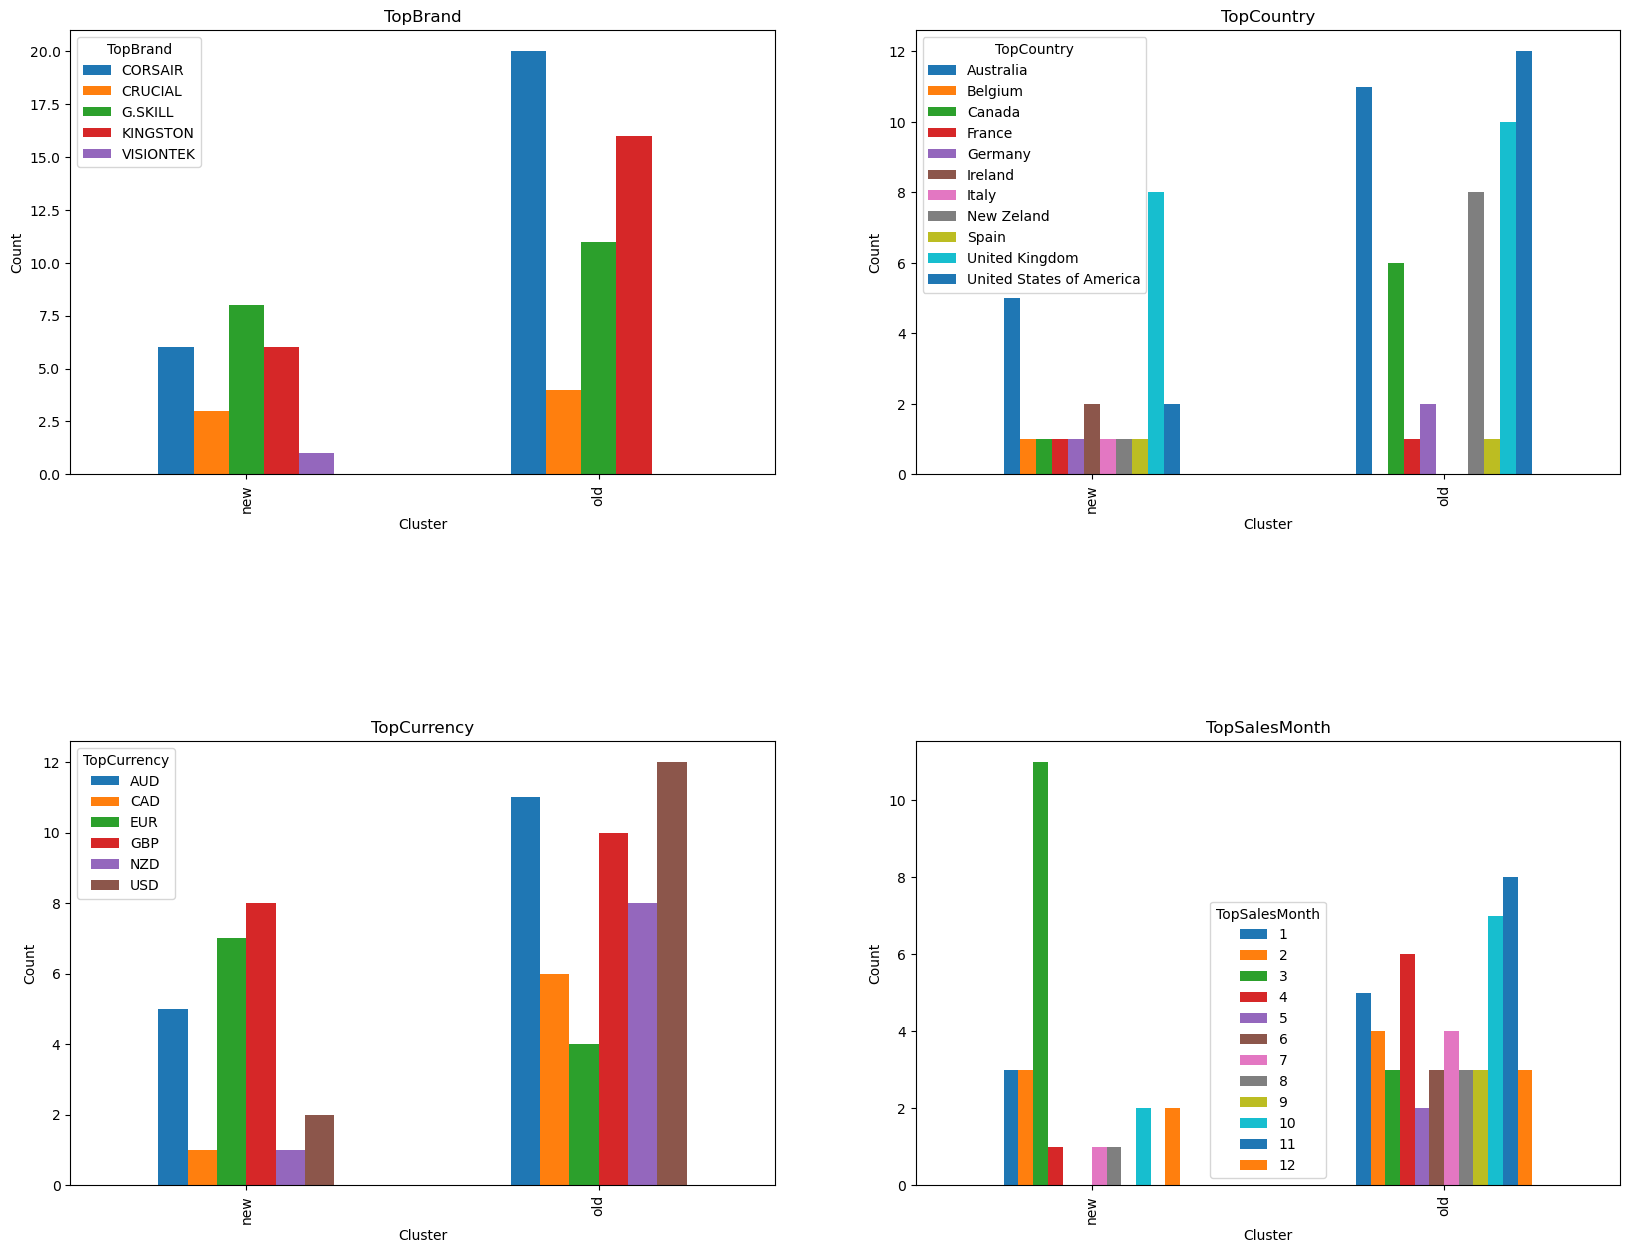

In [28]:
plot_categ_per_cluster(vendor_df_cat, merged_kmeans_final, merged_cluster_map_kmeans)

Here we compare the insights obtained from c-means and see if they hold for the distribution of categorical features in k-means:
- The EUR isn't a top currency for old vendors, however it is highly represented in the new vendors cluster
    - **Doesn't hold**: we can see that there is a significant representation of EUR in old
- The majority of vendors that have NZD, CAD and USD as top currencies belong to the old label  
    - **Holds**
- The UK is the only european country that is a top grossing country of old vendors 
    - **Somewhat holds**: Germany, Spain and France are represented in the old-small/old-big labels, however their numbers are much lower than the UK
- New vendors are the majority of the vendors that have the highest revenue on the month of March, while the top months for the old label are more equally distributed
    - **Holds**

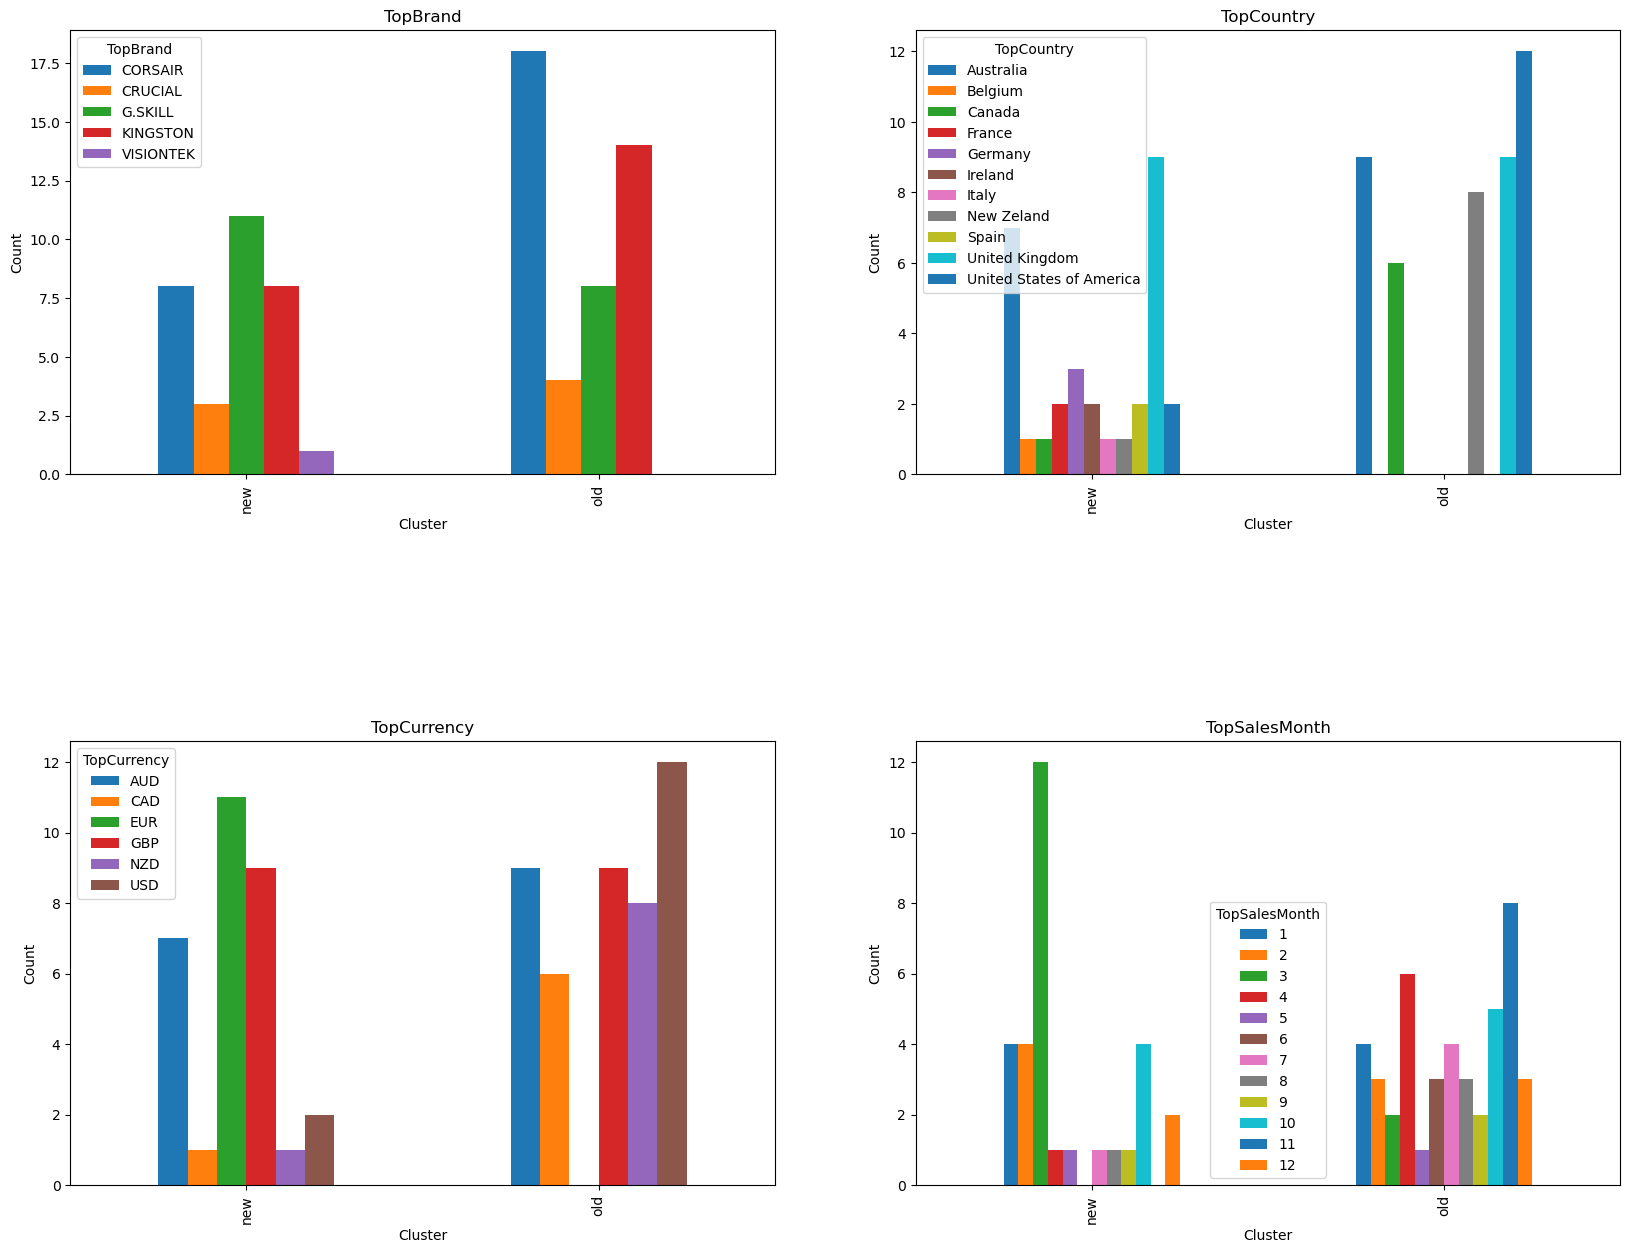

In [29]:
plot_categ_per_cluster(vendor_df_cat, cmeans_final, cluster_map_cmeans)

Here we compare the insights obtained from k-means and see if they hold for the distribution of categorical features in c-means:
- The european currencies (EUR, GBP) represent the majority of top currencies for new-small/old-small
    - **Not applicable**: these labels ignore vendor size
- The USD is concentrated mostly in the old-small label
    - **Holds**: the old label contains the majority of top USD vendors
- The vast majority of new-small's sales take place in the month of March
    - **Holds**
- The vast majority of the vendors are classified as small
    - **Not applicable**

### Conclusions

The results obtained from these techniques are very similar and the characterisations share some insights, if we had to pick one we would choose k-means given that it gave us more freedom in choosing the labels.

## Task 2.2: Density-based clustering

### Determine optimal eps and minSamples

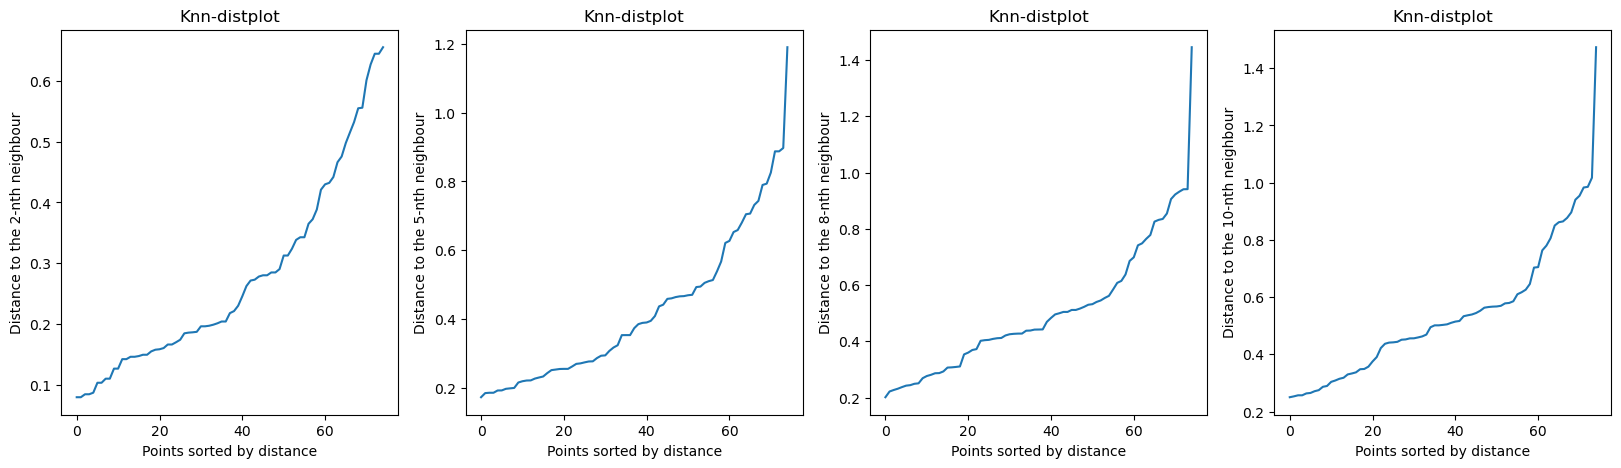

In [30]:
n_neigh = [2, 5, 8, 10]
plot_knn_dist(n_neigh, [vendor_norm]*len(n_neigh))

The "knee" in this case is not really smooth, due to the low number of datapoints in the dataset, making it harder to find an optimal value for minSamples.  
The plots suggest that an optimal value for the eps parameter is in the range [0.2, 0.8] for the minSamples values considered.  

Given the low amount of data points and the lack of significant change in the plot we will settle for a minSamples value of 5.

### DBSCAN

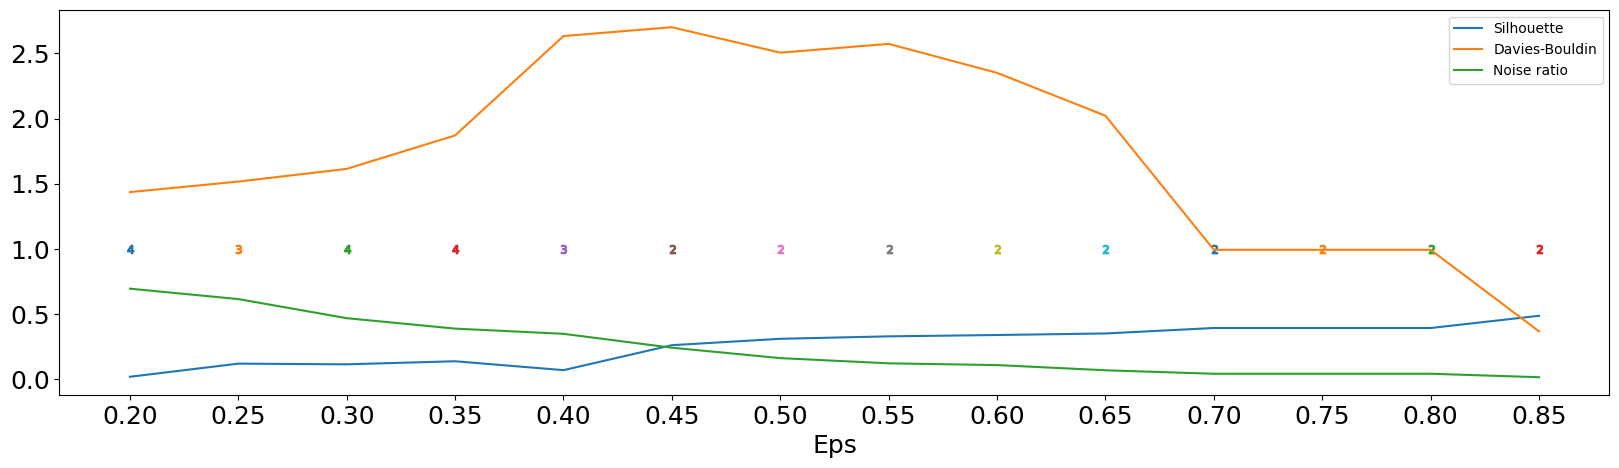

In [31]:
plot_metrics_per_eps(vendor_norm, ["sil", "db", "noise_ratio", "clusters"], precision=0.05, model_sk=DBSCAN(min_samples = 5, eps = 1))

Apart from the usual metrics we also introduced a simple ratio of noise datapoints to non-noise ones and the number of clusters per eps change, just to get an idea of the behaviour of the DBSCAN algorithm.

              Num. clusters   Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                         
0                         3  [{-1: 26, 0: 41, 1: 8}]                       0   29.75732        0.067679       2.633271
1                         2        [{-1: 12, 0: 63}]                       0  31.164668        0.308345        2.50549
2                         2         [{-1: 8, 0: 67}]                       0  31.653632        0.337526       2.350626
3                         2         [{-1: 3, 0: 72}]                       0  30.620601        0.391204       0.991674


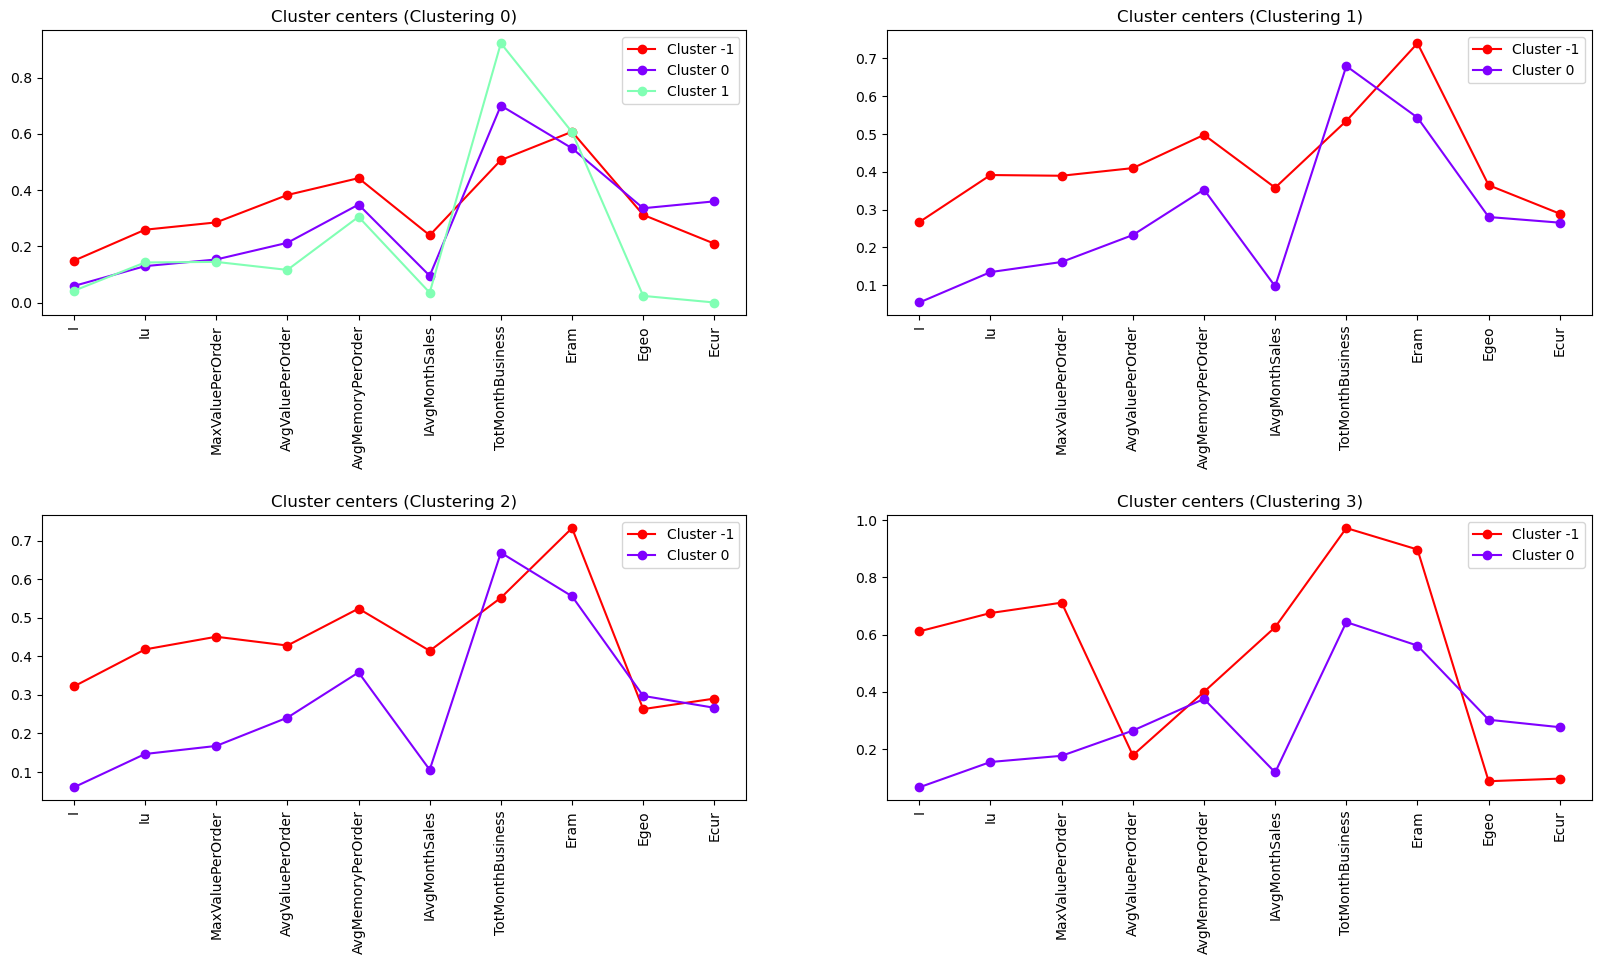

In [32]:
dbscan_res = []

for i in np.arange(0.4, 0.8, 0.10):
    dbscan_res.append(DBSCAN(min_samples = 5, eps = i).fit(vendor_norm))

visualise_model_characteristics([vendor_norm]*len(dbscan_res), dbscan_res)

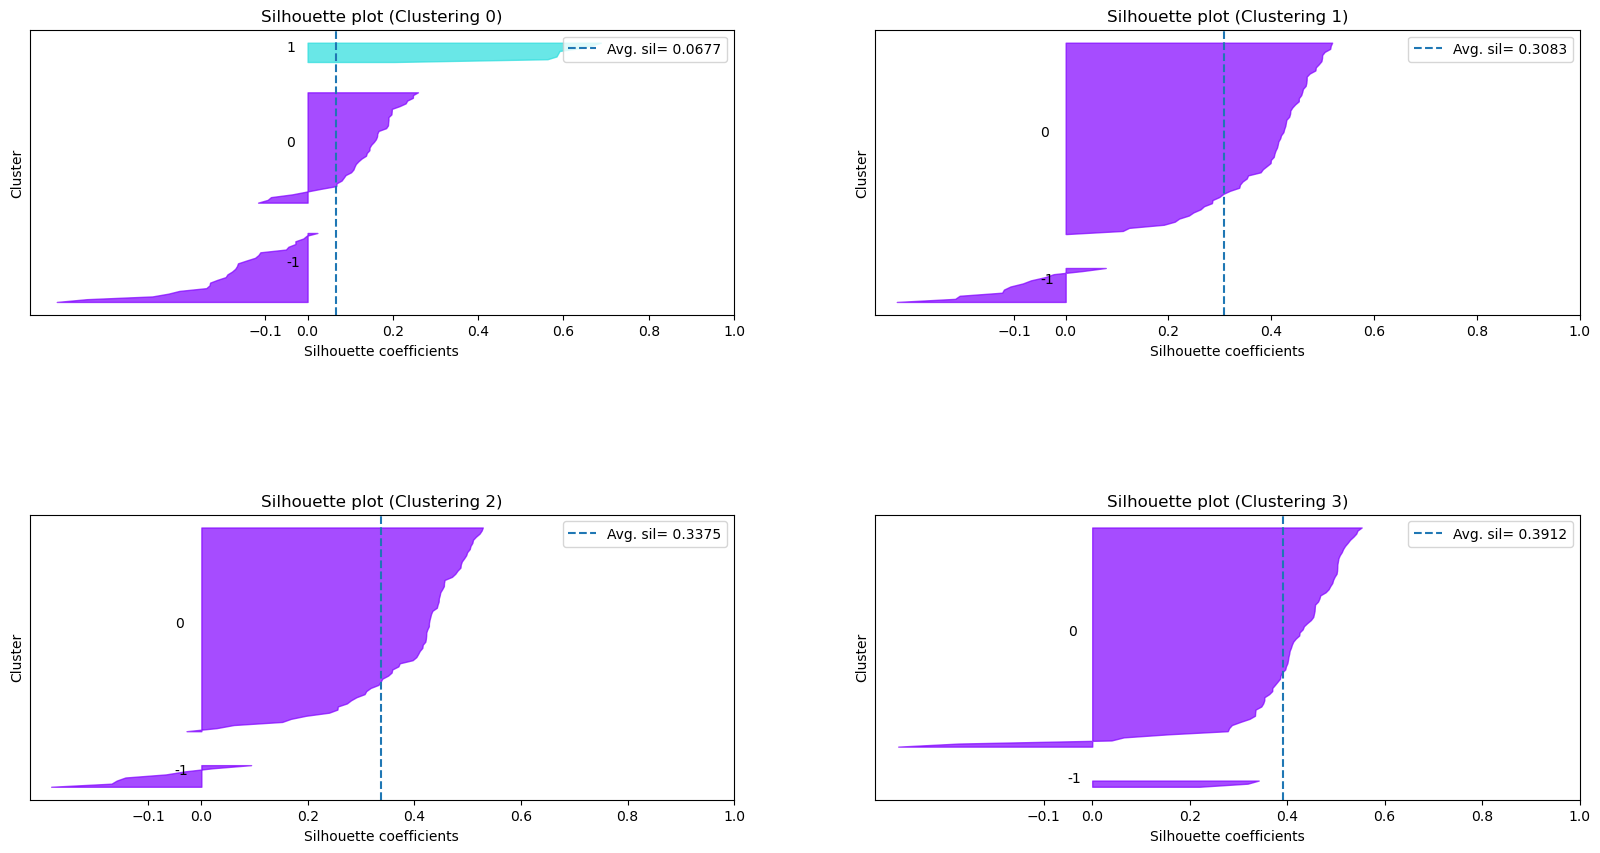

In [33]:
visualise_model_characteristics([vendor_norm]*len(dbscan_res), dbscan_res, ["sample_sil"])

Here we can see a different characterisation from the prototype-based clustering, we can assign labels based on the sales (IAvgSalesMonth) and volume of sales (I/Iu) based on the 2nd clustering: **big** (0) and **small** (1) vendors.  

We chose the 2nd clustering because the clusters are distinct enough (difference between the averages of the characterising features ~0.2)  and because it has an higher number of points in the noise cluster while the overall behaviour of the plot is the same as the 3rd/4th clustering.  
The 1st clustering wasn't considered due to the poor silhouette score.

In [34]:
dbscan_final = dbscan_res[1]

cluster_map_dbscan = {-1:"big", 0:"small"}

### External indices

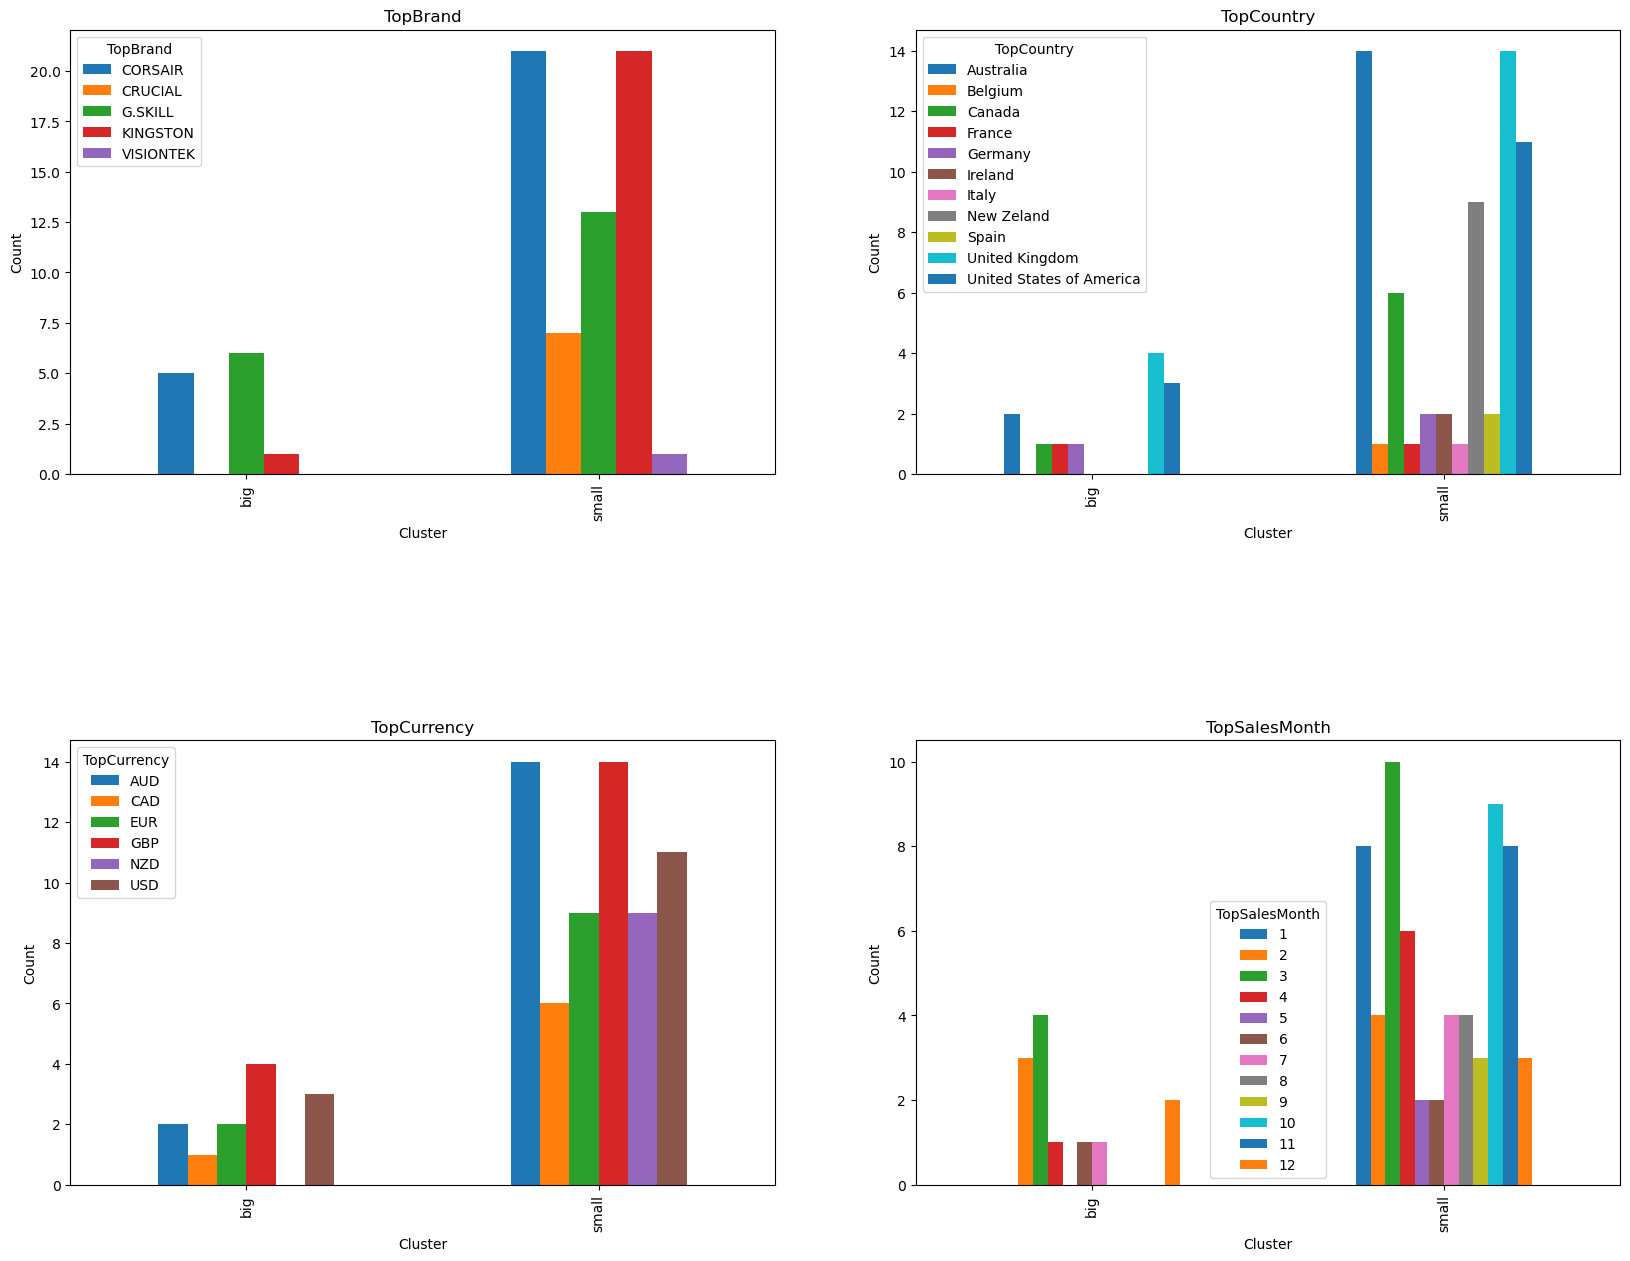

In [35]:
plot_categ_per_cluster(vendor_df_cat, dbscan_final, cluster_map_dbscan)

Insights:
- Crucial is not a top grossing brand for big vendors
- Big vendors seem to have the majority of their profits in the months of February and March
- New Zealand is not a top grossing country for any big vendor, which is to be expected given the size of the country's economy compared to the others

In [36]:
create_external_indices(vendor_df_cat, dbscan_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.042641      0.131295     0.064375
1     TopCountry     0.026543      0.120437     0.043499
2    TopCurrency     0.015698      0.062221     0.025070
3  TopSalesMonth     0.051830      0.278138     0.087377

### Conclusions
DBSCAN clusterings aren't too promising according to the internal metrics.  
Later we will compare the results in this section with the other clusterings obtained with different algorithms.

## Task 2.3: Hierarchical clustering (Agglomerative)

## Single linkage

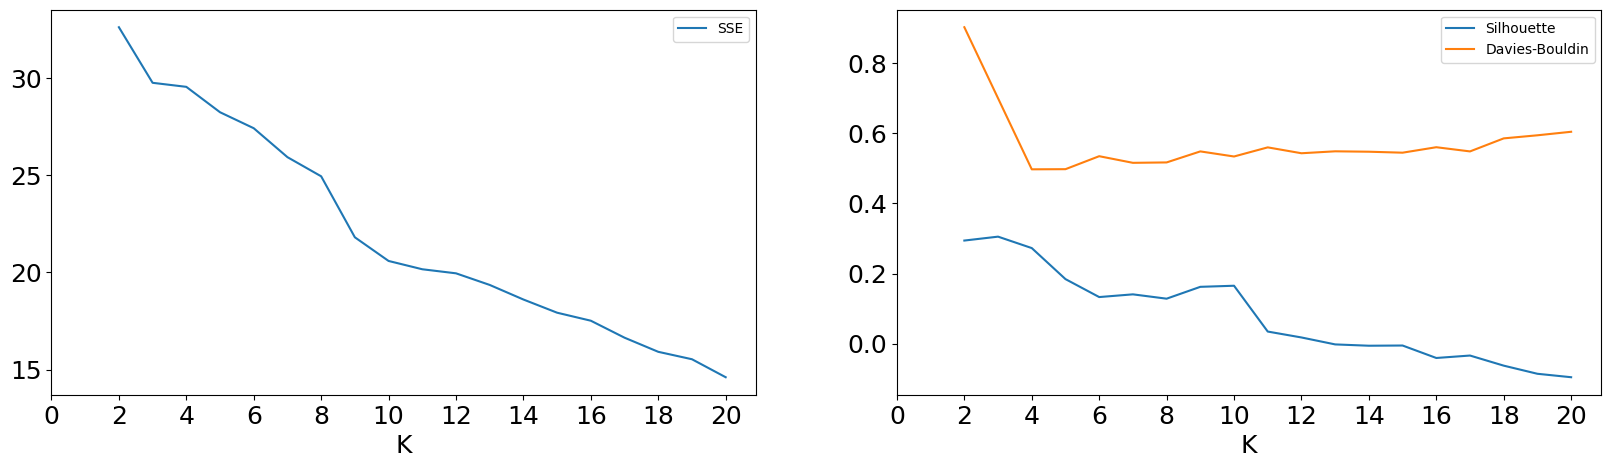

In [37]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

Cophenetic coefficient: 0.6766931839188972


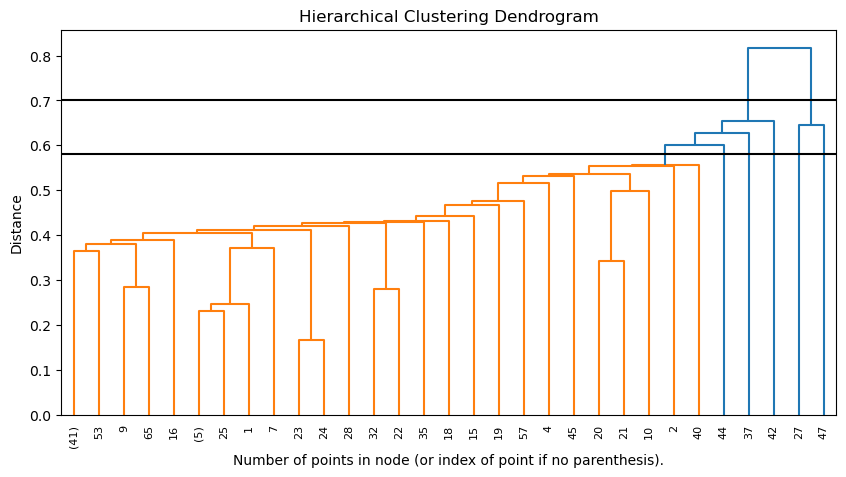

              Num. clusters                   Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                         
0                         2                          [{0: 73, 1: 2}]                       0  32.608542         0.29414       0.903062
1                         6  [{0: 70, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}]                       5  27.415358        0.132836       0.534907


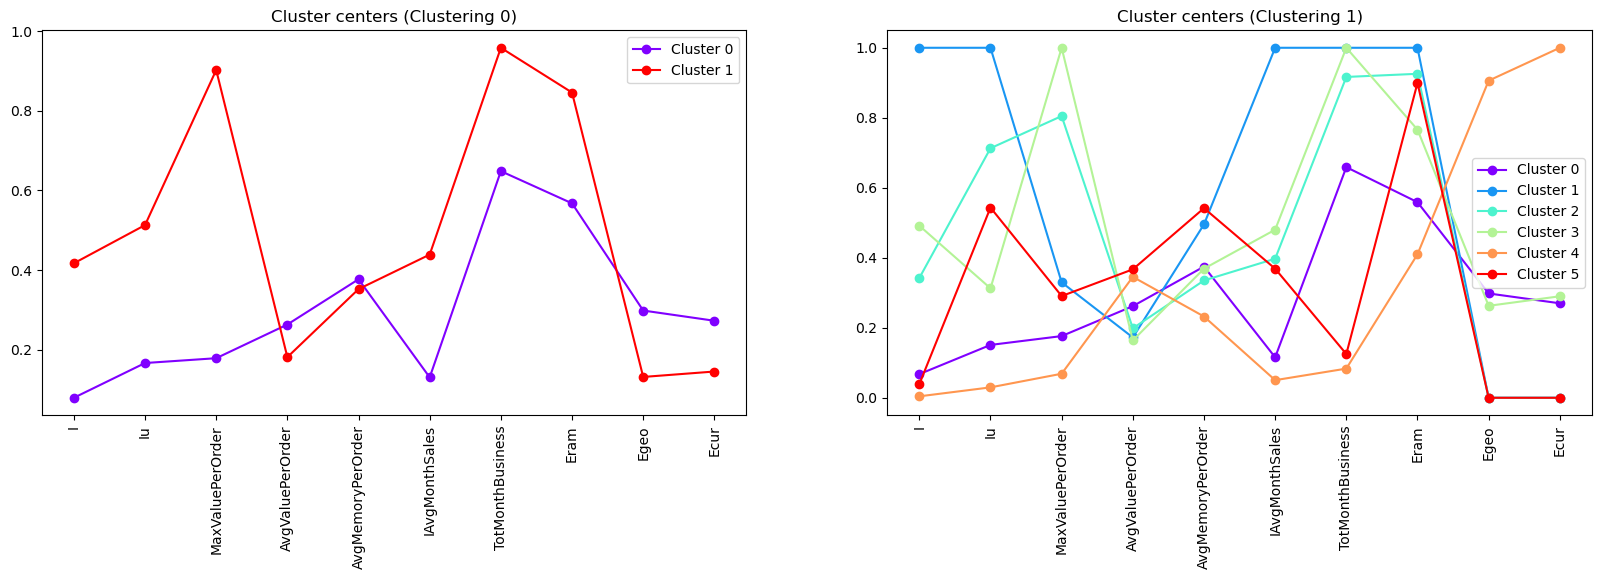

In [38]:
max_d = [0.7, 0.58]

hier_clustering_single_res = []

for i in max_d:
    hier_clustering_single_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="single").fit(vendor_norm))

Z = linkage(vendor_norm, 'single')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_single_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_single_res), hier_clustering_single_res)

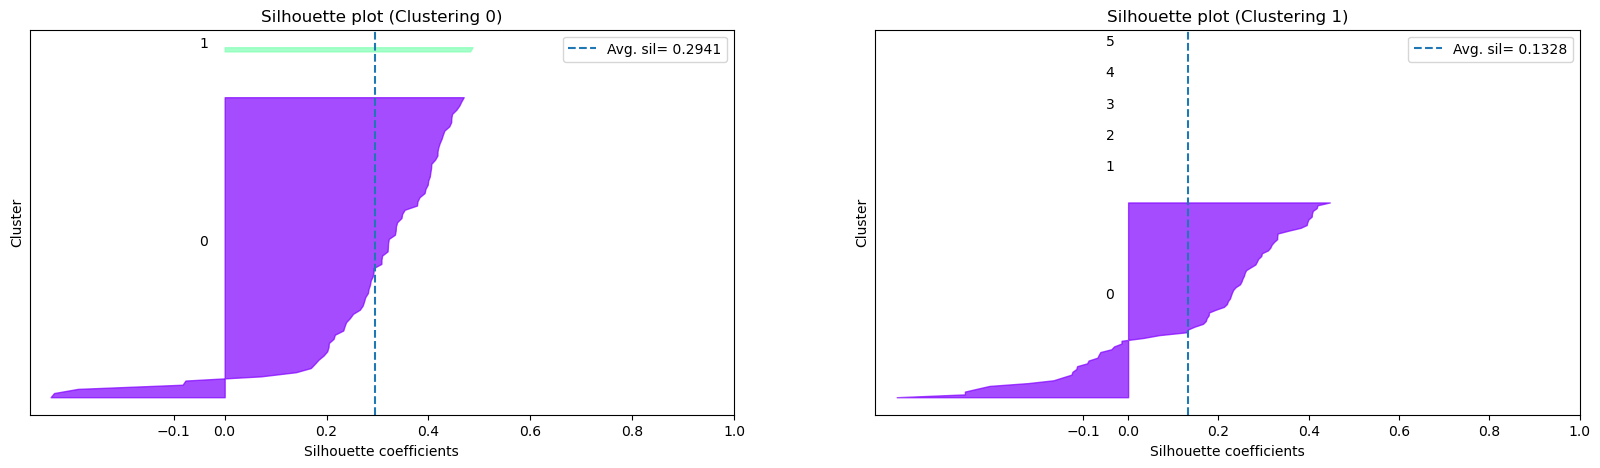

In [39]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_single_res), hier_clustering_single_res, ["sample_sil"])

## Post processing  
In order to get a better idea we will merge the single points into a single "noise" cluster similarly to DBSCAN, otherwise the comparison is not doable.

In [40]:
post_labels = hier_clustering_single_res[1].labels_

new_labels_dict = group_singleton_clusters(post_labels)
new_labels = remap_clust_labels(post_labels, new_labels_dict)
        
single_final = wrapper_sk(new_labels)
single_final.set_params(**{"linkage":"single"})

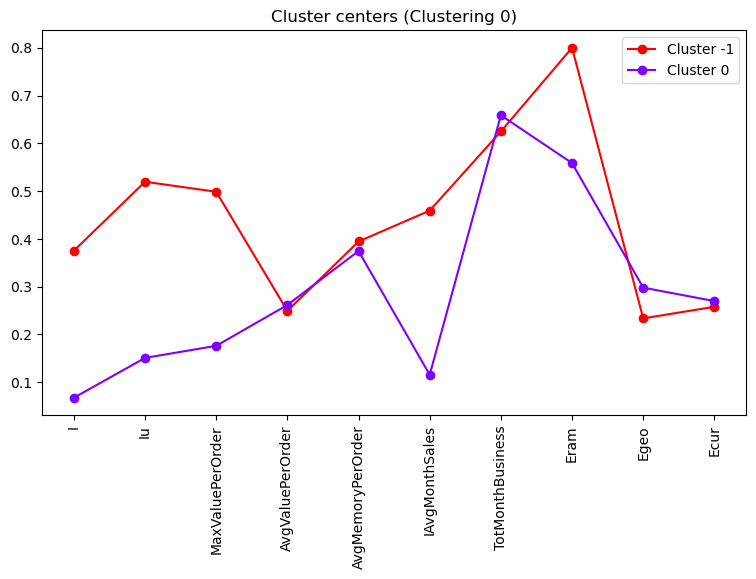

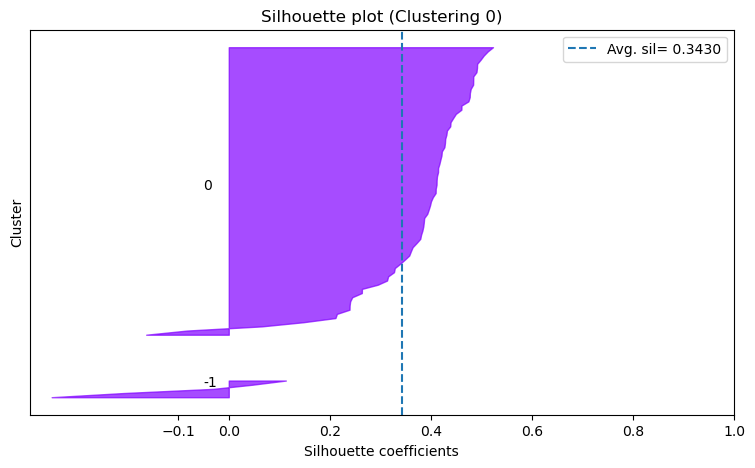

In [41]:
visualise_model_characteristics([vendor_norm], [single_final], ["avg", "sample_sil"])

The average silhouette score is more promising here compared to the first clustering.  
Again we see a **big**/**small** classification, with a greater emphasis on the average monthly revenue compared to DBSCAN.

In [42]:
cluster_map_single = {0:"small", -1:"big"}

### External indices

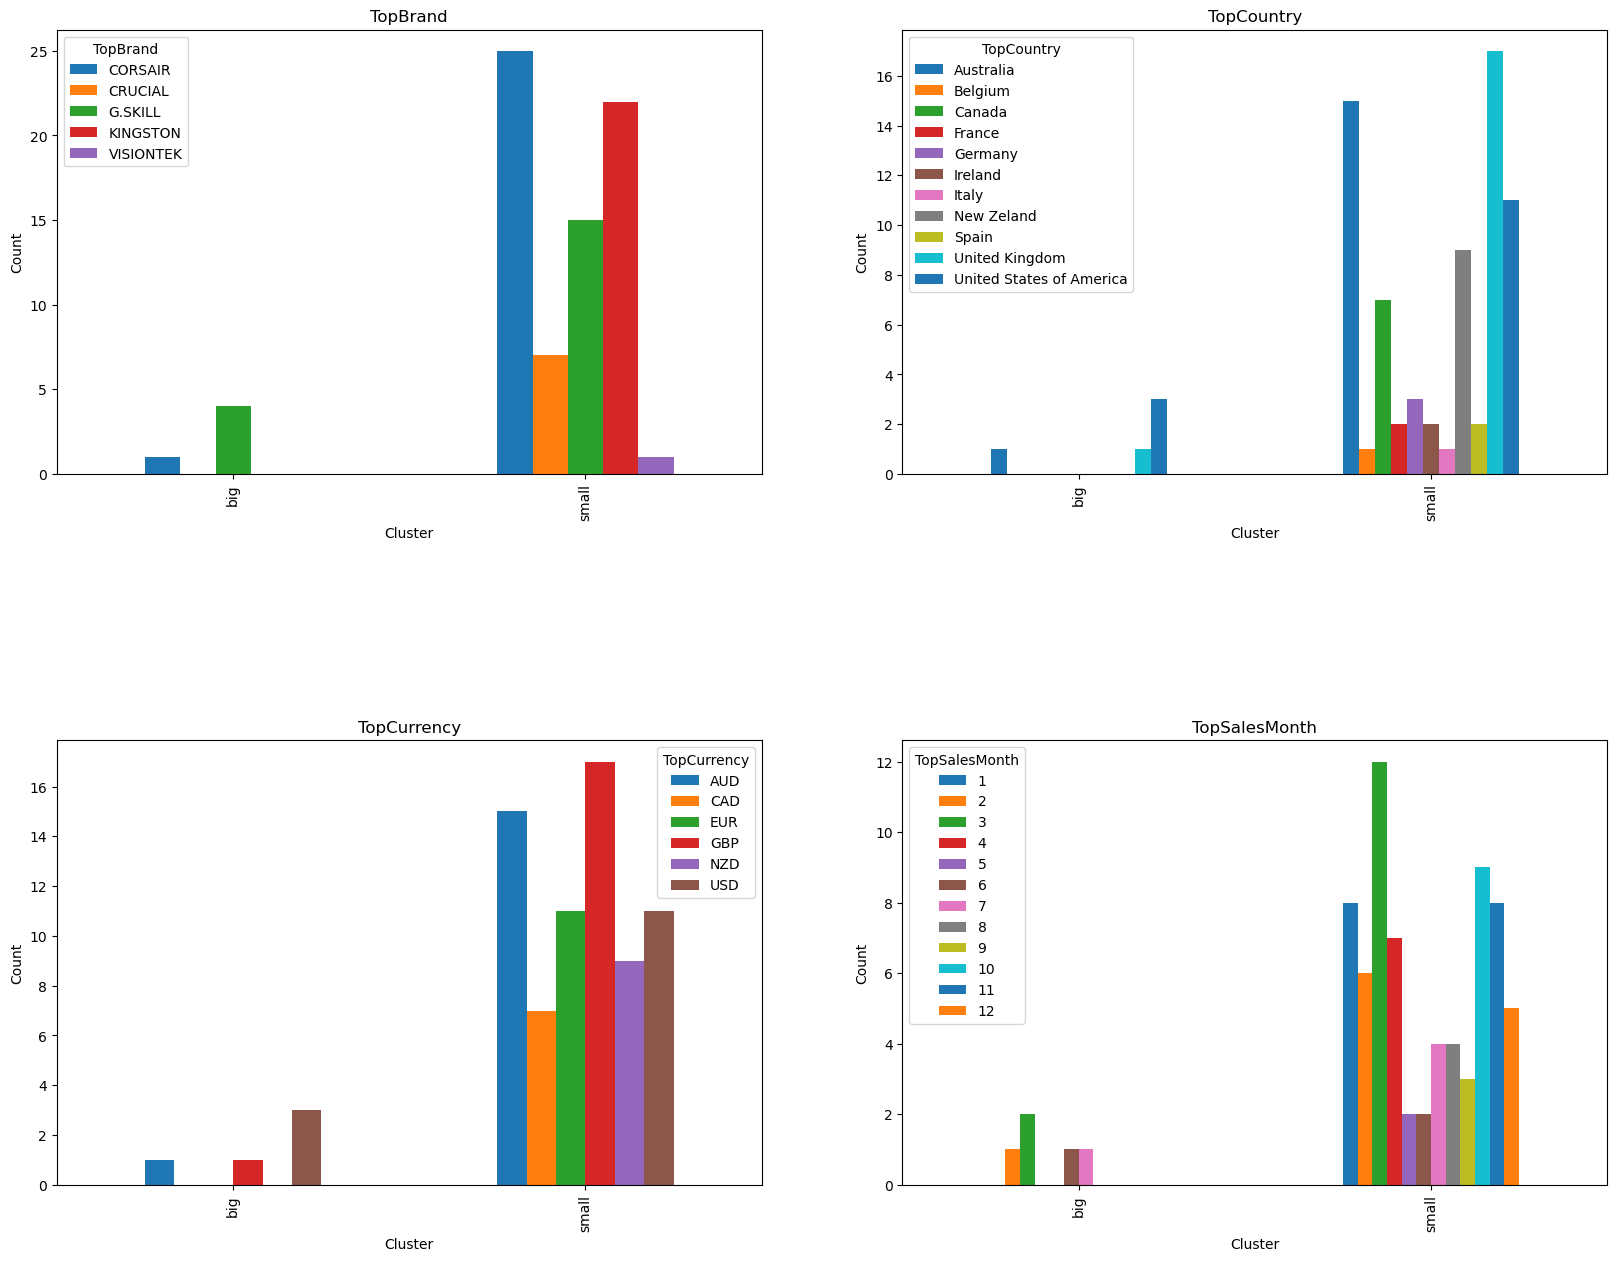

In [43]:
plot_categ_per_cluster(vendor_df_cat, single_final, cluster_map_single)

In [44]:
create_external_indices(vendor_df_cat, single_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.042870      0.236951     0.072605
1     TopCountry     0.023344      0.190144     0.041583
2    TopCurrency     0.026724      0.190144     0.046862
3  TopSalesMonth     0.030209      0.291009     0.054736

### Conclusion  
We can see from the dendogram, with single linkage, that the majority of the clusters, especially the top level ones, are formed by agglomerating a big cluster and a bunch of separate single points.  
Wherever we choose to cut we will have a few very big clusters and some small ones, it seems however that the post-processing that we applied improved at least the internal metrics.  
At the end of the hierarchical clustering section we will compare the results across linkages.

## Complete linkage

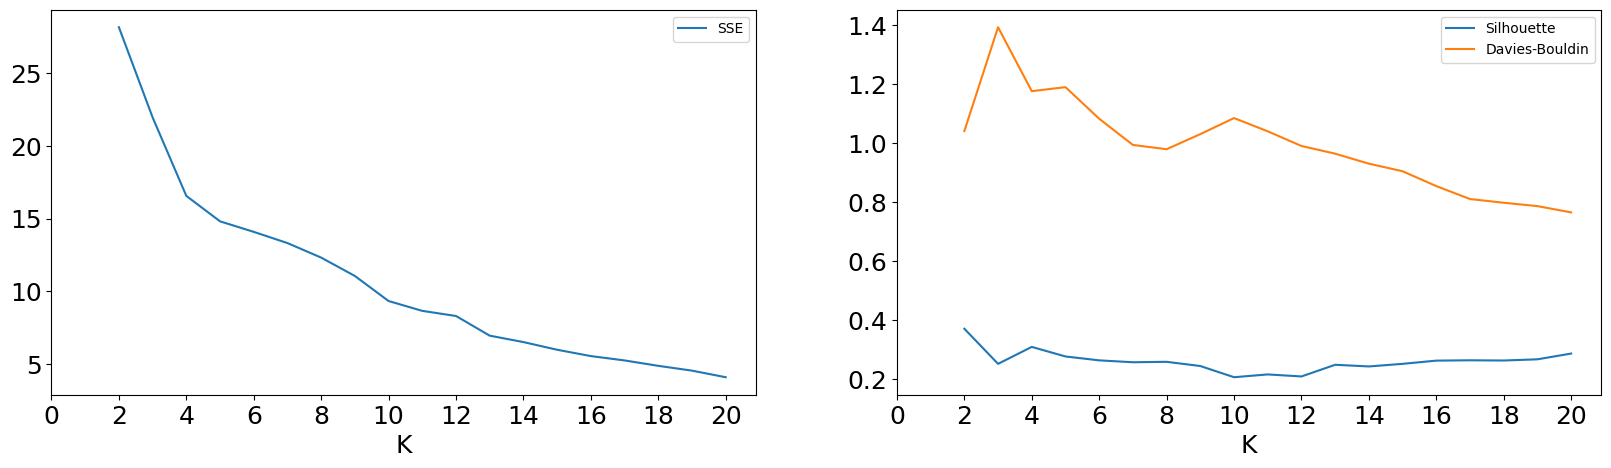

In [45]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

Cophenetic coefficient: 0.7242478526838101


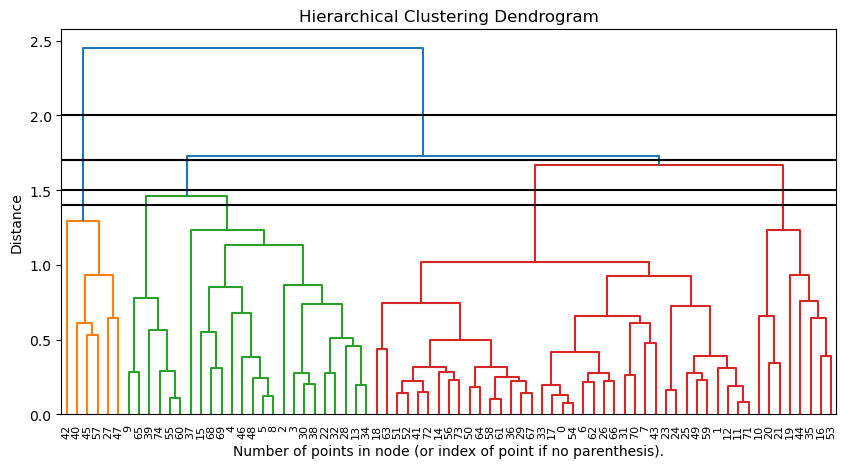

              Num. clusters              Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         2                     [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         3              [{0: 45, 1: 6, 2: 24}]                       0  21.962575        0.250721       1.392849
2                         4        [{0: 24, 1: 6, 2: 8, 3: 37}]                       0  16.568995        0.308216       1.175836
3                         5  [{0: 6, 1: 18, 2: 8, 3: 37, 4: 6}]                       0  14.819445        0.275727       1.189555


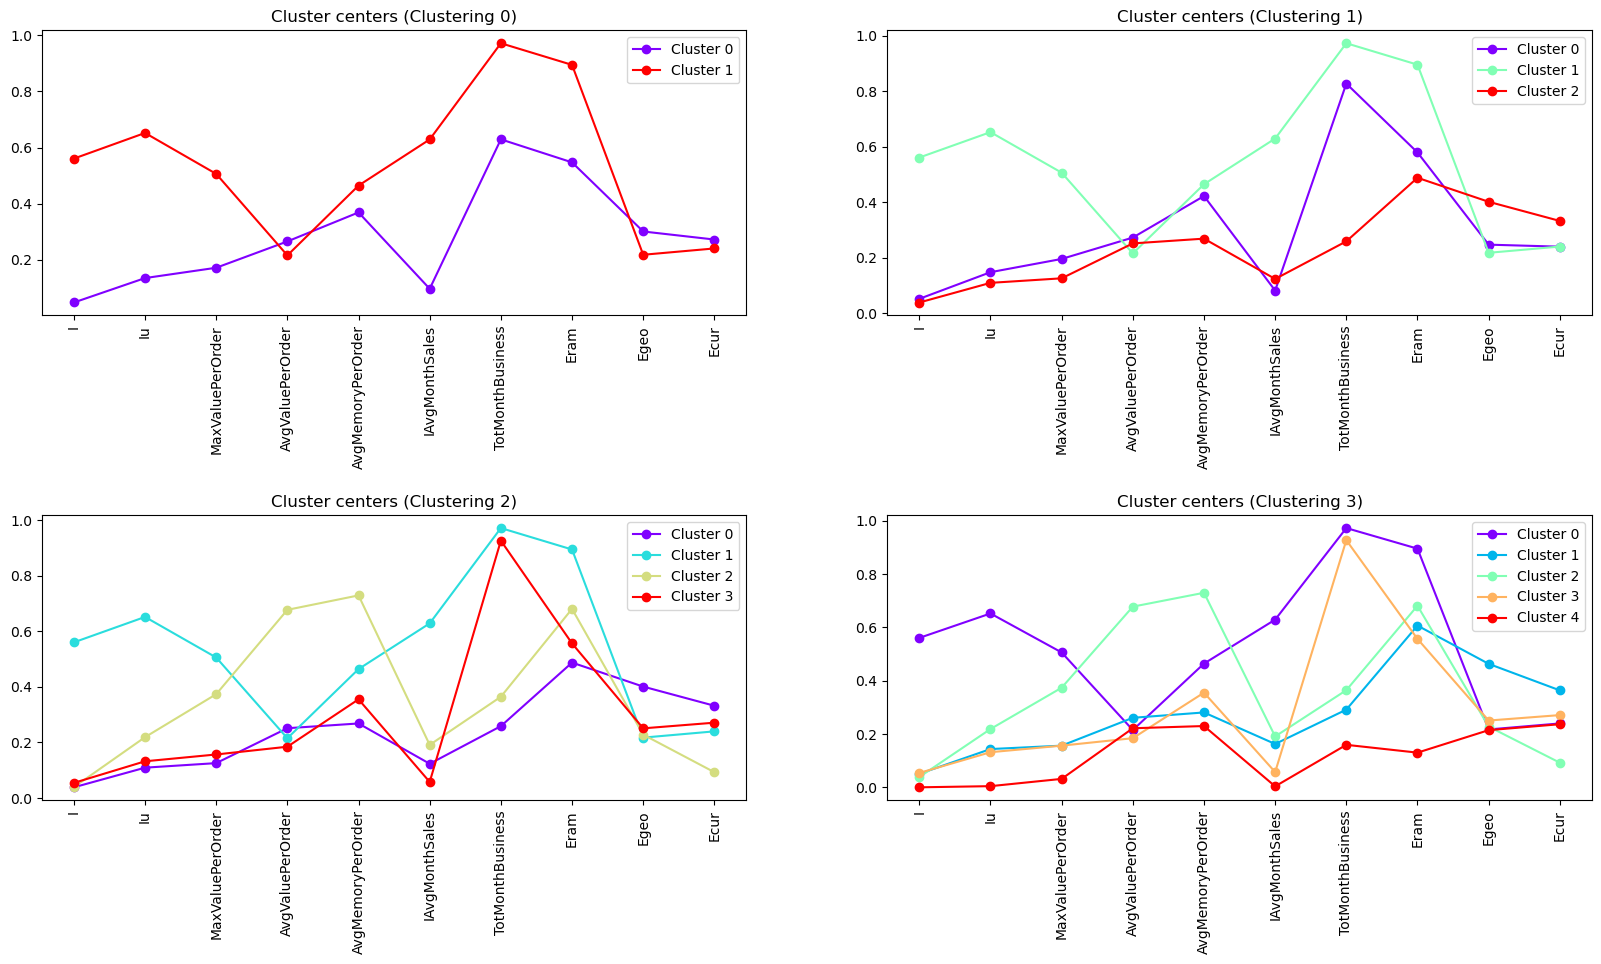

In [46]:
max_d = [2, 1.7, 1.5, 1.4]

hier_clustering_complete_res = []

for i in max_d:
    hier_clustering_complete_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="complete").fit(vendor_norm))

Z = linkage(vendor_norm, 'complete')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_complete_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_complete_res), hier_clustering_complete_res)

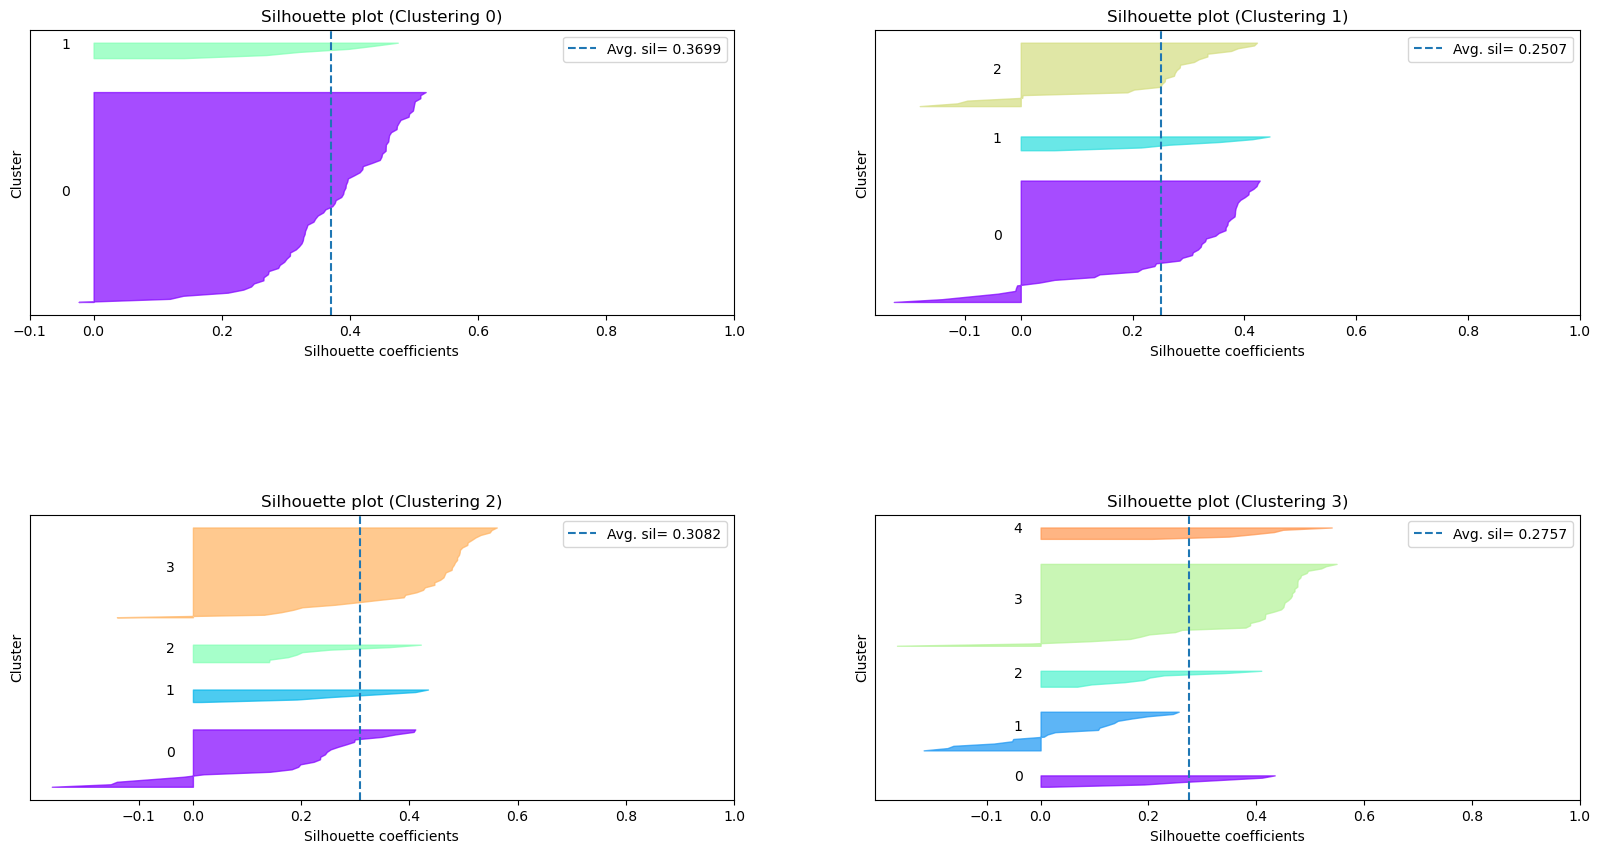

In [47]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_complete_res), hier_clustering_complete_res, ["sample_sil"])

Among the different clusterings the most promising seems to be the 2nd one, especially based on the cutting height in the dendogram.  
The clusters distinguishing features are again I/Iu/IAvgSalesMonth/TotMonthBusiness once again, further confirming that we are onto something.  
This corresponds to a **old-big/old-small/new-small** labeling, the same one used with k-means.

In [48]:
complete_final = hier_clustering_complete_res[1]

cluster_map_complete = {0:"old-small", 1:"old-big", 2:"new-small"}

### External indices

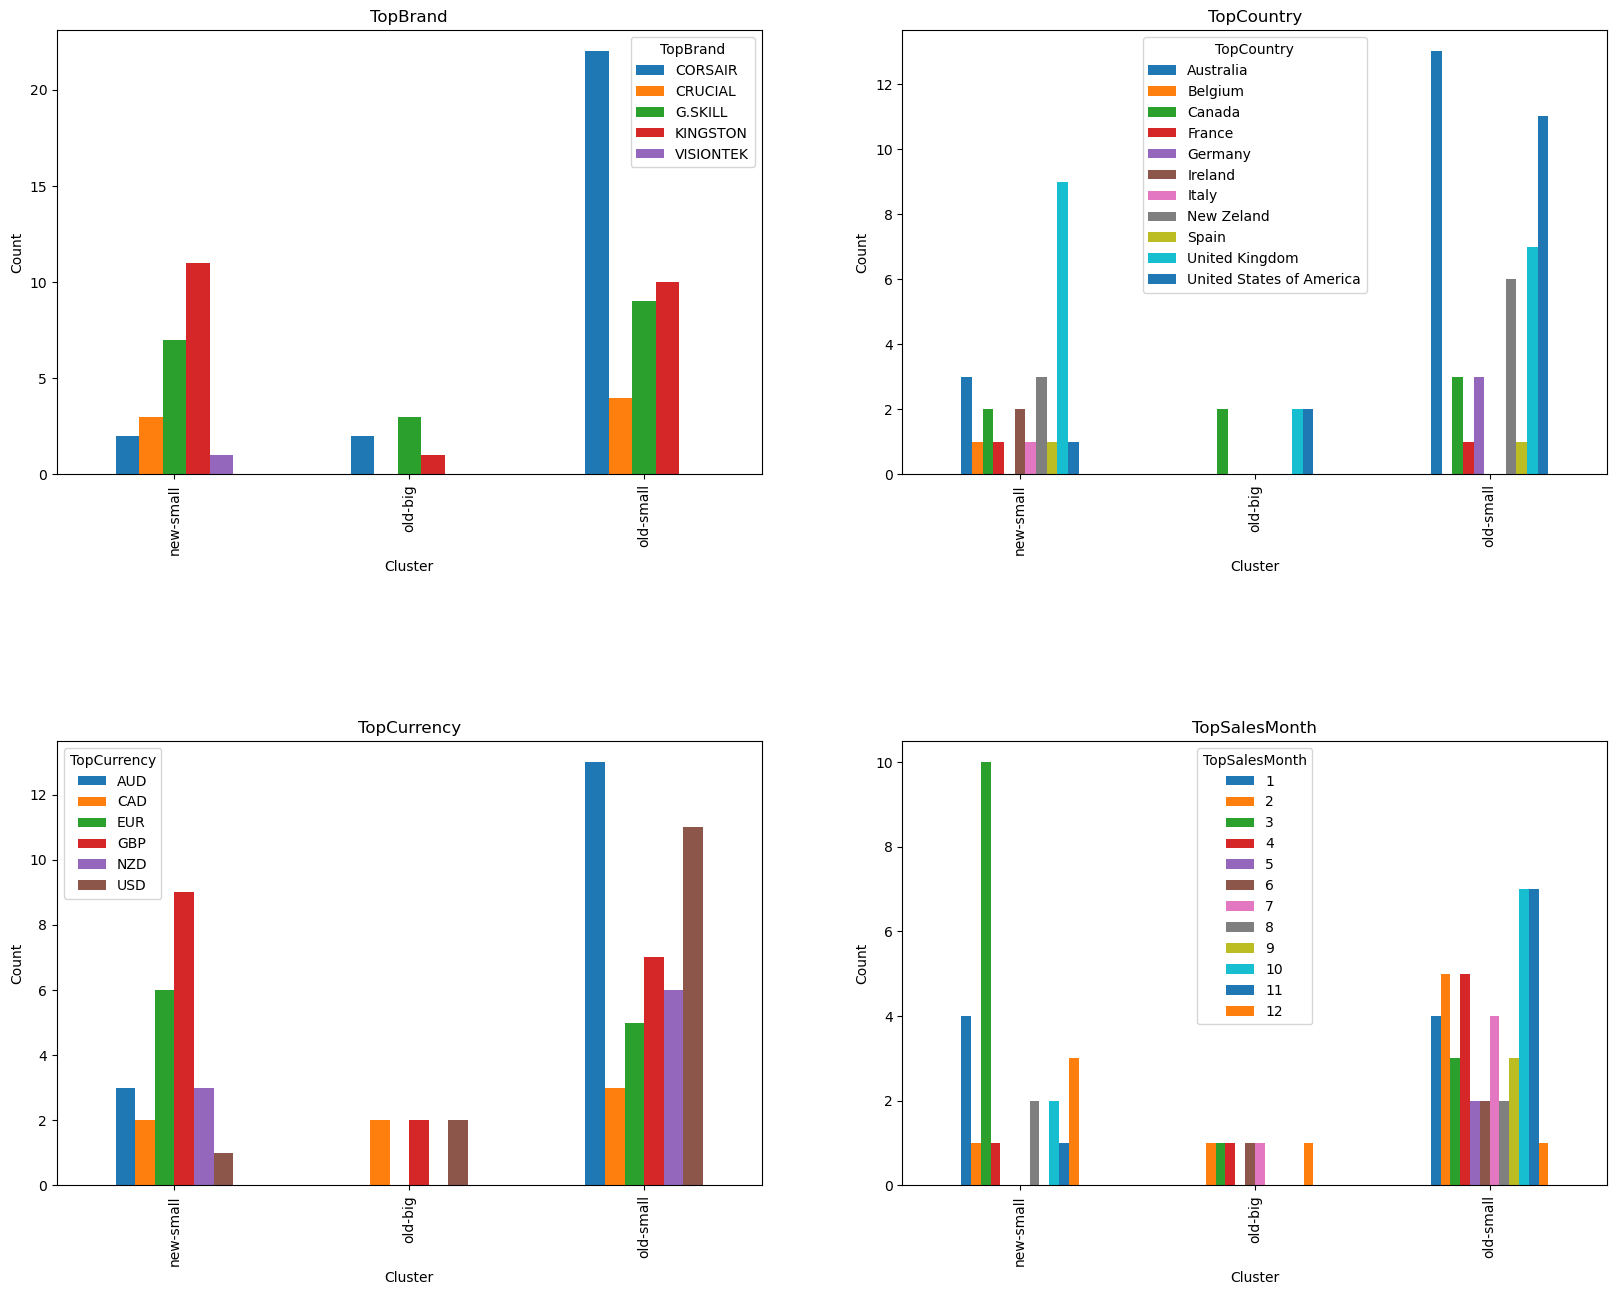

In [49]:
plot_categ_per_cluster(vendor_df_cat, complete_final, cluster_map_complete)

In [50]:
create_external_indices(vendor_df_cat, complete_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.087856      0.136212     0.106816
1     TopCountry     0.102154      0.233400     0.142110
2    TopCurrency     0.080169      0.160005     0.106818
3  TopSalesMonth     0.104275      0.281766     0.152217

Many of the insights from k-means also apply here.

#### Conclusion  
The results are again very close to the ones from the other algorithms.

### Average linkage

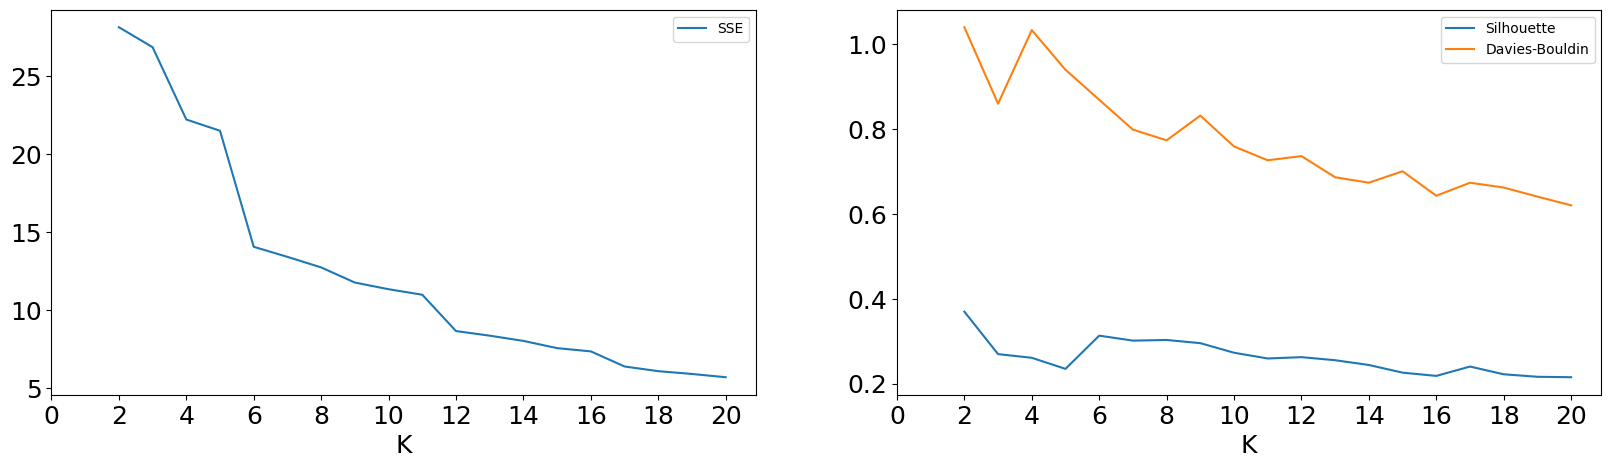

In [51]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

Cophenetic coefficient: 0.7902253226984014


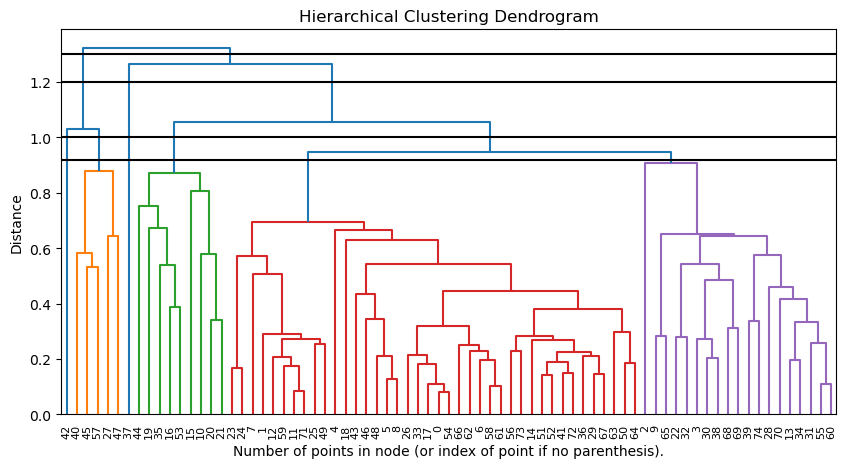

              Num. clusters                    Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                          
0                         2                           [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         3                     [{0: 68, 1: 6, 2: 1}]                       1  26.875245        0.269734        0.86024
2                         5         [{0: 59, 1: 5, 2: 1, 3: 9, 4: 1}]                       2  21.508558        0.234957       0.940245
3                         6  [{0: 19, 1: 5, 2: 40, 3: 9, 4: 1, 5: 1}]                       2  14.057999        0.313247       0.869515


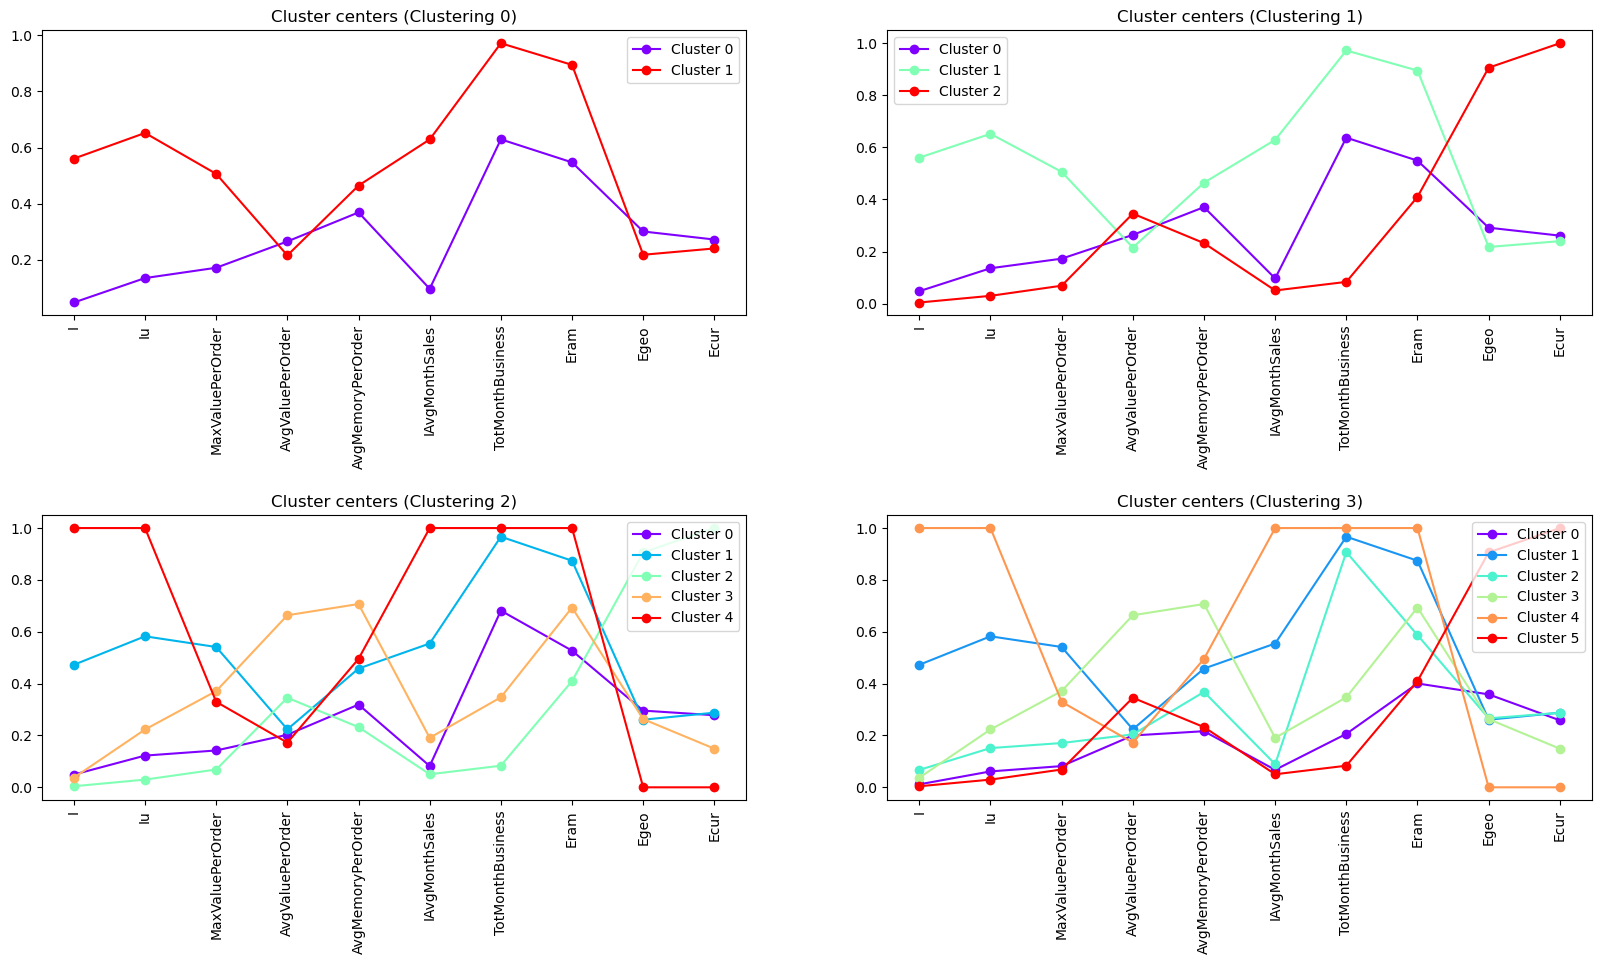

In [52]:
max_d = [1.3, 1.2, 1.0, 0.92]

hier_clustering_avg_res = []

for i in max_d:
    hier_clustering_avg_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="average").fit(vendor_norm))

Z = linkage(vendor_norm, 'average')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_avg_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_avg_res), hier_clustering_avg_res)

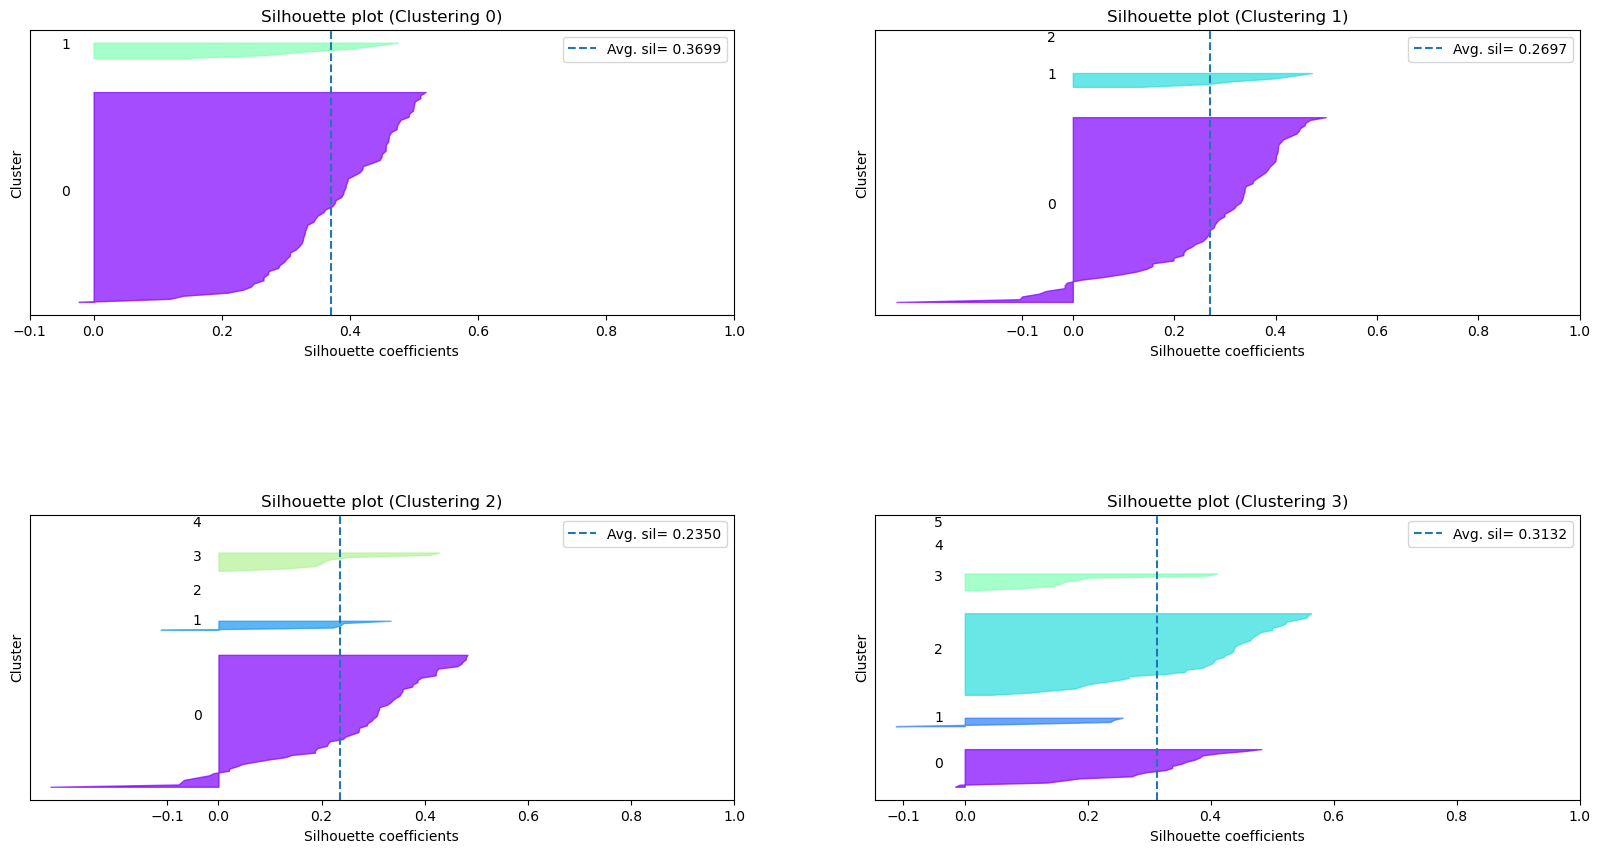

In [53]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_avg_res), hier_clustering_avg_res, ["sample_sil"])

The clustering choice here is non-obvious, the number of clusters and their composition makes the clusterings very fragmented and with low internal metrics, the only reasonble one seems to be the 1st one however its cutting height is quite high and some of the metrics are not promising.  
Before taking a decision we will take a closer look to the other clusterings.

### Post-processing

#### Clustering 1

In [54]:
new_clustering_1_labels = hier_clustering_avg_res[1].labels_

for i in range(len(new_clustering_1_labels)):
    if new_clustering_1_labels[i] == 2:
        new_clustering_1_labels[i] = 1
        
new_clustering_1 = wrapper_sk(new_clustering_1_labels)

We deal with the singleton cluster in the 2nd clustering by merging it in the cluster 1, which shows similar characteristics to it.

              Num. clusters Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                       
0                         2        [{0: 68, 1: 7}]                       0  29.764897        0.357109        1.47789


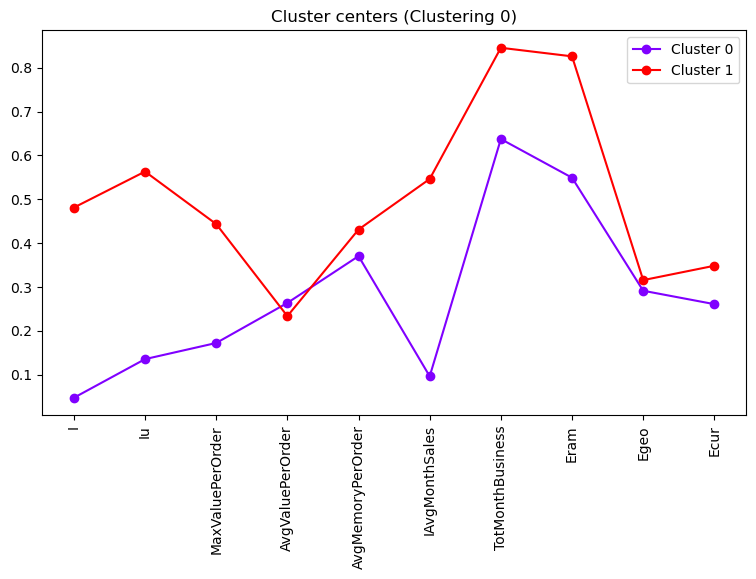

In [55]:
visualise_model_characteristics([vendor_norm], [new_clustering_1], ["general", "avg"])

#### Clustering 2

In [56]:
new_clustering_2_labels = hier_clustering_avg_res[2].labels_
new_clustering_2_labels = remap_clust_labels(new_clustering_2_labels, group_singleton_clusters(new_clustering_2_labels))

new_clustering_2 = wrapper_sk(new_clustering_2_labels)

              Num. clusters        Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                              
0                         4  [{-1: 2, 0: 59, 1: 5, 3: 9}]                       0  24.514528        0.258524       2.296959


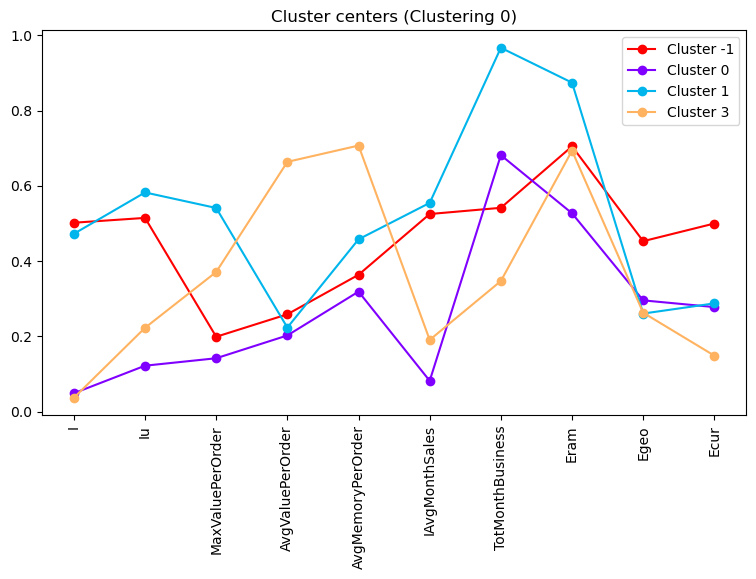

In [57]:
visualise_model_characteristics([vendor_norm], [new_clustering_2], ["general", "avg"])

We can see that the noise cluster is especially close, in terms of the key features I/Iu/IAvgMonthSales to cluster 1.  
We will therefore merge them.

In [58]:
new_clustering_2_labels = remap_clust_labels(new_clustering_2_labels, {-1:1, 0:0, 1:1, 2:2, 3:3})

new_clustering_2 = wrapper_sk(new_clustering_2_labels)

#### Clustering 3

In [59]:
new_clustering_3_labels = hier_clustering_avg_res[3].labels_
new_clustering_3_labels = remap_clust_labels(new_clustering_3_labels, group_singleton_clusters(new_clustering_3_labels))

new_clustering_3 = wrapper_sk(new_clustering_3_labels)

              Num. clusters               Datapoints per cluster Num. singleton clusters       SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         5  [{-1: 2, 0: 19, 1: 5, 2: 40, 3: 9}]                       0  17.06397        0.318639        2.12271


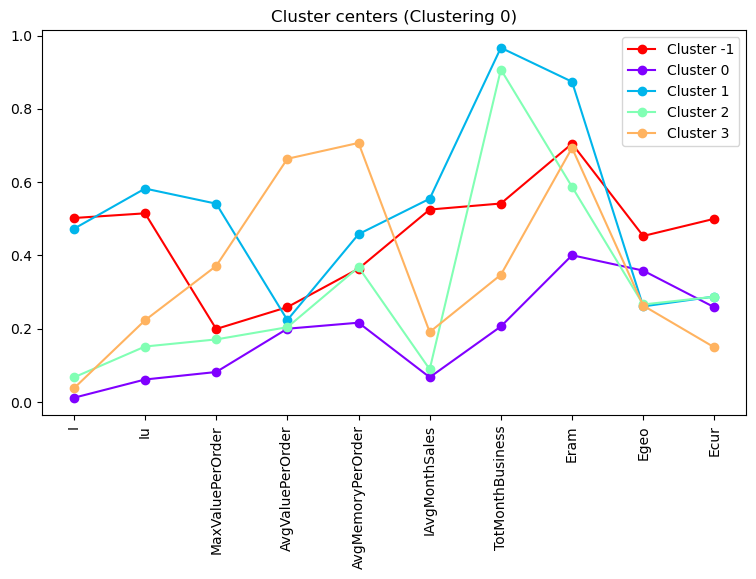

In [60]:
visualise_model_characteristics([vendor_norm], [new_clustering_3], ["general", "avg"])

Same as in the clustering 2 case.

In [61]:
new_clustering_3_labels = remap_clust_labels(new_clustering_3_labels, {-1:1, 0:0, 1:1, 2:2, 3:3})

new_clustering_3 = wrapper_sk(new_clustering_3_labels)

#### Clustering comparison

              Num. clusters        Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                              
0                         2               [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         2               [{0: 68, 1: 7}]                       0  29.764897        0.357109        1.47789
2                         3         [{0: 59, 1: 7, 3: 9}]                       0  25.121027        0.275494        1.37243
3                         4  [{0: 19, 1: 7, 2: 40, 3: 9}]                       0  17.670469        0.325911       1.254146


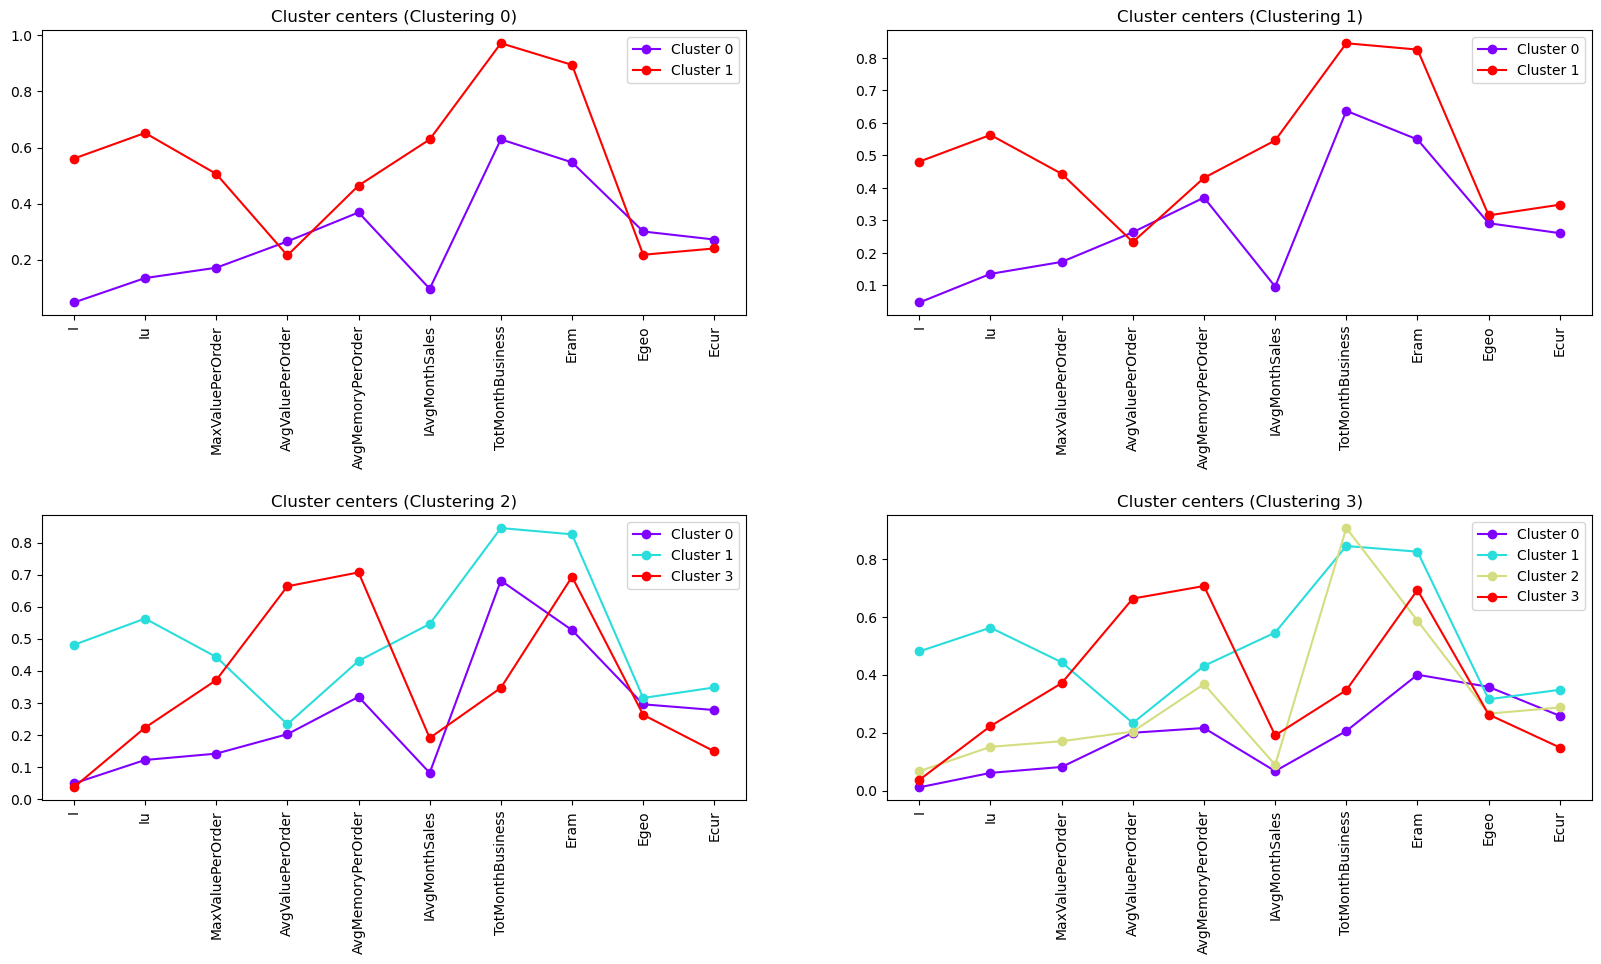

In [62]:
visualise_model_characteristics([vendor_norm]*4, [hier_clustering_avg_res[0], new_clustering_1, \
                                                  new_clustering_2, new_clustering_3], ["general", "avg"])

The first two clusterings are almost identical and correspond to the usual **big/small** labeling.  
The clustering 2 presents some similarities to the ones obtained by k-means and single linkage, however its internal metrics are the worst ones.  
The clustering 3 is the most promising, taking into account the cutting height and the number of clusters suggested by the dendogram, it also offers the possibility of a different interpretation from the usual ones: **new-small-cheap** (0), **old-big** (1), **old-small** (2) and **new-small-expensive** (3) due to the higher than average value of AvgValuePerOrder.  
We will continue the analysis with the last clustering.

In [63]:
average_final = new_clustering_3
average_final.set_params(**{"linkage":"average"})

cluster_map_average = {0:"new-small-cheap", 1:"old-big", 2:"old-small", 3:"new-small-expensive"}

### External indices

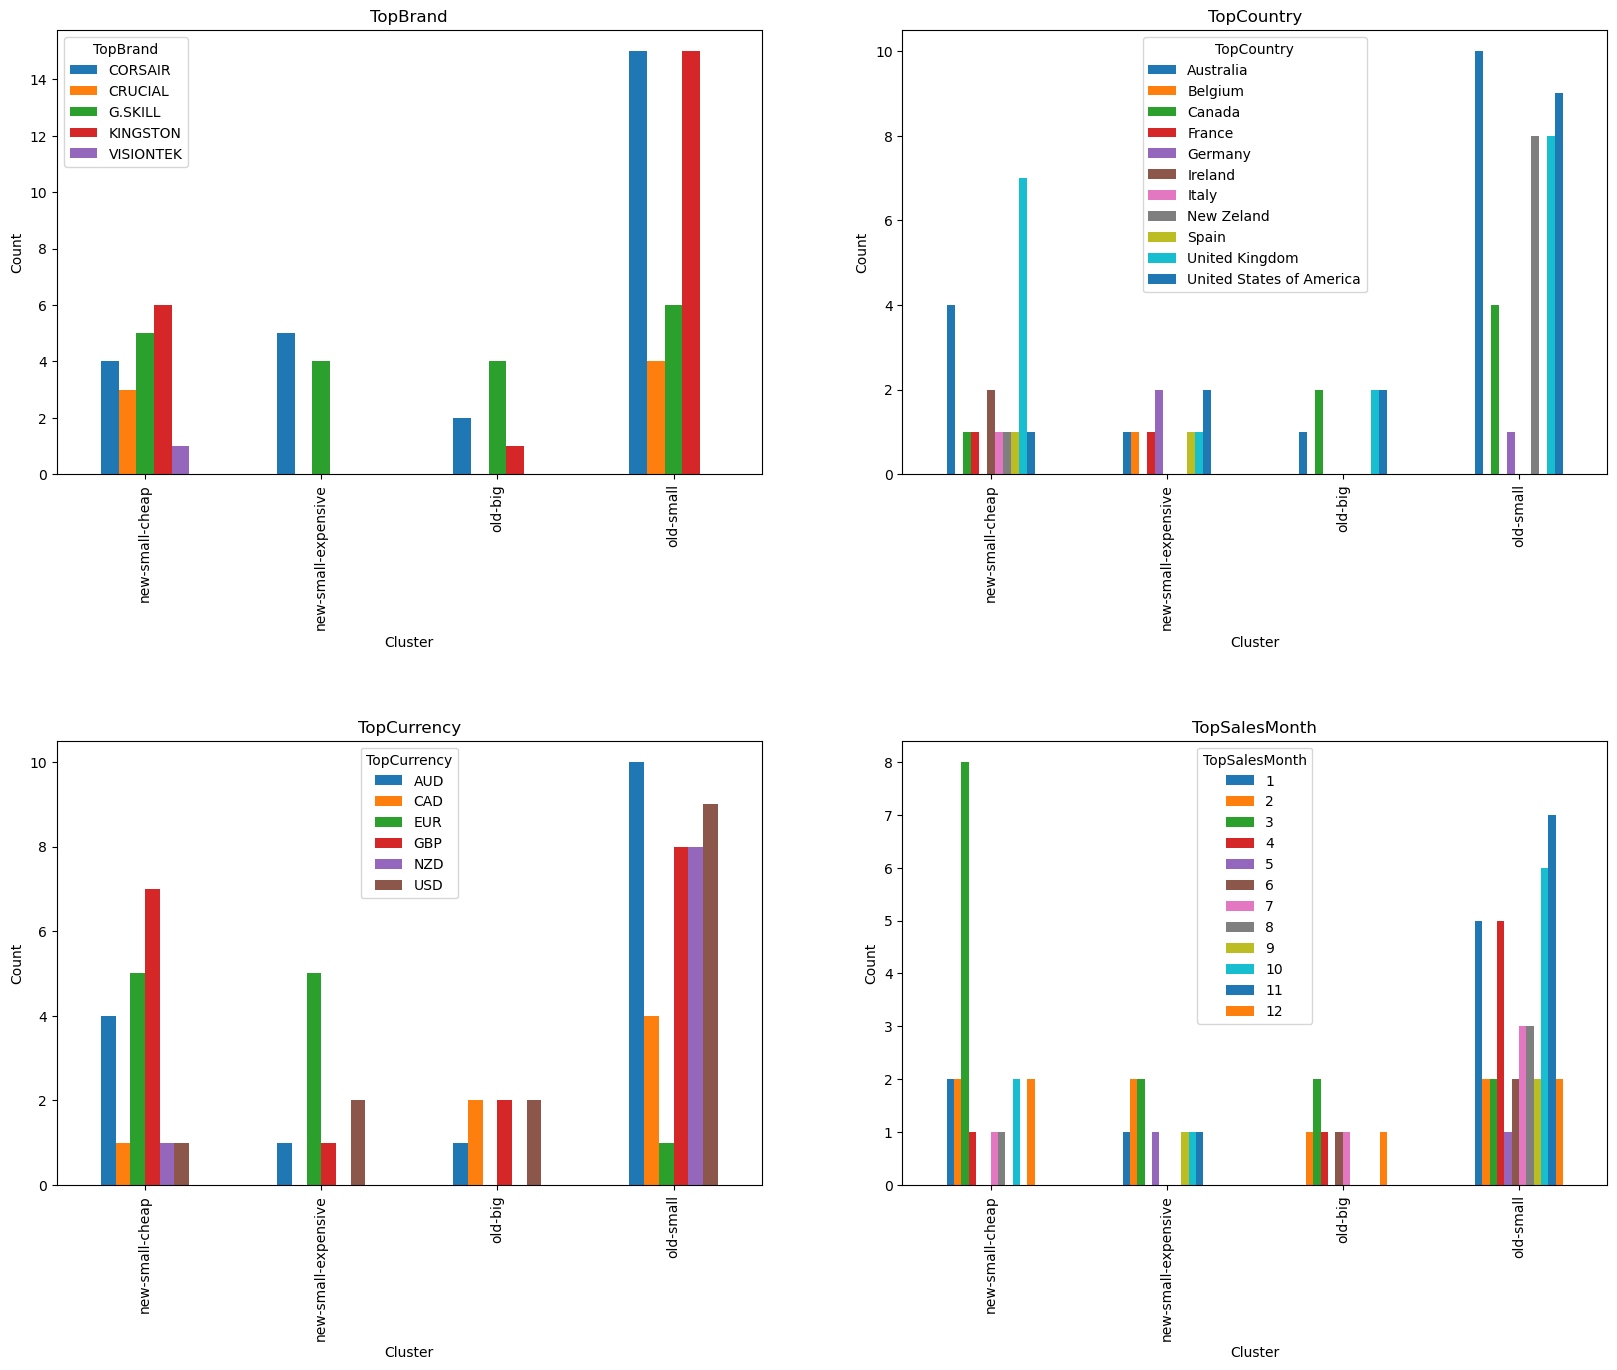

In [64]:
plot_categ_per_cluster(vendor_df_cat, average_final, cluster_map_average)

In [65]:
create_external_indices(vendor_df_cat, average_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.101804      0.118924     0.109700
1     TopCountry     0.145905      0.251176     0.184586
2    TopCurrency     0.124180      0.186741     0.149167
3  TopSalesMonth     0.115234      0.234613     0.154555

Nothing too remarkable, the completeness score of TopCountry seems to be higher than usual, probably a consequence of the higher number of labels used in this clustering.

### Ward method

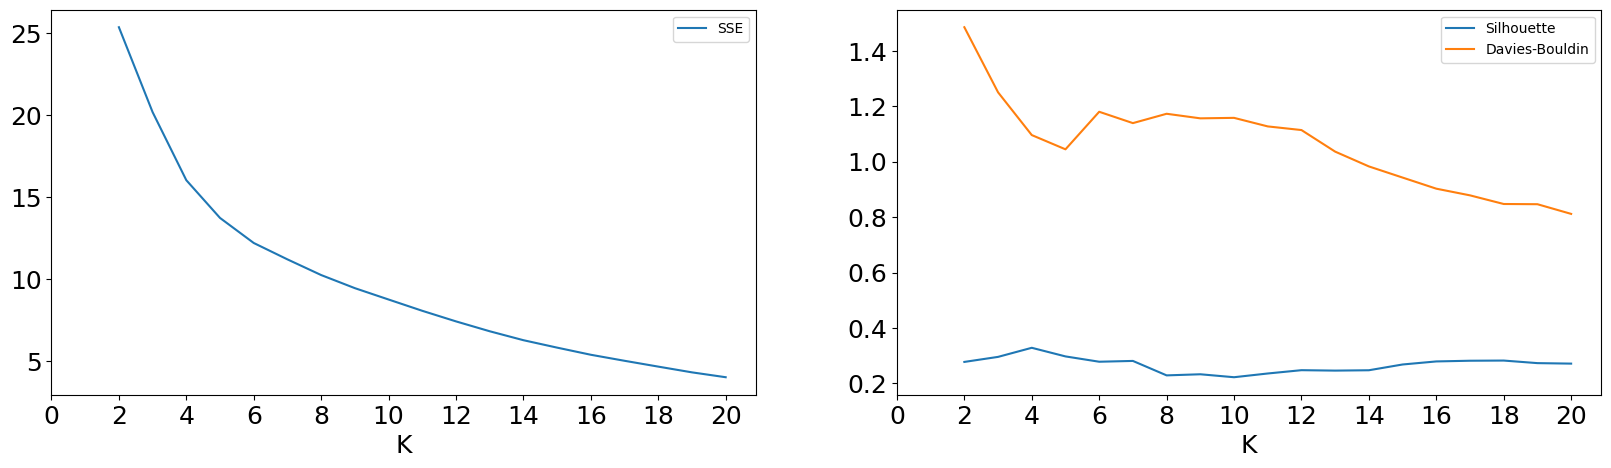

In [66]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

Cophenetic coefficient: 0.6082119998283974


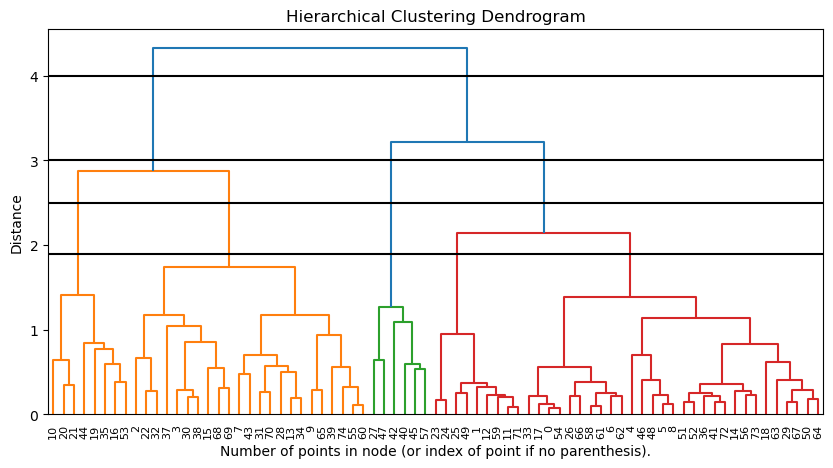

              Num. clusters              Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         2                    [{0: 44, 1: 31}]                       0  25.339559        0.277266       1.485544
1                         3              [{0: 31, 1: 38, 2: 6}]                       0  20.168379        0.295448       1.250532
2                         4        [{0: 38, 1: 23, 2: 6, 3: 8}]                       0  16.022487        0.328263       1.096212
3                         5  [{0: 23, 1: 8, 2: 6, 3: 29, 4: 9}]                       0  13.723498        0.297164       1.044776


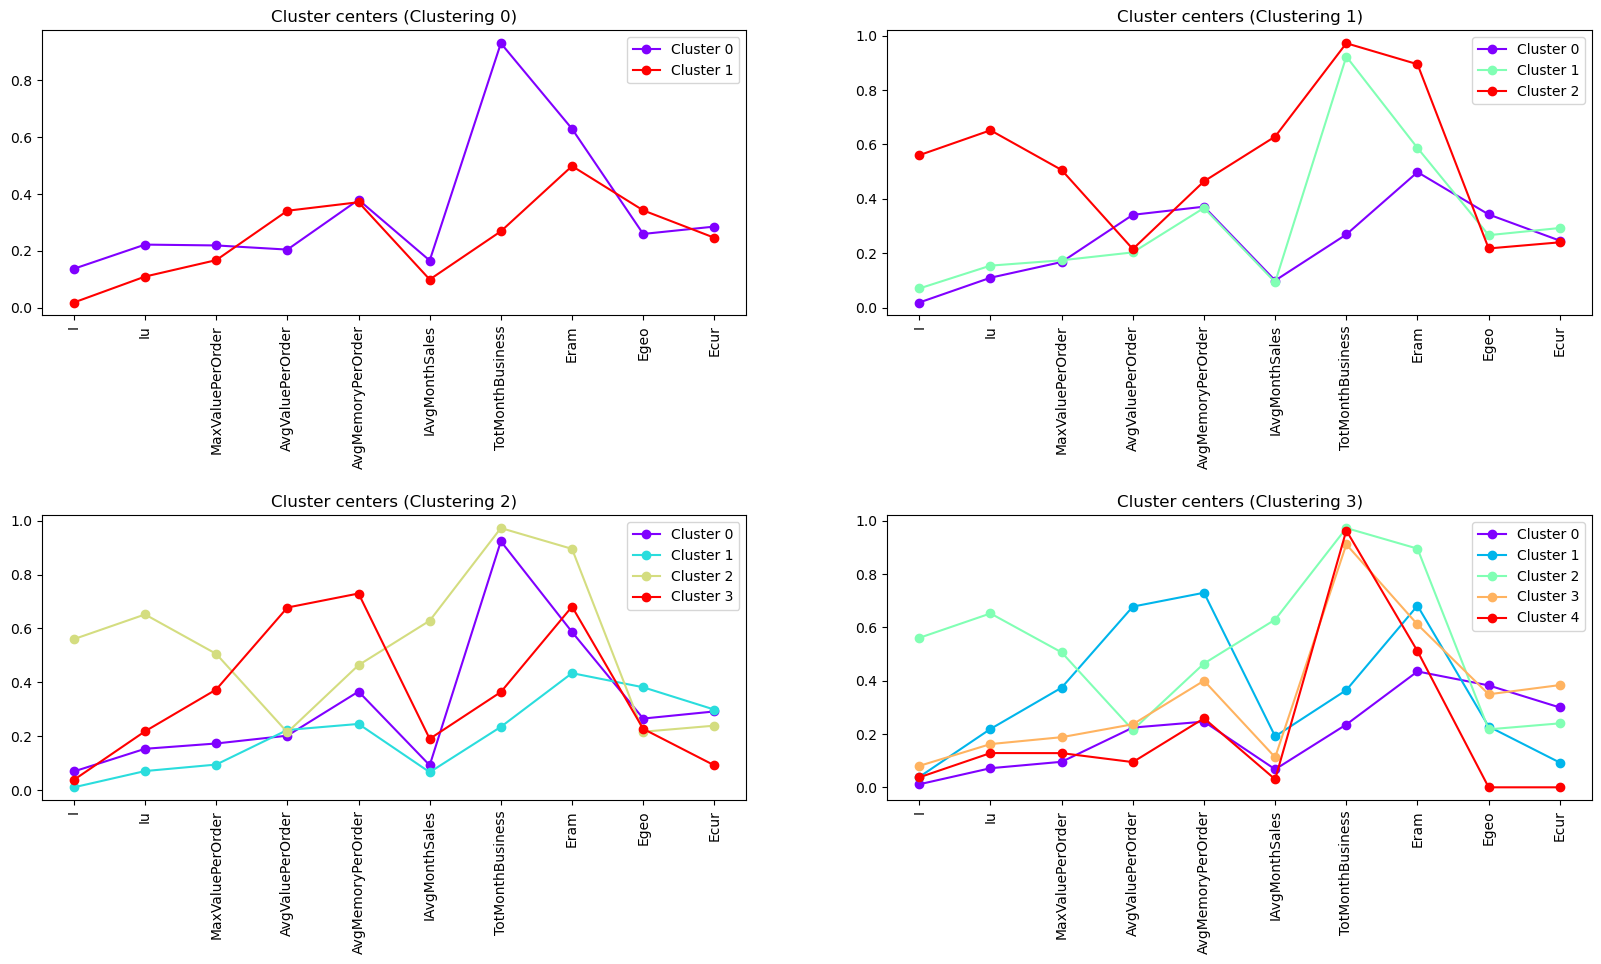

In [67]:
max_d = [4, 3, 2.5, 1.9]

hier_clustering_ward_res = []

for i in max_d:
    hier_clustering_ward_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="ward").fit(vendor_norm))

Z = linkage(vendor_norm, 'ward')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_ward_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_ward_res), hier_clustering_ward_res)

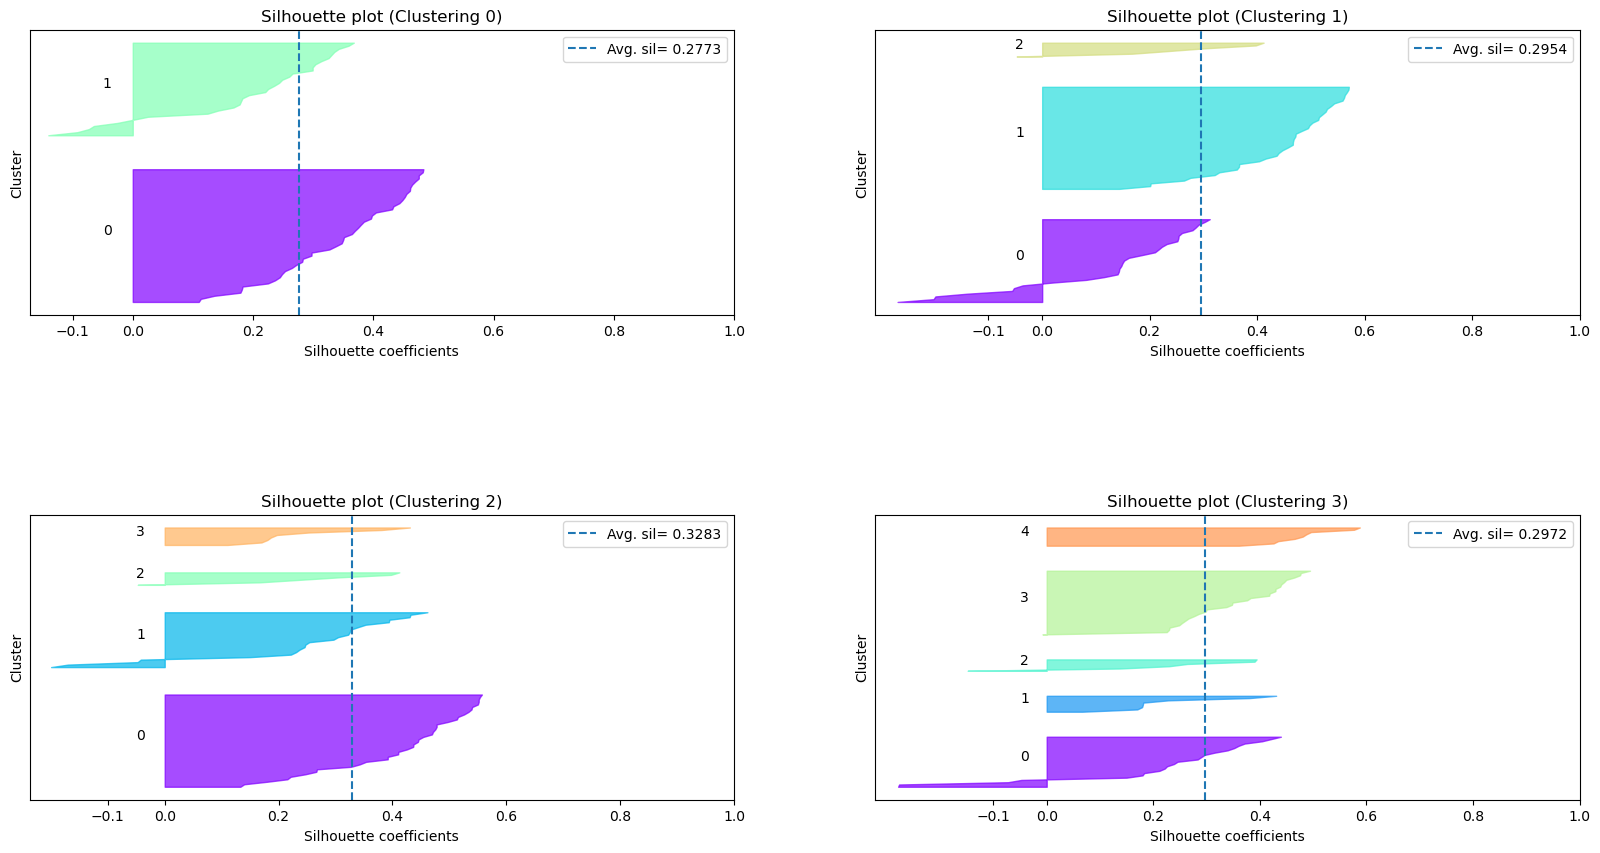

In [68]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_ward_res), hier_clustering_ward_res, ["sample_sil"])

Based on the internal metrics and the cutting height the clusterin 2 seems the most promising.  
We find the same labeling as with average linkage.

In [69]:
ward_final = hier_clustering_ward_res[2]

cluster_map_ward = {0:"old-small", 1:"new-small-cheap", 2:"old-big", 3:"new-small-expensive"}

### External indices

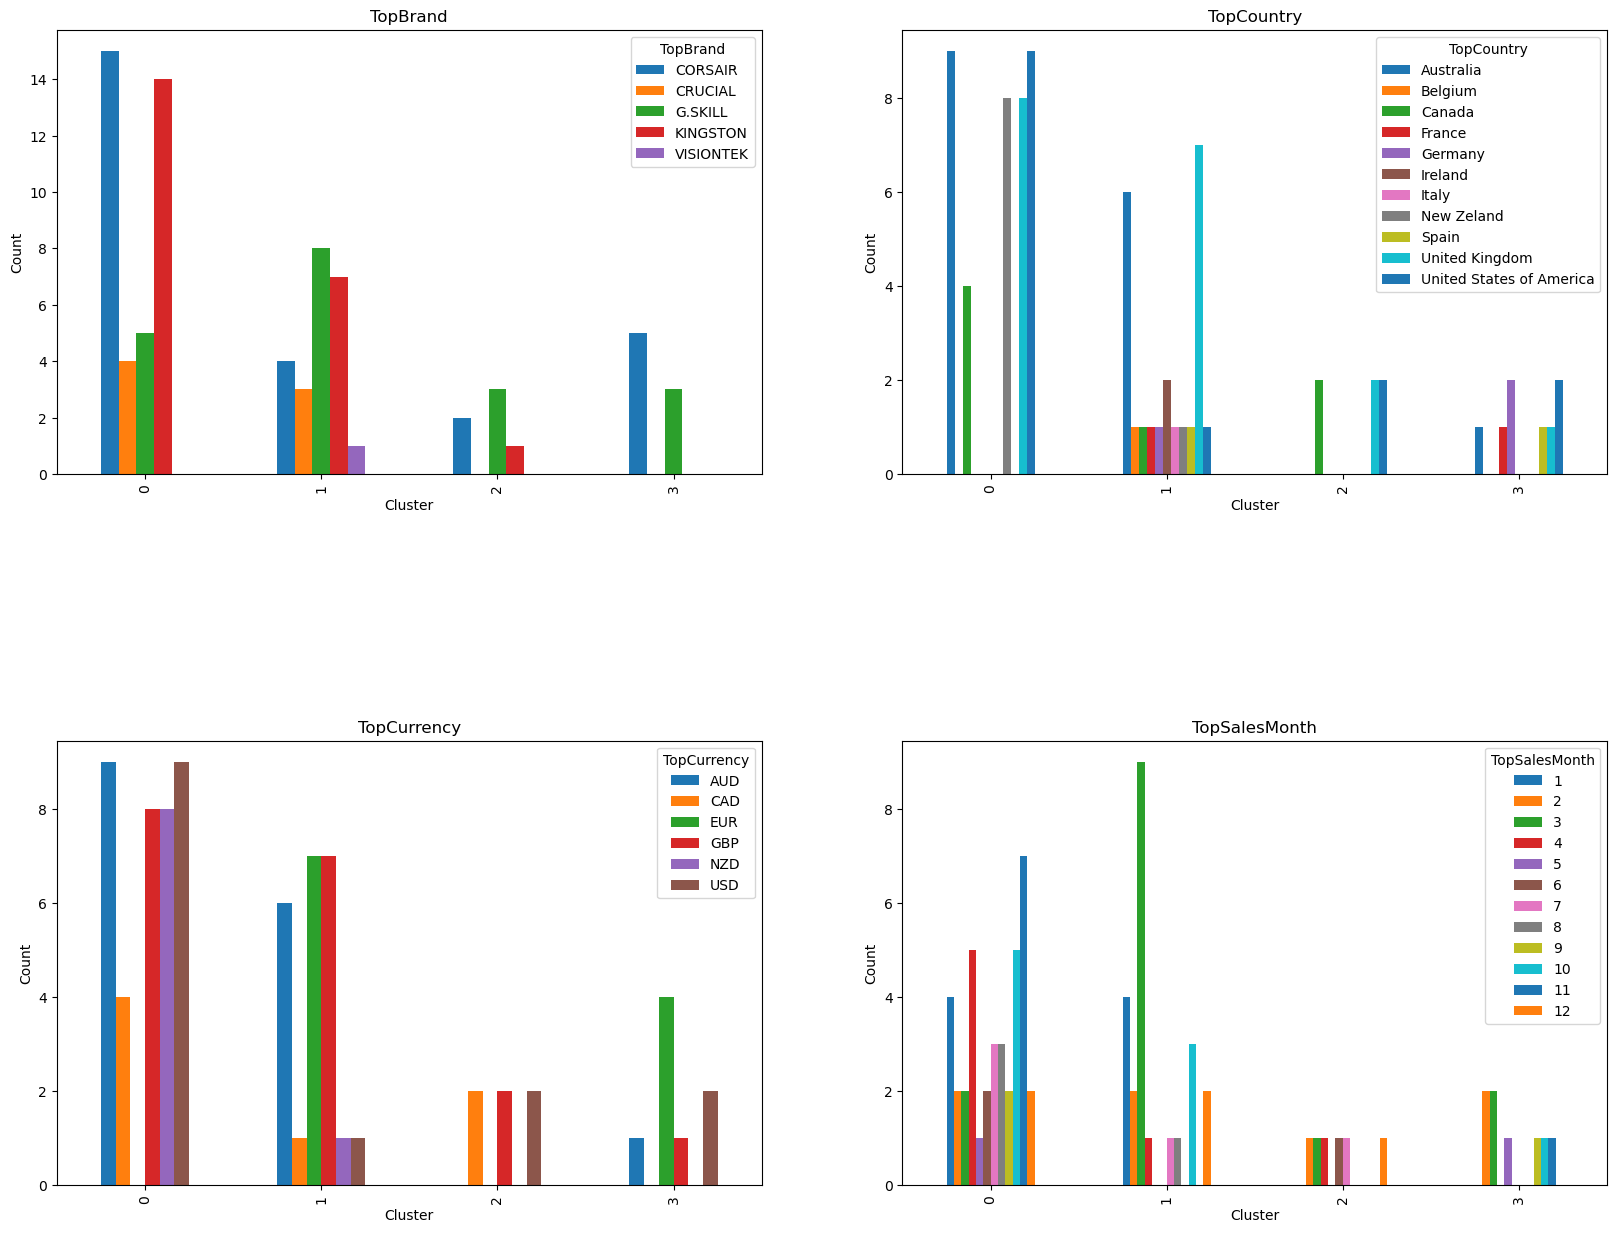

In [70]:
plot_categ_per_cluster(vendor_df_cat, ward_final)

In [71]:
create_external_indices(vendor_df_cat, ward_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.099325      0.117154     0.107505
1     TopCountry     0.153388      0.266619     0.194741
2    TopCurrency     0.156252      0.237250     0.188415
3  TopSalesMonth     0.125301      0.257583     0.168591

#### Conclusion  
The results are pretty similar to the ones from average linkage, however in terms of metrics it should be closer to k-means given the common clusterisation based on minimising the clusters SSE.

## Clustering conclusions

In [72]:
def construct_clust_df(clust_dict):
    
    cols = ["Type", "Clusters", "SSE", "Silhouette", "Davies-Bouldin", "Ideal corr. avg", "Cophenetic coef."]
    
    out_df = pd.DataFrame(columns=cols)
    
    for key in clust_dict:
        
        model = clust_dict[key][0]
        k = len(np.unique(model.labels_))

        sse_score = compute_sse_global(vendor_norm, model.labels_)
        sil_score = silhouette_score(vendor_norm, model.labels_)
        db_score = davies_bouldin_score(vendor_norm, model.labels_)
        id_corr_avg = np.mean(compute_ideal_similarity_coeff(vendor_norm, model.labels_))
        coph_coef = np.NaN
        
        try:
            if model.get_params()["linkage"] != None:
                
                Z = linkage(vendor_norm, model.get_params()["linkage"])
                coph_coef, coph_dists = cophenet(Z, pdist(vendor_norm))
                
        except KeyError:
            pass

        new_entry = dict(zip(cols, [key, k, sse_score, sil_score, db_score, id_corr_avg, coph_coef]))
        out_df = out_df.append(new_entry, ignore_index=True)
        
    return out_df

In [73]:
clusterings_dict = {"K-means": (kmeans_final, cluster_map_kmeans),
                    "C-means": (cmeans_final, cluster_map_cmeans),
                    "DBSCAN": (dbscan_final, cluster_map_dbscan),
                    "Hier. single linkage": (single_final, cluster_map_single),
                    "Hier. complete linkage": (complete_final, cluster_map_complete),
                    "Hier. average linkage": (average_final, cluster_map_average),
                    "Hier. ward linkage": (ward_final, cluster_map_ward)}

name_model_dict = {k:v[0] for k,v in clusterings_dict.items()}
name_map_dict = {k:list(v[1].values()) for k,v in clusterings_dict.items()}
model_list = [v[0] for k,v in clusterings_dict.items()]

### Internal metrics

In [74]:
conclusion_res = construct_clust_df(clusterings_dict)
conclusion_res

Type Clusters        SSE  Silhouette  Davies-Bouldin  \
0                 K-means        3  19.604555    0.326206        1.222483   
1                 C-means        2  25.207743    0.274823        1.464526   
2                  DBSCAN        2  31.164668    0.308345        2.505490   
3    Hier. single linkage        2  32.294690    0.342998        2.110812   
4  Hier. complete linkage        3  21.962575    0.250721        1.392849   
5   Hier. average linkage        4  17.670469    0.325911        1.254146   
6      Hier. ward linkage        4  16.022487    0.328263        1.096212   

   Ideal corr. avg  Cophenetic coef.  
0         0.439060               NaN  
1         0.297275               NaN  
2         0.447247               NaN  
3         0.490579          0.676693  
4         0.436270          0.724248  
5         0.454460          0.790225  
6         0.454360          0.608212

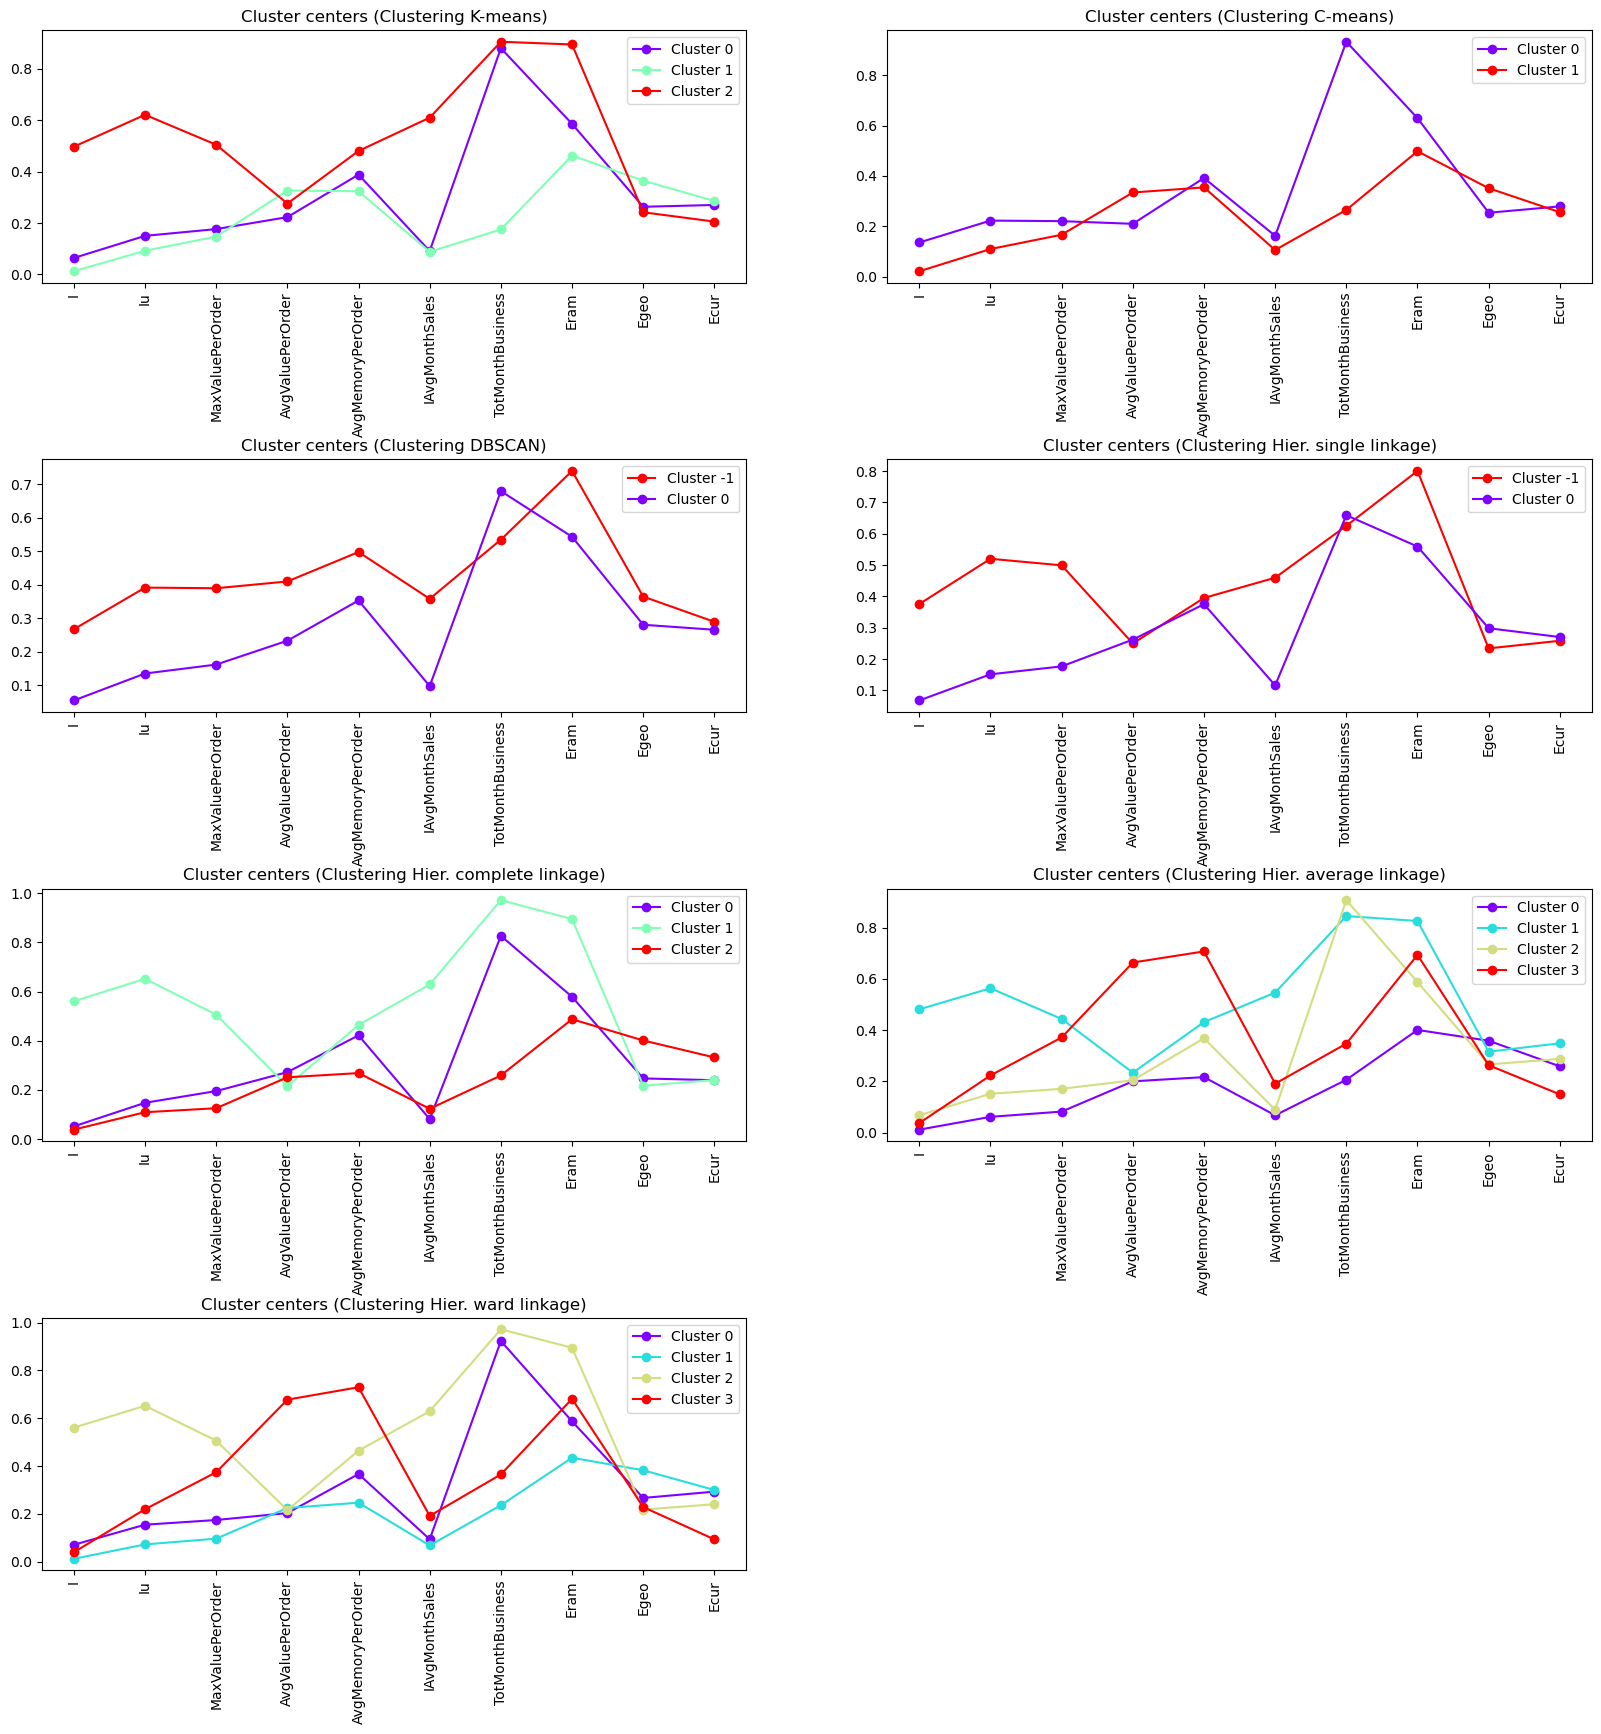

In [75]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["avg"], list(clusterings_dict.keys()))

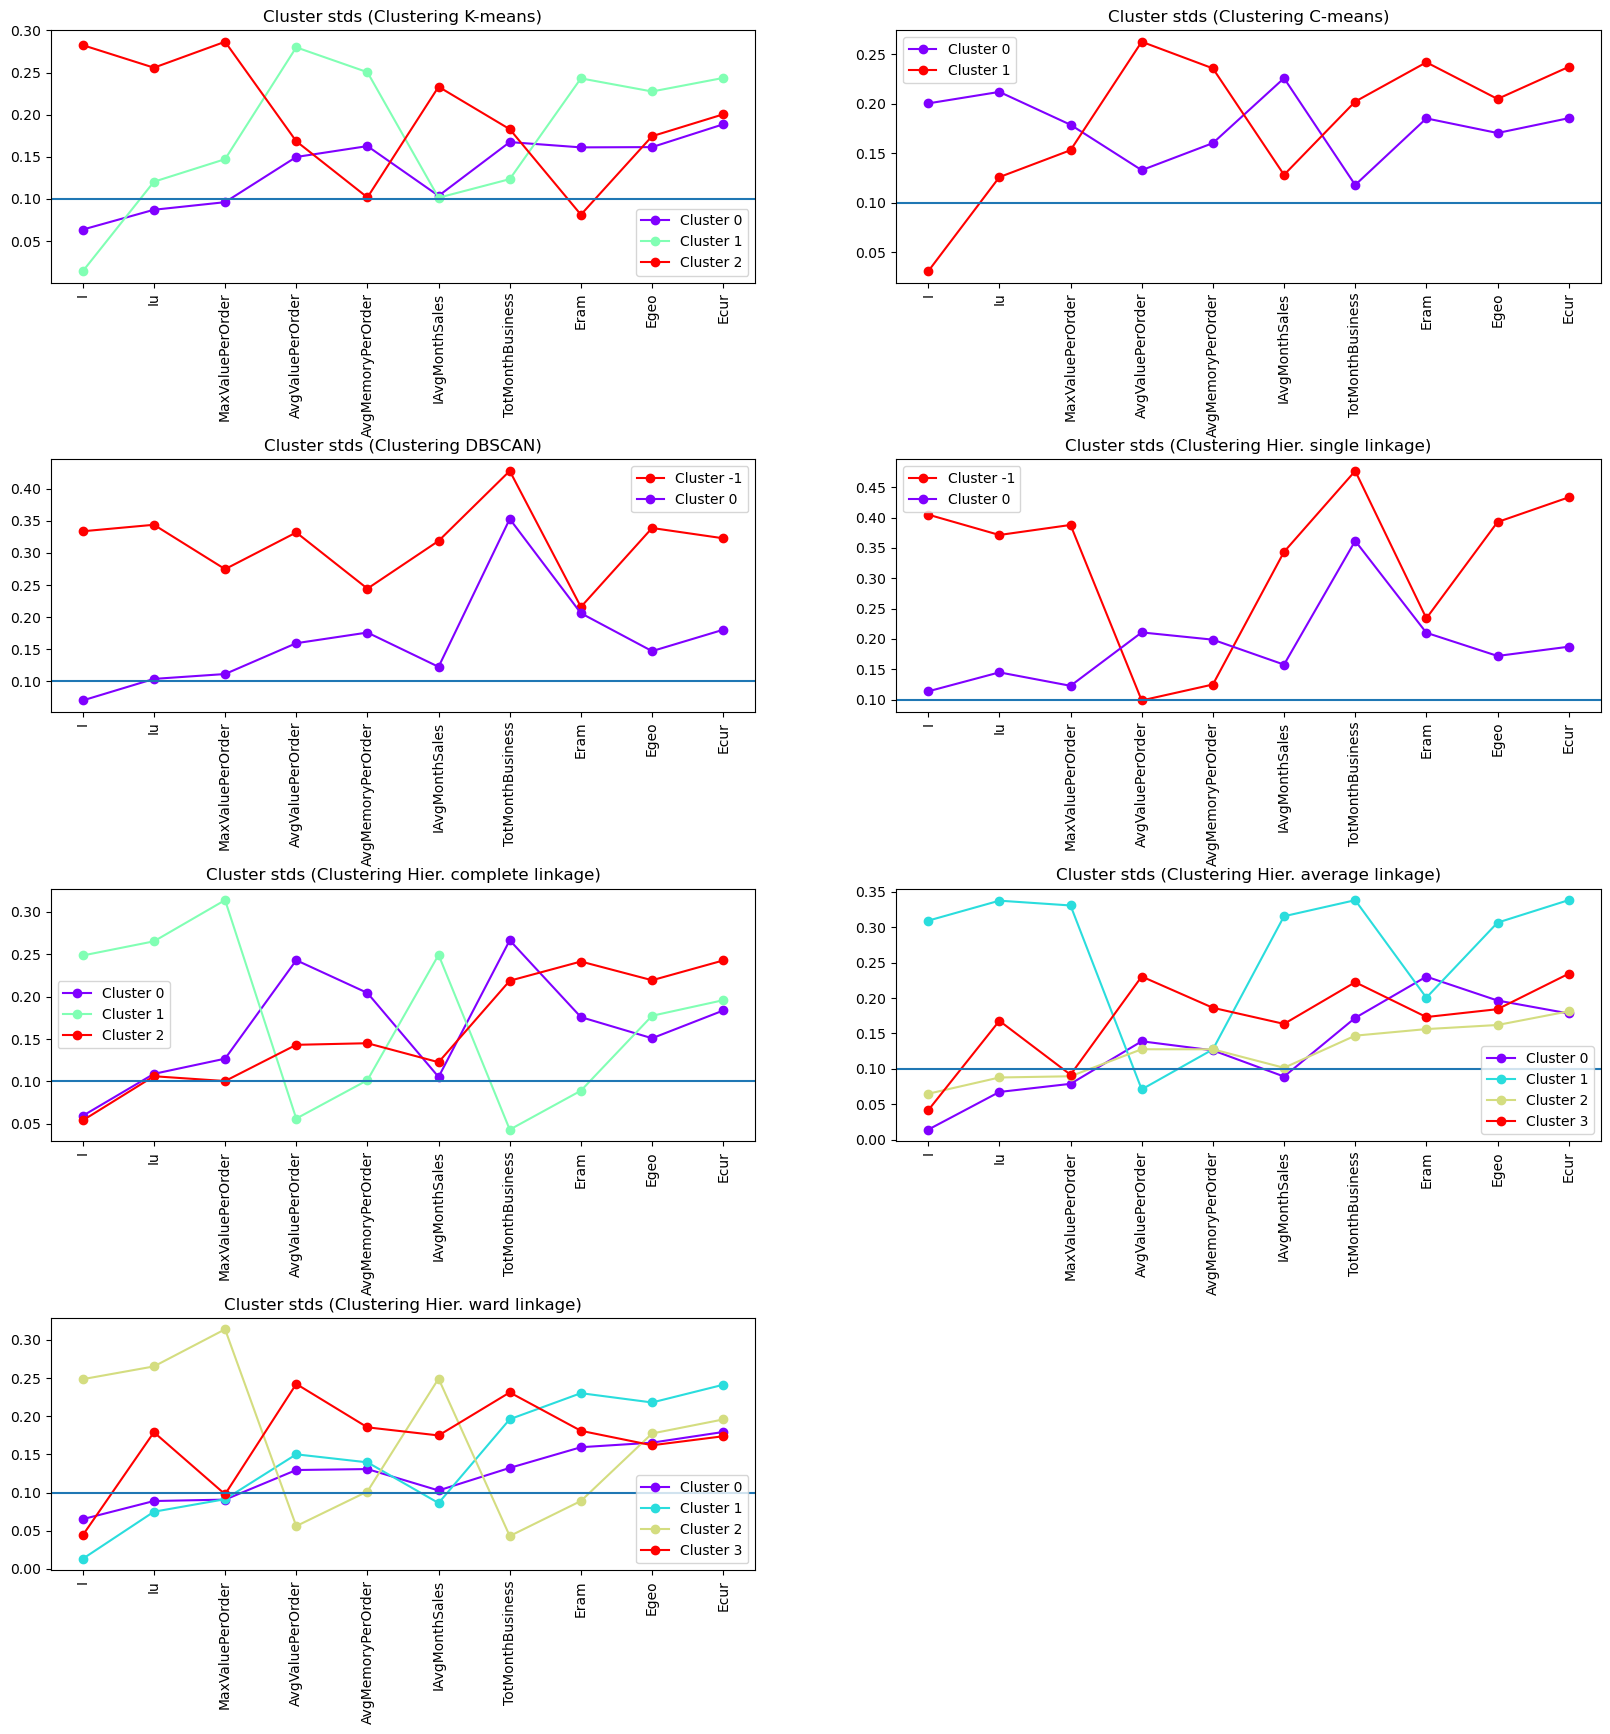

In [76]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["std"], list(clusterings_dict.keys()))

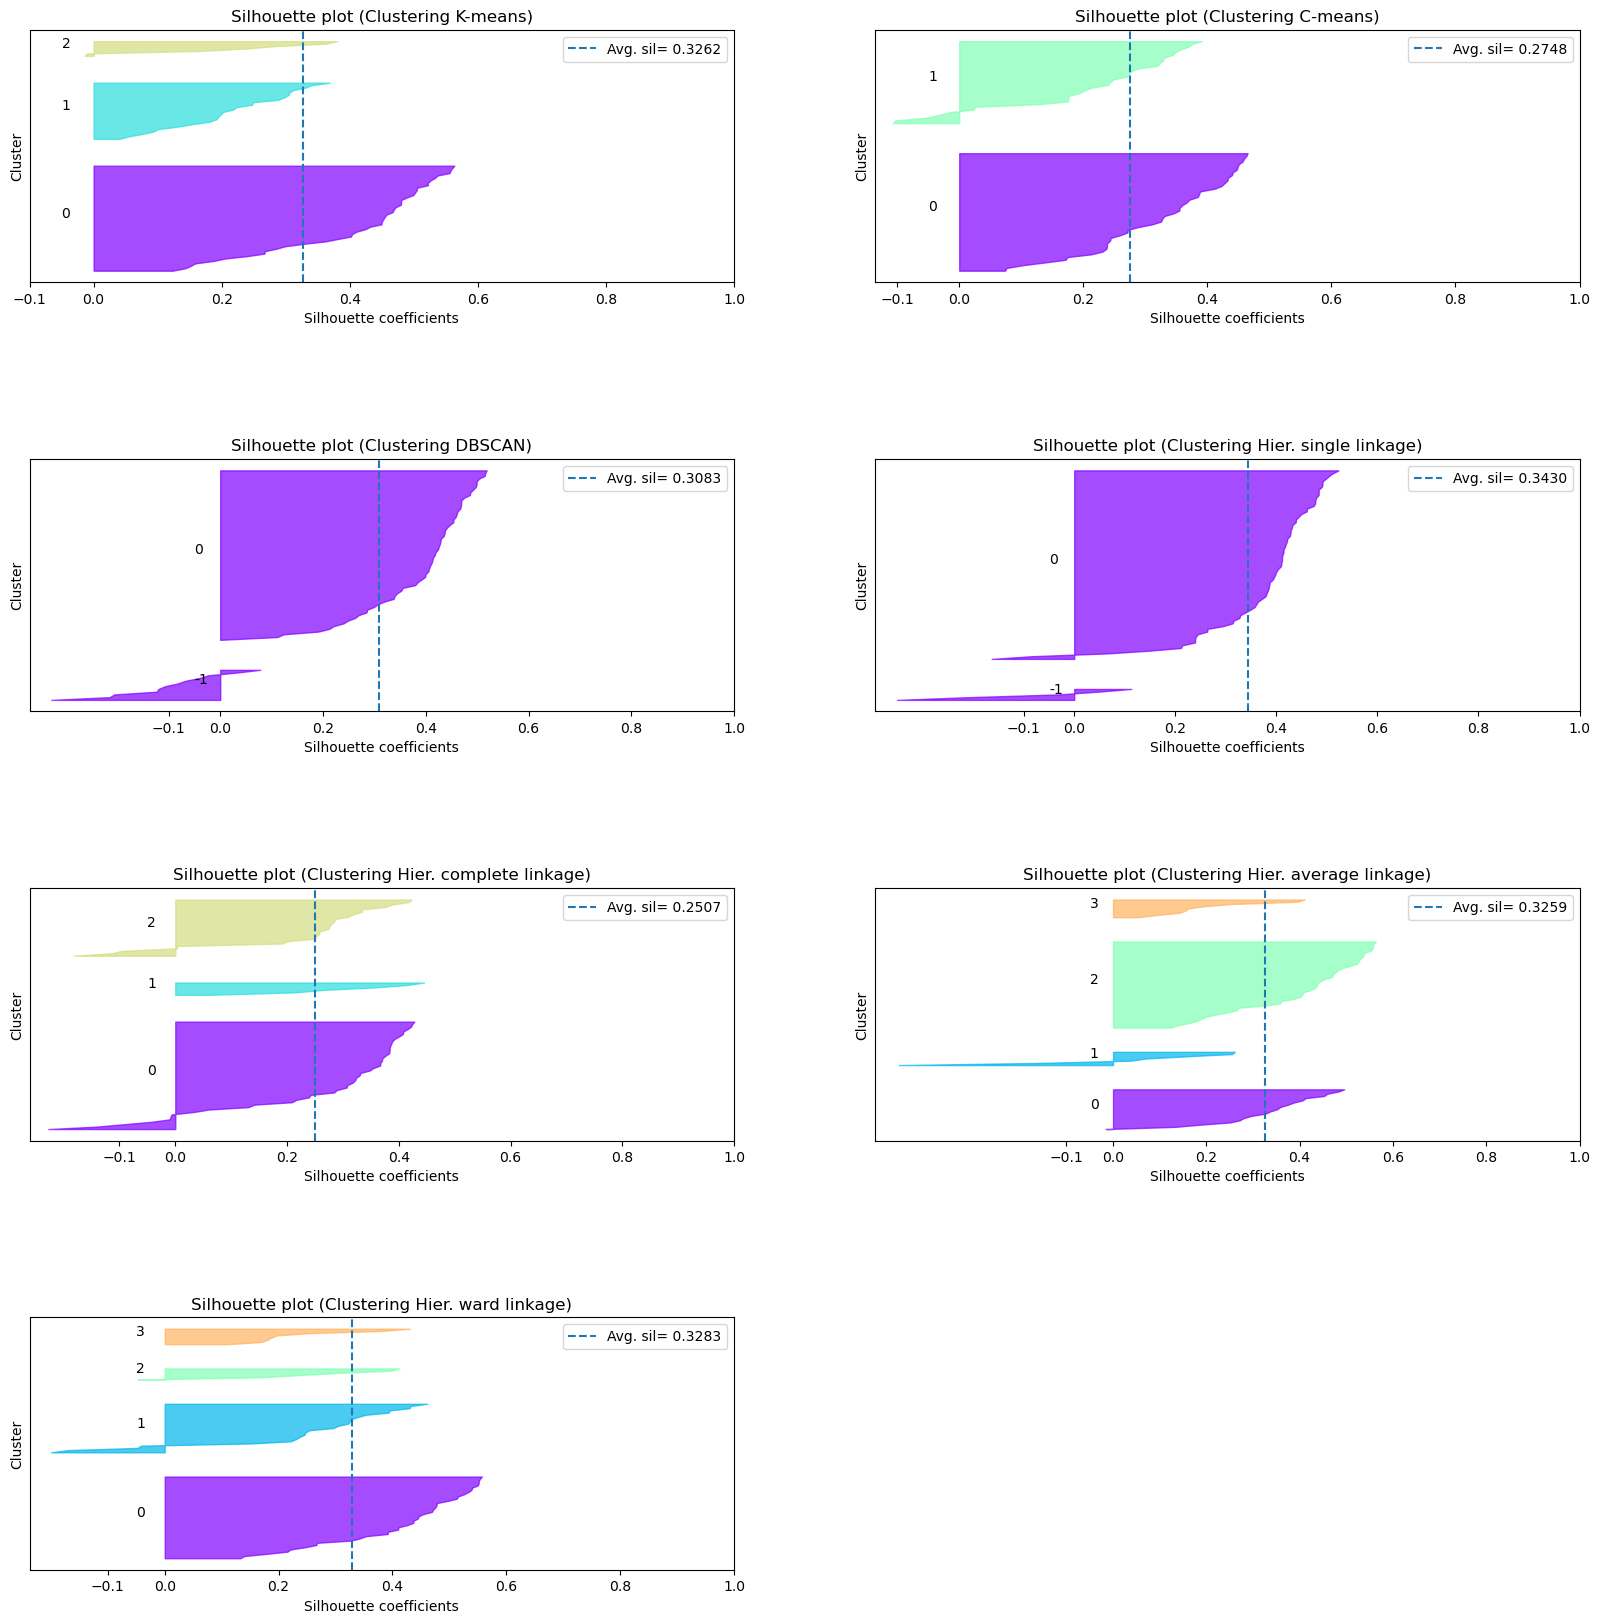

In [77]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["sample_sil"], list(clusterings_dict.keys()))

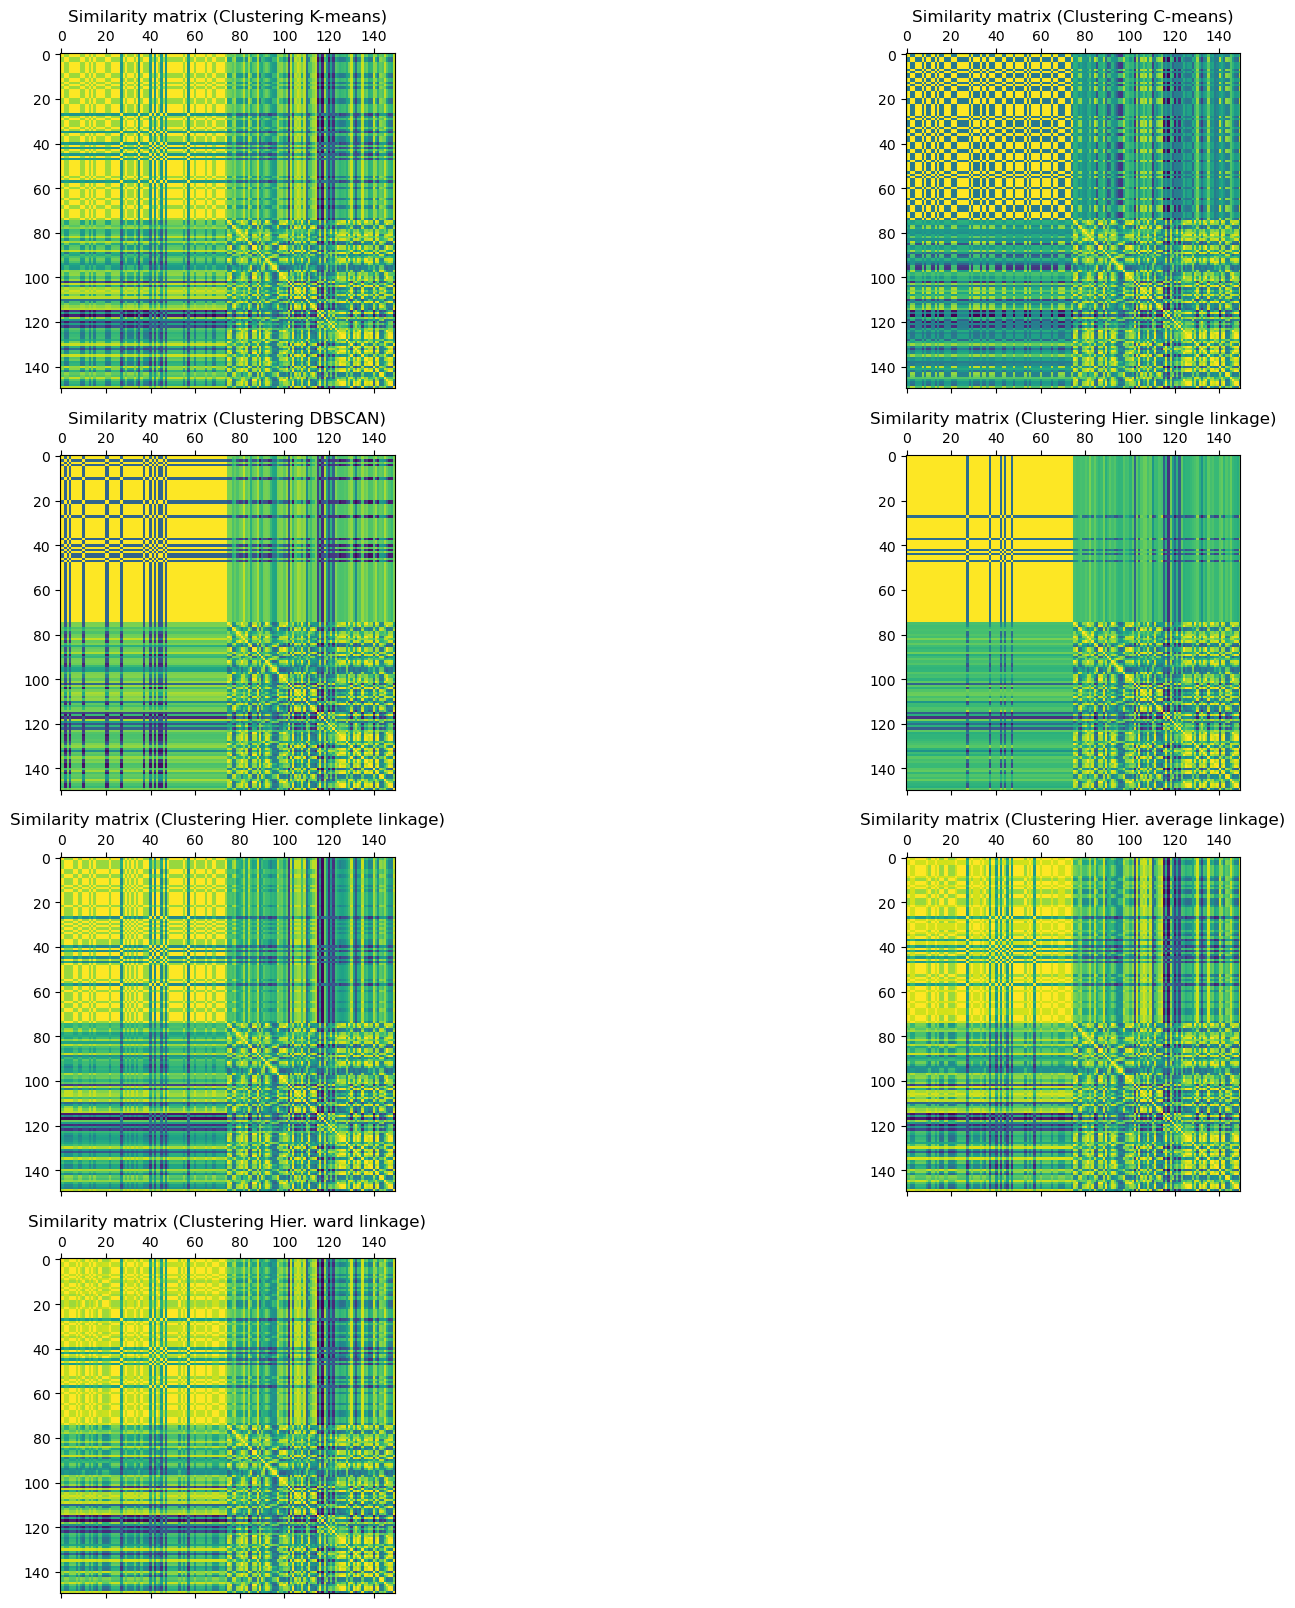

In [78]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["simil_matrix"], list(clusterings_dict.keys()))

### External metrics

In [79]:
compare_df = compare_model_labels(name_model_dict, name_map_dict)
compare_df.sort_values("Mutual Info", ascending=False)

Model 1                            Model 2  \
20   Hier. average linkage (4 labels)      Hier. ward linkage (4 labels)   
4                  K-means (3 labels)   Hier. average linkage (4 labels)   
5                  K-means (3 labels)      Hier. ward linkage (4 labels)   
10                 C-means (2 labels)      Hier. ward linkage (4 labels)   
19  Hier. complete linkage (3 labels)      Hier. ward linkage (4 labels)   
3                  K-means (3 labels)  Hier. complete linkage (3 labels)   
0                  K-means (3 labels)                 C-means (2 labels)   
18  Hier. complete linkage (3 labels)   Hier. average linkage (4 labels)   
9                  C-means (2 labels)   Hier. average linkage (4 labels)   
11                  DBSCAN (2 labels)    Hier. single linkage (2 labels)   
8                  C-means (2 labels)  Hier. complete linkage (3 labels)   
13                  DBSCAN (2 labels)   Hier. average linkage (4 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (4 labels)   
1                  K-means (3 labels)                  DBSCAN (2 labels)   
16    Hier. single linkage (2 labels)   Hier. average linkage (4 labels)   
12                  DBSCAN (2 labels)  Hier. complete linkage (3 labels)   
2                  K-means (3 labels)    Hier. single linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (4 labels)   
15    Hier. single linkage (2 labels)  Hier. complete linkage (3 labels)   
6                  C-means (2 labels)                  DBSCAN (2 labels)   
7                  C-means (2 labels)    Hier. single linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info  \
20     0.829884      0.837932     0.833889   
4      0.774219      0.600492     0.676378   
5      0.752266      0.589123     0.660773   
10     0.849795      0.502030     0.631180   
19     0.611788      0.465432     0.528668   
3      0.515588      0.530741     0.523055   
0      0.451805      0.598921     0.515064   
18     0.580464      0.437360     0.498852   
9      0.672282      0.393346     0.496307   
11     0.309912      0.556318     0.398069   
8      0.295229      0.229256     0.258093   
13     0.464829      0.176353     0.255697   
14     0.403554      0.154590     0.223546   
1      0.156033      0.318984     0.209559   
16     0.568865      0.120230     0.198506   
12     0.234455      0.118055     0.157038   
2      0.099467      0.365020     0.156334   
17     0.385594      0.082286     0.135629   
15     0.286257      0.080297     0.125414   
6      0.004298      0.006629     0.005215   
7      0.000039      0.000107     0.000057   

                                             Labels 1  \
20  [new-small-cheap, old-big, old-small, new-smal...   
4                     [old-big, new-small, old-small]   
5                     [old-big, new-small, old-small]   
10                                         [new, old]   
19                    [old-small, old-big, new-small]   
3                     [old-big, new-small, old-small]   
0                     [old-big, new-small, old-small]   
18                    [old-small, old-big, new-small]   
9                                          [new, old]   
11                                       [big, small]   
8                                          [new, old]   
13                                       [big, small]   
14                                       [big, small]   
1                     [old-big, new-small, old-small]   
16                                       [small, big]   
12                                       [big, small]   
2                     [old-big, new-small, old-small]   
17                                       [small, big]   
15                                       [small, big]   
6                                          [new, old]   
7                                          [new, old]   

                                             Labels 2  
20  [old-small, new-small-cheap, 

Some labelings have a strong connection with the ones from different clusterings according to the external indices, even if they don't share the same labels.  

An interesting consequence of our labelings is that the majority of them can be reduced to a more general category (ie big/small or new/old) and we can therefore more directly compare the results between clusterings.

In [80]:
old_new_reduction_map = {"old-big":"old", "old-small":"old", "old":"old", "new-small":"new", "new-small-cheap":"new", \
                         "new-small-expensive":"new", "new":"new", "big":"big", "small":"small"}

big_small_reduction_map = {"old-big":"big", "big":"big", "old-small":"small", "new-small":"small", "new-small-cheap":"small", \
                           "new-small-expensive":"small", "small":"small", "new":"new", "old":"old"}

In [81]:
def invert_map_dict(map_dict):
    
    list_values = list(map_dict.values())
    
    if len(list_values) != len(np.unique(list_values)):
        raise RuntimeError("Cannot invert: duplicate key values")
        
    new_dict = {}
    
    for k,v in map_dict.items():
        new_dict[v] = k
        
    return new_dict

def apply_reduction_map(clust_map, reduc_map):
    
    set_values = np.unique(list(reduc_map.values()))
    #ie {old:0, new:1}
    reduc_to_int_map = {set_values[i]:i for i in range(len(set_values))}
    
    new_clust_remapping = {}
    new_clust_map = {}
    
    for k,v in clust_map.items():
        new_label = reduc_map[v]
        new_int = reduc_to_int_map[new_label]
        new_clust_remapping[k] = new_int
        new_clust_map[new_int] = new_label
        
    return (new_clust_map, new_clust_remapping)

In [82]:
old_new_name_map_dict = {}
big_small_name_map_dict = {}

for k, v in clusterings_dict.items():
    
    model = v[0]
    old_labels = model.labels_
    int_name_map, clust_map_remapped = apply_reduction_map(v[1], old_new_reduction_map)
    new_labels = remap_clust_labels(old_labels, clust_map_remapped)
    old_new_name_map_dict[k] = (wrapper_sk(new_labels), int_name_map)


for k, v in clusterings_dict.items():
    
    model = v[0]
    old_labels = model.labels_
    int_name_map, clust_map_remapped = apply_reduction_map(v[1], big_small_reduction_map)
    new_labels = remap_clust_labels(old_labels, clust_map_remapped)
    big_small_name_map_dict[k] = (wrapper_sk(new_labels), int_name_map)

In [83]:
reduc_old_new_res = compare_model_labels({k:v[0] for k,v in old_new_name_map_dict.items()}, \
                                       {k:list(v[1].values()) for k,v in old_new_name_map_dict.items()})
reduc_old_new_res.sort_values("Homogeneity", ascending=False)

Model 1                            Model 2  \
10                 C-means (2 labels)      Hier. ward linkage (2 labels)   
20   Hier. average linkage (2 labels)      Hier. ward linkage (2 labels)   
0                  K-means (2 labels)                 C-means (2 labels)   
5                  K-means (2 labels)      Hier. ward linkage (2 labels)   
9                  C-means (2 labels)   Hier. average linkage (2 labels)   
4                  K-means (2 labels)   Hier. average linkage (2 labels)   
3                  K-means (2 labels)  Hier. complete linkage (2 labels)   
11                  DBSCAN (2 labels)    Hier. single linkage (2 labels)   
8                  C-means (2 labels)  Hier. complete linkage (2 labels)   
18  Hier. complete linkage (2 labels)   Hier. average linkage (2 labels)   
19  Hier. complete linkage (2 labels)      Hier. ward linkage (2 labels)   
1                  K-means (2 labels)                  DBSCAN (2 labels)   
16    Hier. single linkage (2 labels)   Hier. average linkage (2 labels)   
15    Hier. single linkage (2 labels)  Hier. complete linkage (2 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (2 labels)   
12                  DBSCAN (2 labels)  Hier. complete linkage (2 labels)   
6                  C-means (2 labels)                  DBSCAN (2 labels)   
13                  DBSCAN (2 labels)   Hier. average linkage (2 labels)   
2                  K-means (2 labels)    Hier. single linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (2 labels)   
7                  C-means (2 labels)    Hier. single linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info      Labels 1      Labels 2  
10     0.819277      0.819277     0.819277    [new, old]    [old, new]  
20     0.801101      0.780611     0.790723    [new, old]    [old, new]  
0      0.647796      0.598900     0.622389    [old, new]    [new, old]  
5      0.647796      0.598900     0.622389    [old, new]    [old, new]  
9      0.646156      0.663117     0.654526    [new, old]    [new, old]  
4      0.617622      0.585992     0.601391    [old, new]    [new, old]  
3      0.390832      0.390832     0.390832    [old, new]    [old, new]  
11     0.309912      0.556318     0.398069  [big, small]  [small, big]  
8      0.264467      0.286059     0.274839    [new, old]    [old, new]  
18     0.230055      0.218274     0.224010    [old, new]    [new, old]  
19     0.228577      0.211324     0.219612    [old, new]    [old, new]  
1      0.021407      0.030522     0.025164    [old, new]  [big, small]  
16     0.020439      0.007577     0.011056  [small, big]    [new, old]  
15     0.010443      0.004080     0.005868  [small, big]    [old, new]  
14     0.006629      0.004298     0.005215  [big, small]    [old, new]  
12     0.005058      0.003548     0.004170  [big, small]    [old, new]  
6      0.004298      0.006629     0.005215    [new, old]  [big, small]  
13     0.001719      0.001144     0.001374  [big, small]    [new, old]  
2      0.001618      0.004141     0.002327    [old, new]  [small, big]  
17     0.000107      0.000039     0.000057  [small, big]    [old, new]  
7      0.000039      0.000107     0.000057    [new, old]  [small, big]

In [84]:
reduc_old_new_res.describe()

Homogeneity  Completeness  Mutual Info
count    21.000000     21.000000    21.000000
mean      0.270255      0.274842     0.270408
std       0.303515      0.302672     0.300979
min       0.000039      0.000039     0.000057
25%       0.005058      0.004141     0.005215
50%       0.228577      0.211324     0.219612
75%       0.617622      0.585992     0.601391
max       0.819277      0.819277     0.819277

In [85]:
reduc_big_small_res = compare_model_labels({k:v[0] for k,v in big_small_name_map_dict.items()}, \
                                       {k:list(v[1].values()) for k,v in big_small_name_map_dict.items()})
reduc_big_small_res.sort_values("Homogeneity", ascending=False)

Model 1                            Model 2  \
19  Hier. complete linkage (2 labels)      Hier. ward linkage (2 labels)   
18  Hier. complete linkage (2 labels)   Hier. average linkage (2 labels)   
20   Hier. average linkage (2 labels)      Hier. ward linkage (2 labels)   
3                  K-means (2 labels)  Hier. complete linkage (2 labels)   
5                  K-means (2 labels)      Hier. ward linkage (2 labels)   
4                  K-means (2 labels)   Hier. average linkage (2 labels)   
16    Hier. single linkage (2 labels)   Hier. average linkage (2 labels)   
11                  DBSCAN (2 labels)    Hier. single linkage (2 labels)   
13                  DBSCAN (2 labels)   Hier. average linkage (2 labels)   
15    Hier. single linkage (2 labels)  Hier. complete linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (2 labels)   
1                  K-means (2 labels)                  DBSCAN (2 labels)   
12                  DBSCAN (2 labels)  Hier. complete linkage (2 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (2 labels)   
2                  K-means (2 labels)    Hier. single linkage (2 labels)   
10                 C-means (2 labels)      Hier. ward linkage (2 labels)   
8                  C-means (2 labels)  Hier. complete linkage (2 labels)   
0                  K-means (2 labels)                 C-means (2 labels)   
9                  C-means (2 labels)   Hier. average linkage (2 labels)   
6                  C-means (2 labels)                  DBSCAN (2 labels)   
7                  C-means (2 labels)    Hier. single linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info      Labels 1      Labels 2  
19     1.000000      1.000000     1.000000  [small, big]  [small, big]  
18     0.862691      0.775323     0.816677  [small, big]  [small, big]  
20     0.775323      0.862691     0.816677  [small, big]  [small, big]  
3      0.775323      0.862691     0.816677  [big, small]  [small, big]  
5      0.775323      0.862691     0.816677  [big, small]  [small, big]  
4      0.652552      0.652552     0.652552  [big, small]  [small, big]  
16     0.456036      0.360101     0.402430  [small, big]  [small, big]  
11     0.309912      0.556318     0.398069  [big, small]  [small, big]  
13     0.297520      0.421721     0.348897  [big, small]  [small, big]  
15     0.280800      0.246714     0.262656  [small, big]  [small, big]  
17     0.280800      0.246714     0.262656  [small, big]  [small, big]  
1      0.268466      0.189400     0.222106  [big, small]  [big, small]  
12     0.231150      0.364566     0.282918  [big, small]  [small, big]  
14     0.231150      0.364566     0.282918  [big, small]  [small, big]  
2      0.196288      0.248581     0.219361  [big, small]  [small, big]  
10     0.066508      0.161768     0.094262    [new, old]  [small, big]  
8      0.066508      0.161768     0.094262    [new, old]  [small, big]  
0      0.056763      0.025967     0.035633  [big, small]    [new, old]  
9      0.025967      0.056763     0.035633    [new, old]  [small, big]  
6      0.004298      0.006629     0.005215    [new, old]  [big, small]  
7      0.000039      0.000107     0.000057    [new, old]  [small, big]

The reduced clusterings obtained by complete linkage and ward linkage are identical.  
The lowest scores happen when there is a mismatch of labels between Model 1 and Model 2.

In [86]:
reduc_big_small_res.describe()

Homogeneity  Completeness  Mutual Info
count    21.000000     21.000000    21.000000
mean      0.362544      0.401316     0.374587
std       0.315729      0.319063     0.316625
min       0.000039      0.000107     0.000057
25%       0.066508      0.161768     0.094262
50%       0.280800      0.360101     0.282918
75%       0.652552      0.652552     0.652552
max       1.000000      1.000000     1.000000

# TODO  
Write conclusions  
Clean-up and comment code  